## Hyperparameter Tuning for MLP  
**Date:** May 15, 2025  

### Goal  
Find optimal values for `hidden_dim` and `learning_rate` for the MLP model.

### Fixed Parameters:
- `batch_size = 64`  
- `epochs = 500`  
- `output_dim = 1`

### Parameters to Tune:
- hidden_dim_choices = [64, 128, 192, 256]
- lr_choices = [0.005, 0.01, 0.015, 0.02, 0.025, 0,03]

### Sampling Strategy:
- `hidden_dim` is sampled from a fixed list
- `learning_rate` is sampled uniformly in log scale

### Evaluation Metric:
- `R²` on the test set

In [1]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [2]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [3]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_interference_base.csv"
SAVE_ROOT = "/kaggle/working"

#DATA_PATH = "/mnt/d/projects/wind_pressure_prediction_2025/data/processed/windloading_interference_base.csv"
#SAVE_ROOT = "/mnt/d/projects/wind_pressure_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

LOG_DIR = os.path.join(SAVE_ROOT, "results", "logs")
WEIGHTS_DIR = os.path.join(SAVE_ROOT, "models", "weights")
CONFIG_DIR = os.path.join(SAVE_ROOT, "models", "configs")
METRICS_DIR = os.path.join(SAVE_ROOT, "results", "metrics")
FIGURES_DIR = os.path.join(SAVE_ROOT, "results", "figures")

#os.makedirs(LOG_DIR, exist_ok=True)
#os.makedirs(WEIGHTS_DIR, exist_ok=True)
#os.makedirs(CONFIG_DIR, exist_ok=True)
#os.makedirs(METRICS_DIR, exist_ok=True)
#os.makedirs(FIGURES_DIR, exist_ok=True)


# Create base result directories

os.makedirs(TUNING_DIR, exist_ok=True)

# Function to create a run-specific directory

def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

In [4]:
# 📁 src/metrics/regression_metrics.py
# ➤ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}

In [5]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# 📁 src/visualization/plot_metrics.py
# ➤ Visualization of prediction results and training loss

sns.set(style="whitegrid")

def plot_metrics(y_true, y_pred, train_loss_history, val_loss_history, save_dir, show=False):

    if hasattr(y_true, "detach"):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, "detach"):
        y_pred = y_pred.detach().cpu().numpy()

    epochs = np.arange(1, len(train_loss_history) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
    # 1. Scatter
    axes[0].scatter(y_true, y_pred, alpha=0.5, color='royalblue')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[0].set_title("Predicted vs True, Cp")
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")

    # 2. Residuals Histogram
    errors = (y_pred - y_true).flatten() 
    sns.histplot(errors, bins=50, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title("Prediction Error Distribution, Cp")
    axes[1].set_xlabel("Error")
    axes[1].set_ylabel("Count")

    # 3. Train loss
    axes[2].plot(epochs, train_loss_history, label='Train Loss', color='green')
    axes[2].set_title("Training Loss, Cp")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].legend()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "loss_plot.png")
    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

    print(f"📊 Metric saved: {save_path}")
    return save_path


In [7]:
# 📁 src/tuning/train_mlp_function.py
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1):

    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['Mean']]
    input_dim = X.shape[1]

    # ----------------------------
    # Split and tensor conversion
    # ----------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # ----------------------------
    # Device and model
    # ----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🛠 Device: {device}")
    model = MLP(input_dim, hidden_dim, output_dim).to(device)
    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['Mean']
    }
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Training loop
    # ----------------------------
    log_path = os.path.join(run_dir, "train_log.txt")
    with open(log_path, "w") as log_file:
        log_file.write("Epoch\tLoss\n")
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loss_history = []

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            train_loss_history.append(loss.item())

            if (epoch + 1) % 10 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}"
                print(log_str)
                log_file.write(f"{epoch+1}\t{loss.item():.6f}\n")

    # ----------------------------
    # Save weights
    # ----------------------------
    torch.save(model.state_dict(), os.path.join(run_dir, "weights.pth"))

    # ----------------------------
    # Evaluation and saving results
    # ----------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        metrics = evaluate_regression(y_test, y_pred)

    metrics_clean = {k: float(v) for k, v in metrics.items()}
    with open(os.path.join(run_dir, "metrics.json"), "w") as f:
        json.dump(metrics_clean, f, indent=4)

    print("📈 Evaluation metrics on test set:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # ----------------------------
    # Plot results
    # ----------------------------
    plot_metrics(
        y_test,
        y_pred,
        train_loss_history=train_loss_history,
        val_loss_history=[],
        save_dir=run_dir,
        show=True
    )

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{metrics['R2']:.4f},{metrics['MAE']:.4f},{metrics['MSE']:.6f}\n")

    return run_id, metrics_clean



🔁 Run 1/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 22/500 [00:01<00:16, 29.81it/s]

Epoch [10/500], Loss: 35.1561
Epoch [20/500], Loss: 4.0638
Epoch [30/500], Loss: 0.5978


Epochs:  12%|█▏        | 62/500 [00:01<00:05, 80.53it/s]

Epoch [40/500], Loss: 0.4823
Epoch [50/500], Loss: 0.2847
Epoch [60/500], Loss: 0.2229


Epochs:  18%|█▊        | 90/500 [00:01<00:03, 103.29it/s]

Epoch [70/500], Loss: 0.2152
Epoch [80/500], Loss: 0.2060
Epoch [90/500], Loss: 0.2030


Epochs:  24%|██▎       | 118/500 [00:01<00:03, 116.45it/s]

Epoch [100/500], Loss: 0.2002
Epoch [110/500], Loss: 0.1973
Epoch [120/500], Loss: 0.1945


Epochs:  29%|██▉       | 146/500 [00:02<00:02, 123.47it/s]

Epoch [130/500], Loss: 0.1916
Epoch [140/500], Loss: 0.1879
Epoch [150/500], Loss: 0.1740


Epochs:  35%|███▍      | 174/500 [00:02<00:02, 127.08it/s]

Epoch [160/500], Loss: 0.1540
Epoch [170/500], Loss: 0.1445
Epoch [180/500], Loss: 0.1369


Epochs:  43%|████▎     | 216/500 [00:02<00:02, 129.40it/s]

Epoch [190/500], Loss: 0.1309
Epoch [200/500], Loss: 0.1259
Epoch [210/500], Loss: 0.1217


Epochs:  49%|████▉     | 244/500 [00:02<00:01, 129.75it/s]

Epoch [220/500], Loss: 0.1178
Epoch [230/500], Loss: 0.1145
Epoch [240/500], Loss: 0.1114


Epochs:  54%|█████▍    | 272/500 [00:03<00:01, 130.19it/s]

Epoch [250/500], Loss: 0.1087
Epoch [260/500], Loss: 0.1070
Epoch [270/500], Loss: 0.1051


Epochs:  60%|██████    | 300/500 [00:03<00:01, 130.44it/s]

Epoch [280/500], Loss: 0.1037
Epoch [290/500], Loss: 0.1026
Epoch [300/500], Loss: 0.1036


Epochs:  66%|██████▌   | 328/500 [00:03<00:01, 130.79it/s]

Epoch [310/500], Loss: 0.1014
Epoch [320/500], Loss: 0.1003
Epoch [330/500], Loss: 0.0996


Epochs:  71%|███████   | 356/500 [00:03<00:01, 130.69it/s]

Epoch [340/500], Loss: 0.0994
Epoch [350/500], Loss: 0.0995
Epoch [360/500], Loss: 0.0983


Epochs:  77%|███████▋  | 384/500 [00:03<00:00, 130.58it/s]

Epoch [370/500], Loss: 0.0979
Epoch [380/500], Loss: 0.0972
Epoch [390/500], Loss: 0.0991


Epochs:  85%|████████▌ | 426/500 [00:04<00:00, 130.71it/s]

Epoch [400/500], Loss: 0.0974
Epoch [410/500], Loss: 0.0967
Epoch [420/500], Loss: 0.0959


Epochs:  91%|█████████ | 454/500 [00:04<00:00, 130.25it/s]

Epoch [430/500], Loss: 0.0956
Epoch [440/500], Loss: 0.0952
Epoch [450/500], Loss: 0.0949


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 130.13it/s]

Epoch [460/500], Loss: 0.0947
Epoch [470/500], Loss: 0.0949
Epoch [480/500], Loss: 0.0942


Epochs: 100%|██████████| 500/500 [00:04<00:00, 104.46it/s]


Epoch [490/500], Loss: 0.0937
Epoch [500/500], Loss: 0.0934
📈 Evaluation metrics on test set:
MSE: 0.0926
MAE: 0.2174
R2: 0.6258


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


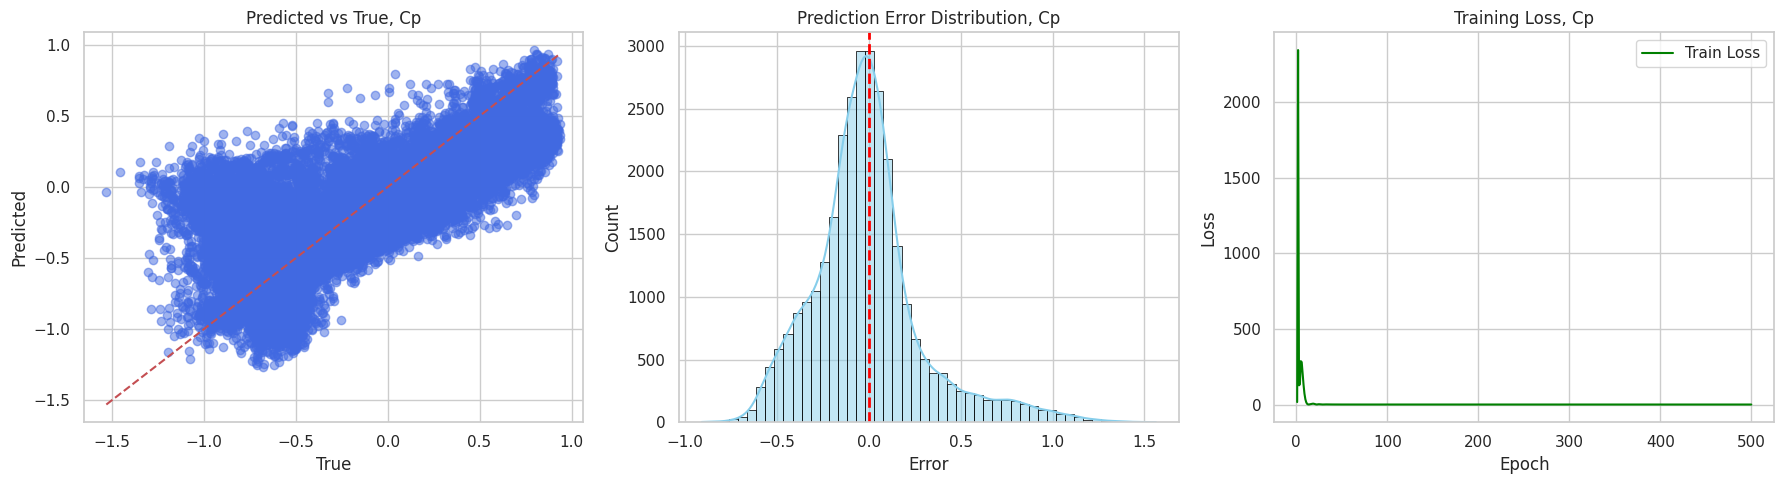

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 2/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.96it/s]

Epoch [10/500], Loss: 1.9752


Epochs:   4%|▍         | 20/500 [00:00<00:05, 91.02it/s]

Epoch [20/500], Loss: 0.4938
Epoch [30/500], Loss: 1.0416


Epochs:   6%|▋         | 32/500 [00:00<00:04, 101.71it/s]

Epoch [40/500], Loss: 0.2331


Epochs:  12%|█▏        | 60/500 [00:00<00:03, 119.18it/s]

Epoch [50/500], Loss: 0.2676
Epoch [60/500], Loss: 0.2299


Epochs:  15%|█▍        | 74/500 [00:00<00:03, 123.01it/s]

Epoch [70/500], Loss: 0.2127


Epochs:  18%|█▊        | 88/500 [00:00<00:03, 125.51it/s]

Epoch [80/500], Loss: 0.2031
Epoch [90/500], Loss: 0.1888


Epochs:  20%|██        | 101/500 [00:00<00:03, 126.81it/s]

Epoch [100/500], Loss: 0.1694


Epochs:  23%|██▎       | 115/500 [00:00<00:03, 127.89it/s]

Epoch [110/500], Loss: 0.1505
Epoch [120/500], Loss: 0.1538


Epochs:  26%|██▌       | 129/500 [00:01<00:02, 128.63it/s]

Epoch [130/500], Loss: 0.1598


Epochs:  31%|███       | 156/500 [00:01<00:02, 129.22it/s]

Epoch [140/500], Loss: 0.1472
Epoch [150/500], Loss: 0.1410
Epoch [160/500], Loss: 0.1324


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 129.55it/s]

Epoch [170/500], Loss: 0.1276
Epoch [180/500], Loss: 0.1232


Epochs:  39%|███▉      | 195/500 [00:01<00:02, 129.44it/s]

Epoch [190/500], Loss: 0.1201


Epochs:  42%|████▏     | 209/500 [00:01<00:02, 129.77it/s]

Epoch [200/500], Loss: 0.1173
Epoch [210/500], Loss: 0.1150


Epochs:  44%|████▍     | 222/500 [00:01<00:02, 129.70it/s]

Epoch [220/500], Loss: 0.1129


Epochs:  47%|████▋     | 235/500 [00:01<00:02, 129.61it/s]

Epoch [230/500], Loss: 0.1112
Epoch [240/500], Loss: 0.1098


Epochs:  50%|████▉     | 248/500 [00:01<00:01, 129.60it/s]

Epoch [250/500], Loss: 0.1087


Epochs:  55%|█████▍    | 274/500 [00:02<00:01, 129.42it/s]

Epoch [260/500], Loss: 0.1078
Epoch [270/500], Loss: 0.1069
Epoch [280/500], Loss: 0.1062


Epochs:  60%|██████    | 301/500 [00:02<00:01, 129.66it/s]

Epoch [290/500], Loss: 0.1054
Epoch [300/500], Loss: 0.1046


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 127.99it/s]

Epoch [310/500], Loss: 0.1035


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 128.49it/s]

Epoch [320/500], Loss: 0.1015
Epoch [330/500], Loss: 0.1003


Epochs:  68%|██████▊   | 340/500 [00:02<00:01, 128.29it/s]

Epoch [340/500], Loss: 0.0960


Epochs:  71%|███████   | 353/500 [00:02<00:01, 128.56it/s]

Epoch [350/500], Loss: 0.0933
Epoch [360/500], Loss: 0.0902


Epochs:  73%|███████▎  | 366/500 [00:02<00:01, 128.75it/s]

Epoch [370/500], Loss: 0.0880


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 128.80it/s]

Epoch [380/500], Loss: 0.0864
Epoch [390/500], Loss: 0.0851


Epochs:  81%|████████  | 405/500 [00:03<00:00, 128.85it/s]

Epoch [400/500], Loss: 0.0840


Epochs:  84%|████████▎ | 418/500 [00:03<00:00, 129.00it/s]

Epoch [410/500], Loss: 0.0829
Epoch [420/500], Loss: 0.0821


Epochs:  86%|████████▌ | 431/500 [00:03<00:00, 128.65it/s]

Epoch [430/500], Loss: 0.0814


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 128.74it/s]

Epoch [440/500], Loss: 0.0801
Epoch [450/500], Loss: 0.0793


Epochs:  91%|█████████▏| 457/500 [00:03<00:00, 129.04it/s]

Epoch [460/500], Loss: 0.0785


Epochs:  97%|█████████▋| 484/500 [00:03<00:00, 129.38it/s]

Epoch [470/500], Loss: 0.0777
Epoch [480/500], Loss: 0.0774
Epoch [490/500], Loss: 0.0764


Epochs: 100%|██████████| 500/500 [00:03<00:00, 126.82it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0757
📈 Evaluation metrics on test set:
MSE: 0.0769
MAE: 0.1951
R2: 0.6899


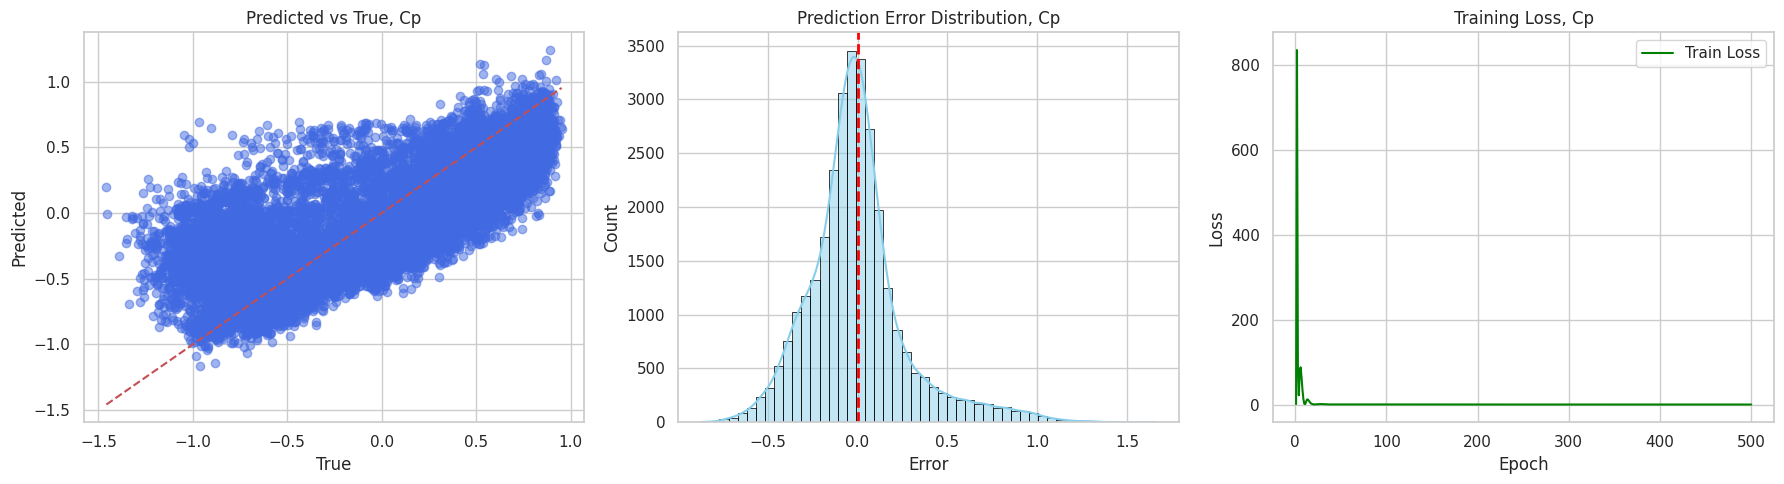

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 3/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 98.01it/s]

Epoch [10/500], Loss: 14.4278
Epoch [20/500], Loss: 2.4403
Epoch [30/500], Loss: 0.3827


Epochs:  12%|█▏        | 61/500 [00:00<00:03, 122.72it/s]

Epoch [40/500], Loss: 0.2283
Epoch [50/500], Loss: 0.2165
Epoch [60/500], Loss: 0.2025


Epochs:  18%|█▊        | 88/500 [00:00<00:03, 126.65it/s]

Epoch [70/500], Loss: 0.1951
Epoch [80/500], Loss: 0.1790
Epoch [90/500], Loss: 0.1697


Epochs:  23%|██▎       | 114/500 [00:00<00:03, 128.05it/s]

Epoch [100/500], Loss: 0.1487
Epoch [110/500], Loss: 0.1637
Epoch [120/500], Loss: 0.1328


Epochs:  31%|███       | 153/500 [00:01<00:02, 129.16it/s]

Epoch [130/500], Loss: 0.1197
Epoch [140/500], Loss: 0.1226
Epoch [150/500], Loss: 0.1056


Epochs:  36%|███▌      | 180/500 [00:01<00:02, 129.53it/s]

Epoch [160/500], Loss: 0.1072
Epoch [170/500], Loss: 0.1066
Epoch [180/500], Loss: 0.0959


Epochs:  41%|████      | 206/500 [00:01<00:02, 129.59it/s]

Epoch [190/500], Loss: 0.0911
Epoch [200/500], Loss: 0.0885
Epoch [210/500], Loss: 0.0886


Epochs:  49%|████▉     | 245/500 [00:01<00:01, 129.68it/s]

Epoch [220/500], Loss: 0.0877
Epoch [230/500], Loss: 0.0898
Epoch [240/500], Loss: 0.0914


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 129.20it/s]

Epoch [250/500], Loss: 0.0844
Epoch [260/500], Loss: 0.0847
Epoch [270/500], Loss: 0.0836


Epochs:  60%|█████▉    | 298/500 [00:02<00:01, 129.31it/s]

Epoch [280/500], Loss: 0.0820
Epoch [290/500], Loss: 0.0961
Epoch [300/500], Loss: 0.0917


Epochs:  65%|██████▍   | 324/500 [00:02<00:01, 129.26it/s]

Epoch [310/500], Loss: 0.0845
Epoch [320/500], Loss: 0.0819
Epoch [330/500], Loss: 0.0800


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 129.51it/s]

Epoch [340/500], Loss: 0.0790
Epoch [350/500], Loss: 0.0785
Epoch [360/500], Loss: 0.0779


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 129.03it/s]

Epoch [370/500], Loss: 0.0773
Epoch [380/500], Loss: 0.0768
Epoch [390/500], Loss: 0.0762


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 129.36it/s]

Epoch [400/500], Loss: 0.0841
Epoch [410/500], Loss: 0.0792
Epoch [420/500], Loss: 0.0754


Epochs:  91%|█████████ | 455/500 [00:03<00:00, 129.30it/s]

Epoch [430/500], Loss: 0.0747
Epoch [440/500], Loss: 0.0744
Epoch [450/500], Loss: 0.0920


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 129.10it/s]

Epoch [460/500], Loss: 0.0740
Epoch [470/500], Loss: 0.0747
Epoch [480/500], Loss: 0.0736


Epochs: 100%|██████████| 500/500 [00:03<00:00, 127.59it/s]


Epoch [490/500], Loss: 0.0724
Epoch [500/500], Loss: 0.0723
📈 Evaluation metrics on test set:
MSE: 0.0741
MAE: 0.1903
R2: 0.7011


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


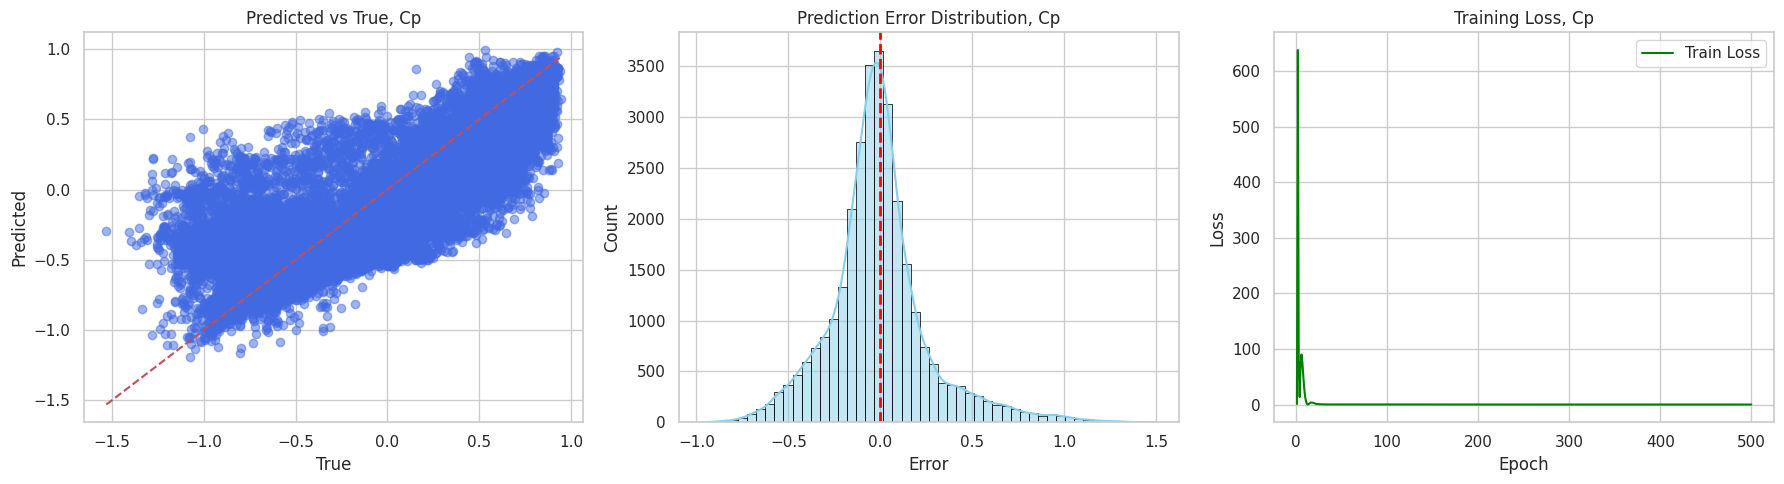

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 4/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   6%|▌         | 28/500 [00:00<00:03, 129.25it/s]

Epoch [10/500], Loss: 1.6515
Epoch [20/500], Loss: 4.2312
Epoch [30/500], Loss: 0.2263


Epochs:  11%|█         | 54/500 [00:00<00:03, 128.60it/s]

Epoch [40/500], Loss: 0.2891
Epoch [50/500], Loss: 0.2754
Epoch [60/500], Loss: 0.2365


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 128.55it/s]

Epoch [70/500], Loss: 0.2131
Epoch [80/500], Loss: 0.2043
Epoch [90/500], Loss: 0.1977


Epochs:  24%|██▍       | 119/500 [00:00<00:02, 128.64it/s]

Epoch [100/500], Loss: 0.1932
Epoch [110/500], Loss: 0.1887
Epoch [120/500], Loss: 0.1820


Epochs:  29%|██▉       | 145/500 [00:01<00:02, 128.26it/s]

Epoch [130/500], Loss: 0.1785
Epoch [140/500], Loss: 0.1767
Epoch [150/500], Loss: 0.1728


Epochs:  37%|███▋      | 184/500 [00:01<00:02, 128.17it/s]

Epoch [160/500], Loss: 0.1594
Epoch [170/500], Loss: 0.1425
Epoch [180/500], Loss: 0.1359


Epochs:  42%|████▏     | 210/500 [00:01<00:02, 127.77it/s]

Epoch [190/500], Loss: 0.1302
Epoch [200/500], Loss: 0.1249
Epoch [210/500], Loss: 0.1191


Epochs:  47%|████▋     | 236/500 [00:01<00:02, 127.97it/s]

Epoch [220/500], Loss: 0.1154
Epoch [230/500], Loss: 0.1122
Epoch [240/500], Loss: 0.1100


Epochs:  55%|█████▌    | 275/500 [00:02<00:01, 127.79it/s]

Epoch [250/500], Loss: 0.1084
Epoch [260/500], Loss: 0.1073
Epoch [270/500], Loss: 0.1064


Epochs:  60%|██████    | 301/500 [00:02<00:01, 127.86it/s]

Epoch [280/500], Loss: 0.1055
Epoch [290/500], Loss: 0.1046
Epoch [300/500], Loss: 0.1039


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 128.00it/s]

Epoch [310/500], Loss: 0.1033
Epoch [320/500], Loss: 0.1016
Epoch [330/500], Loss: 0.0974


Epochs:  71%|███████   | 353/500 [00:02<00:01, 127.96it/s]

Epoch [340/500], Loss: 0.0937
Epoch [350/500], Loss: 0.0881
Epoch [360/500], Loss: 0.0847


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 127.59it/s]

Epoch [370/500], Loss: 0.0894
Epoch [380/500], Loss: 0.0827
Epoch [390/500], Loss: 0.0805


Epochs:  84%|████████▎ | 418/500 [00:03<00:00, 127.46it/s]

Epoch [400/500], Loss: 0.0798
Epoch [410/500], Loss: 0.0787
Epoch [420/500], Loss: 0.0823


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 127.40it/s]

Epoch [430/500], Loss: 0.0791
Epoch [440/500], Loss: 0.0773
Epoch [450/500], Loss: 0.0764


Epochs:  97%|█████████▋| 483/500 [00:03<00:00, 127.73it/s]

Epoch [460/500], Loss: 0.0758
Epoch [470/500], Loss: 0.0749
Epoch [480/500], Loss: 0.0749


Epochs: 100%|██████████| 500/500 [00:03<00:00, 127.95it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0745
Epoch [500/500], Loss: 0.0734
📈 Evaluation metrics on test set:
MSE: 0.0727
MAE: 0.1895
R2: 0.7069


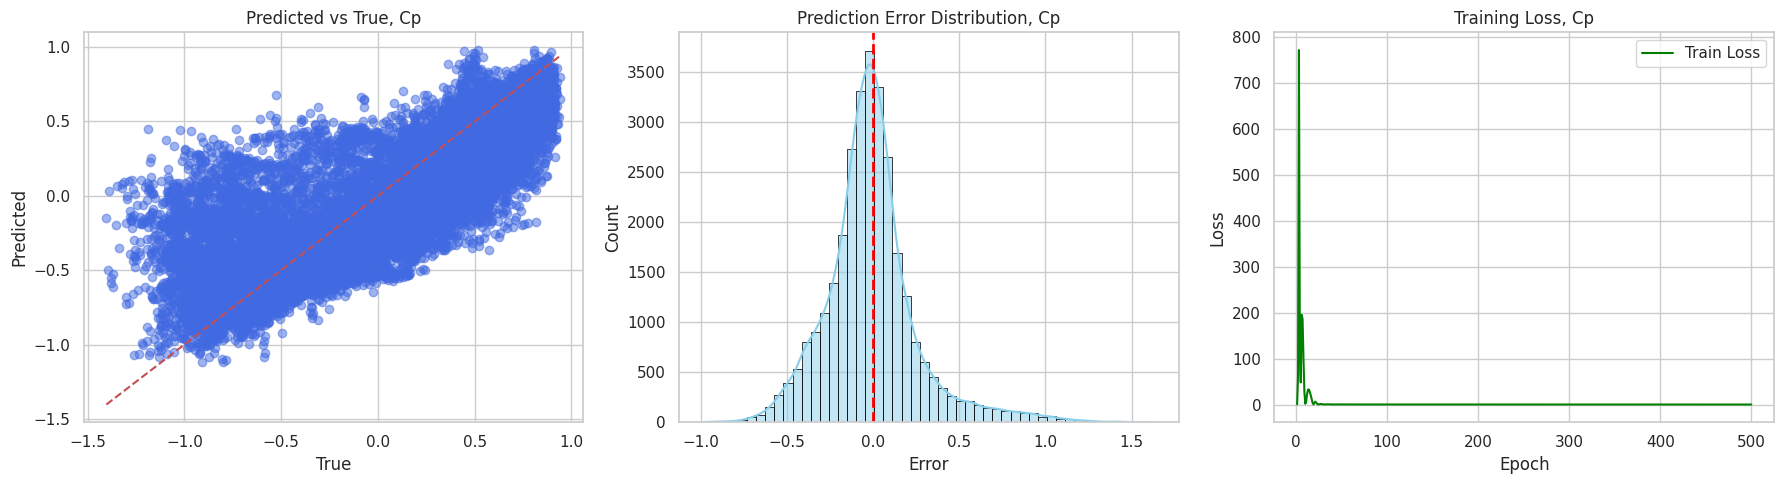

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 5/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 101.00it/s]

Epoch [10/500], Loss: 3.3833
Epoch [20/500], Loss: 9.8192
Epoch [30/500], Loss: 0.2991


Epochs:  12%|█▏        | 59/500 [00:00<00:03, 120.07it/s]

Epoch [40/500], Loss: 0.7323
Epoch [50/500], Loss: 0.2747
Epoch [60/500], Loss: 0.2600


Epochs:  17%|█▋        | 85/500 [00:00<00:03, 124.61it/s]

Epoch [70/500], Loss: 0.2297
Epoch [80/500], Loss: 0.2120
Epoch [90/500], Loss: 0.1798


Epochs:  25%|██▍       | 124/500 [00:01<00:02, 127.42it/s]

Epoch [100/500], Loss: 0.1526
Epoch [110/500], Loss: 0.1361
Epoch [120/500], Loss: 0.1796


Epochs:  30%|███       | 150/500 [00:01<00:02, 127.93it/s]

Epoch [130/500], Loss: 0.1401
Epoch [140/500], Loss: 0.1289
Epoch [150/500], Loss: 0.1225


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 128.35it/s]

Epoch [160/500], Loss: 0.1181
Epoch [170/500], Loss: 0.1146
Epoch [180/500], Loss: 0.1112


Epochs:  43%|████▎     | 215/500 [00:01<00:02, 128.18it/s]

Epoch [190/500], Loss: 0.1084
Epoch [200/500], Loss: 0.1060
Epoch [210/500], Loss: 0.1040


Epochs:  48%|████▊     | 241/500 [00:01<00:02, 127.76it/s]

Epoch [220/500], Loss: 0.1021
Epoch [230/500], Loss: 0.1004
Epoch [240/500], Loss: 0.0988


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 127.63it/s]

Epoch [250/500], Loss: 0.0973
Epoch [260/500], Loss: 0.0958
Epoch [270/500], Loss: 0.0944


Epochs:  59%|█████▊    | 293/500 [00:02<00:01, 127.79it/s]

Epoch [280/500], Loss: 0.0924
Epoch [290/500], Loss: 0.0901
Epoch [300/500], Loss: 0.0877


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 127.46it/s]

Epoch [310/500], Loss: 0.0858
Epoch [320/500], Loss: 0.0843
Epoch [330/500], Loss: 0.0831


Epochs:  72%|███████▏  | 358/500 [00:02<00:01, 128.09it/s]

Epoch [340/500], Loss: 0.0821
Epoch [350/500], Loss: 0.0811
Epoch [360/500], Loss: 0.0804


Epochs:  77%|███████▋  | 384/500 [00:03<00:00, 128.08it/s]

Epoch [370/500], Loss: 0.0800
Epoch [380/500], Loss: 0.0786
Epoch [390/500], Loss: 0.0782


Epochs:  85%|████████▍ | 423/500 [00:03<00:00, 127.93it/s]

Epoch [400/500], Loss: 0.0774
Epoch [410/500], Loss: 0.0769
Epoch [420/500], Loss: 0.0766


Epochs:  90%|████████▉ | 449/500 [00:03<00:00, 128.06it/s]

Epoch [430/500], Loss: 0.0761
Epoch [440/500], Loss: 0.0756
Epoch [450/500], Loss: 0.0753


Epochs:  95%|█████████▌| 475/500 [00:03<00:00, 128.14it/s]

Epoch [460/500], Loss: 0.0745
Epoch [470/500], Loss: 0.0742
Epoch [480/500], Loss: 0.0742


Epochs: 100%|██████████| 500/500 [00:03<00:00, 126.25it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0738
Epoch [500/500], Loss: 0.0734
📈 Evaluation metrics on test set:
MSE: 0.0755
MAE: 0.1910
R2: 0.6982


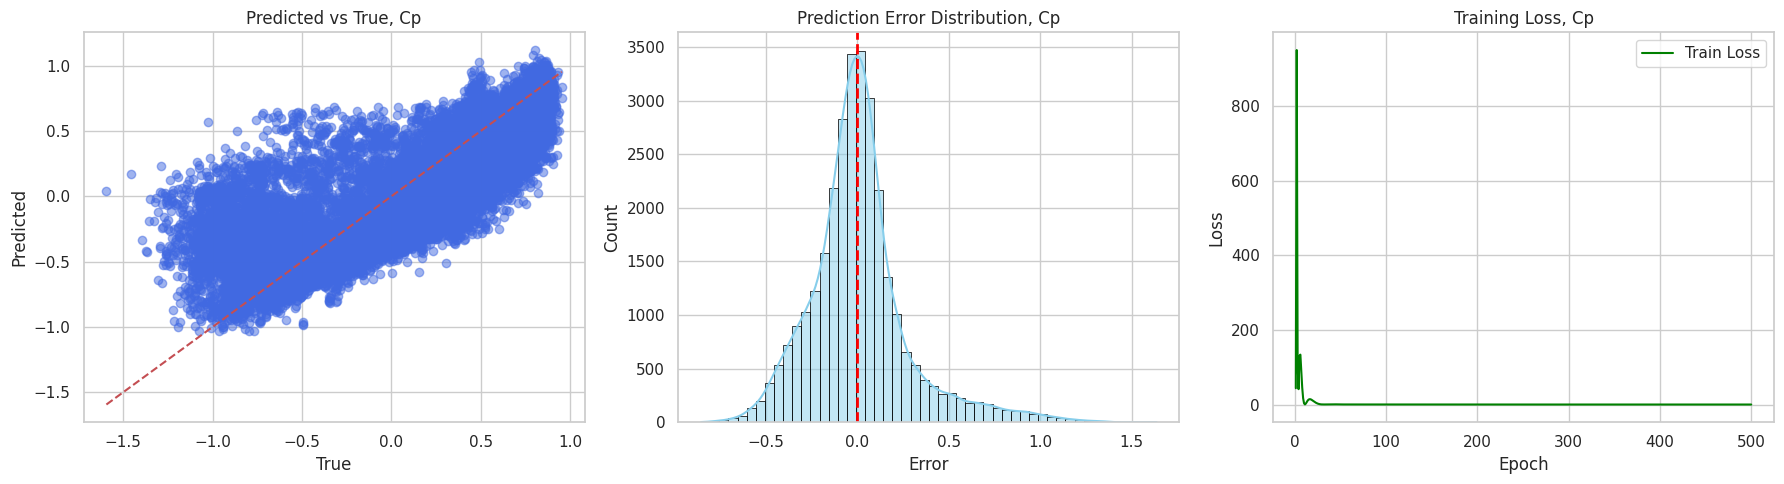

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 6/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▍         | 23/500 [00:00<00:04, 103.60it/s]

Epoch [10/500], Loss: 1.0264
Epoch [20/500], Loss: 12.8218
Epoch [30/500], Loss: 0.4370


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 121.74it/s]

Epoch [40/500], Loss: 1.0415
Epoch [50/500], Loss: 0.4573
Epoch [60/500], Loss: 0.3032


Epochs:  18%|█▊        | 88/500 [00:00<00:03, 124.81it/s]

Epoch [70/500], Loss: 0.2639
Epoch [80/500], Loss: 0.2561
Epoch [90/500], Loss: 0.2473


Epochs:  23%|██▎       | 114/500 [00:00<00:03, 126.22it/s]

Epoch [100/500], Loss: 0.2305
Epoch [110/500], Loss: 0.2161
Epoch [120/500], Loss: 0.2047


Epochs:  31%|███       | 153/500 [00:01<00:02, 127.09it/s]

Epoch [130/500], Loss: 0.1946
Epoch [140/500], Loss: 0.1891
Epoch [150/500], Loss: 0.1856


Epochs:  36%|███▌      | 179/500 [00:01<00:02, 127.42it/s]

Epoch [160/500], Loss: 0.1726
Epoch [170/500], Loss: 0.1556
Epoch [180/500], Loss: 0.1430


Epochs:  41%|████      | 205/500 [00:01<00:02, 127.52it/s]

Epoch [190/500], Loss: 0.1352
Epoch [200/500], Loss: 0.1295
Epoch [210/500], Loss: 0.1250


Epochs:  49%|████▉     | 244/500 [00:01<00:02, 127.78it/s]

Epoch [220/500], Loss: 0.1213
Epoch [230/500], Loss: 0.1183
Epoch [240/500], Loss: 0.1157


Epochs:  54%|█████▍    | 270/500 [00:02<00:01, 127.67it/s]

Epoch [250/500], Loss: 0.1135
Epoch [260/500], Loss: 0.1135
Epoch [270/500], Loss: 0.1110


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 127.13it/s]

Epoch [280/500], Loss: 0.1085
Epoch [290/500], Loss: 0.1071
Epoch [300/500], Loss: 0.1057


Epochs:  67%|██████▋   | 335/500 [00:02<00:01, 126.96it/s]

Epoch [310/500], Loss: 0.1043
Epoch [320/500], Loss: 0.1030
Epoch [330/500], Loss: 0.1019


Epochs:  72%|███████▏  | 361/500 [00:02<00:01, 126.95it/s]

Epoch [340/500], Loss: 0.1010
Epoch [350/500], Loss: 0.0999
Epoch [360/500], Loss: 0.1012


Epochs:  77%|███████▋  | 387/500 [00:03<00:00, 127.22it/s]

Epoch [370/500], Loss: 0.0987
Epoch [380/500], Loss: 0.0978
Epoch [390/500], Loss: 0.0970


Epochs:  83%|████████▎ | 413/500 [00:03<00:00, 127.47it/s]

Epoch [400/500], Loss: 0.0969
Epoch [410/500], Loss: 0.0986
Epoch [420/500], Loss: 0.0955


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 127.18it/s]

Epoch [430/500], Loss: 0.0945
Epoch [440/500], Loss: 0.0959
Epoch [450/500], Loss: 0.0951


Epochs:  96%|█████████▌| 478/500 [00:03<00:00, 127.10it/s]

Epoch [460/500], Loss: 0.0933
Epoch [470/500], Loss: 0.0937
Epoch [480/500], Loss: 0.0922


Epochs: 100%|██████████| 500/500 [00:03<00:00, 125.96it/s]


Epoch [490/500], Loss: 0.0913
Epoch [500/500], Loss: 0.0900
📈 Evaluation metrics on test set:
MSE: 0.0898
MAE: 0.2142
R2: 0.6403


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


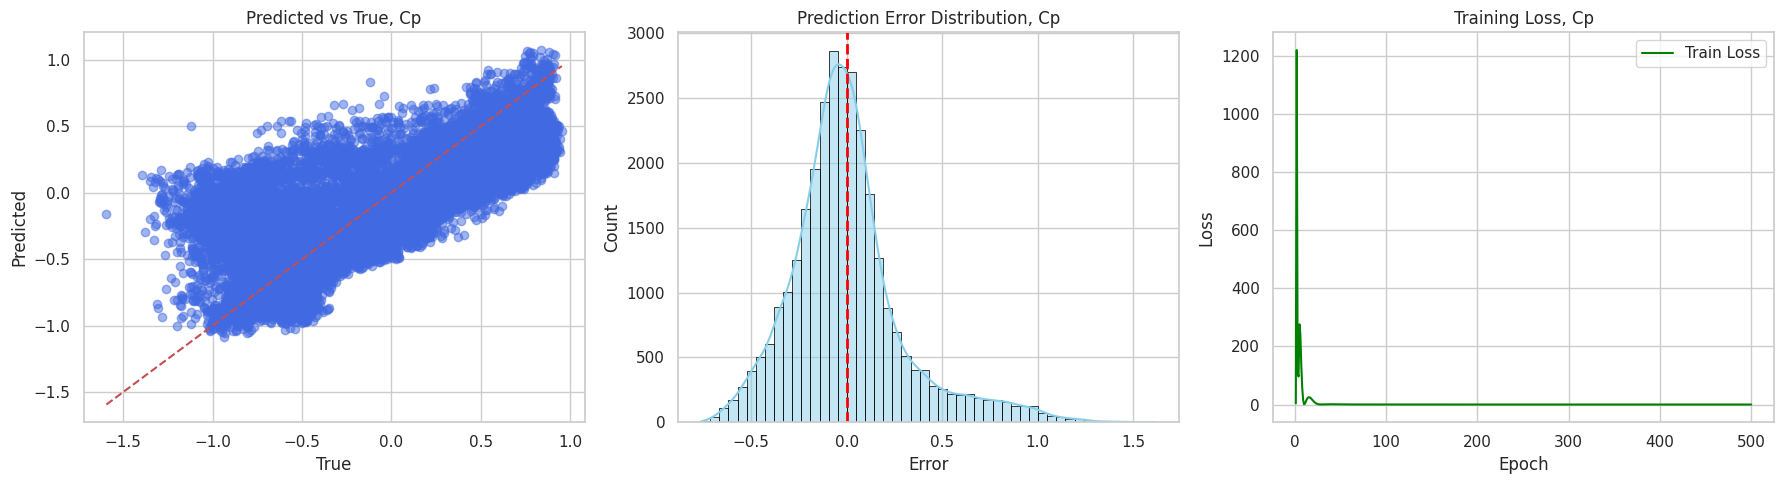

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 7/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   3%|▎         | 14/500 [00:00<00:03, 130.76it/s]

Epoch [10/500], Loss: 1.9173
Epoch [20/500], Loss: 4.2808


Epochs:   6%|▌         | 28/500 [00:00<00:03, 128.47it/s]

Epoch [30/500], Loss: 0.2697


Epochs:  11%|█         | 54/500 [00:00<00:03, 127.69it/s]

Epoch [40/500], Loss: 0.2527
Epoch [50/500], Loss: 0.2126
Epoch [60/500], Loss: 0.2092


Epochs:  16%|█▌        | 80/500 [00:00<00:03, 127.84it/s]

Epoch [70/500], Loss: 0.2048
Epoch [80/500], Loss: 0.1998


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 127.80it/s]

Epoch [90/500], Loss: 0.1971


Epochs:  21%|██        | 106/500 [00:00<00:03, 127.62it/s]

Epoch [100/500], Loss: 0.1940
Epoch [110/500], Loss: 0.1899


Epochs:  24%|██▍       | 119/500 [00:00<00:02, 127.62it/s]

Epoch [120/500], Loss: 0.1696


Epochs:  29%|██▉       | 145/500 [00:01<00:02, 126.90it/s]

Epoch [130/500], Loss: 0.1589
Epoch [140/500], Loss: 0.1504
Epoch [150/500], Loss: 0.1429


Epochs:  34%|███▍      | 171/500 [00:01<00:02, 127.07it/s]

Epoch [160/500], Loss: 0.1355
Epoch [170/500], Loss: 0.1259


Epochs:  37%|███▋      | 184/500 [00:01<00:02, 127.10it/s]

Epoch [180/500], Loss: 0.1162


Epochs:  39%|███▉      | 197/500 [00:01<00:02, 127.28it/s]

Epoch [190/500], Loss: 0.1091
Epoch [200/500], Loss: 0.1029


Epochs:  42%|████▏     | 210/500 [00:01<00:02, 127.36it/s]

Epoch [210/500], Loss: 0.0987


Epochs:  45%|████▍     | 223/500 [00:01<00:02, 127.35it/s]

Epoch [220/500], Loss: 0.0942
Epoch [230/500], Loss: 0.0930


Epochs:  47%|████▋     | 236/500 [00:01<00:02, 127.30it/s]

Epoch [240/500], Loss: 0.0914


Epochs:  52%|█████▏    | 262/500 [00:02<00:01, 127.15it/s]

Epoch [250/500], Loss: 0.0912
Epoch [260/500], Loss: 0.0877


Epochs:  55%|█████▌    | 275/500 [00:02<00:01, 127.18it/s]

Epoch [270/500], Loss: 0.0879


Epochs:  58%|█████▊    | 288/500 [00:02<00:01, 127.25it/s]

Epoch [280/500], Loss: 0.0863
Epoch [290/500], Loss: 0.0846


Epochs:  60%|██████    | 301/500 [00:02<00:01, 127.19it/s]

Epoch [300/500], Loss: 0.0839


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 127.08it/s]

Epoch [310/500], Loss: 0.0835
Epoch [320/500], Loss: 0.0879


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 127.31it/s]

Epoch [330/500], Loss: 0.0823


Epochs:  71%|███████   | 353/500 [00:02<00:01, 126.84it/s]

Epoch [340/500], Loss: 0.0854
Epoch [350/500], Loss: 0.0817
Epoch [360/500], Loss: 0.0808


Epochs:  76%|███████▌  | 379/500 [00:02<00:00, 127.10it/s]

Epoch [370/500], Loss: 0.0804
Epoch [380/500], Loss: 0.0799


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 126.64it/s]

Epoch [390/500], Loss: 0.0795


Epochs:  81%|████████  | 405/500 [00:03<00:00, 126.63it/s]

Epoch [400/500], Loss: 0.0791
Epoch [410/500], Loss: 0.0787


Epochs:  84%|████████▎ | 418/500 [00:03<00:00, 126.78it/s]

Epoch [420/500], Loss: 0.0784


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 126.77it/s]

Epoch [430/500], Loss: 0.0781
Epoch [440/500], Loss: 0.0829
Epoch [450/500], Loss: 0.0783


Epochs:  94%|█████████▍| 470/500 [00:03<00:00, 127.07it/s]

Epoch [460/500], Loss: 0.0786
Epoch [470/500], Loss: 0.0772


Epochs:  97%|█████████▋| 483/500 [00:03<00:00, 127.12it/s]

Epoch [480/500], Loss: 0.0770


Epochs: 100%|██████████| 500/500 [00:03<00:00, 127.19it/s]

Epoch [490/500], Loss: 0.0767
Epoch [500/500], Loss: 0.0763
📈 Evaluation metrics on test set:
MSE: 0.0778
MAE: 0.1956
R2: 0.6891



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


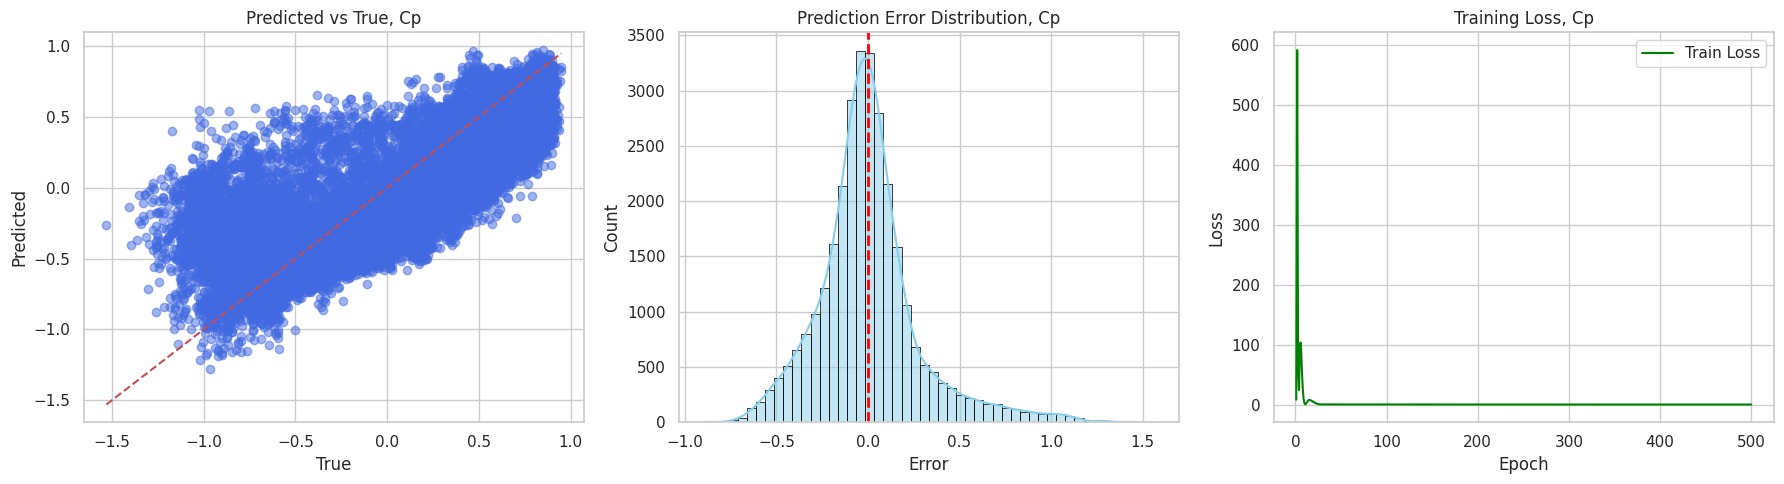

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 8/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.94it/s]

Epoch [10/500], Loss: 15.3356


Epochs:   4%|▍         | 21/500 [00:00<00:04, 100.31it/s]

Epoch [20/500], Loss: 0.2587
Epoch [30/500], Loss: 0.2428


Epochs:   7%|▋         | 33/500 [00:00<00:04, 105.03it/s]

Epoch [40/500], Loss: 0.2404


Epochs:  12%|█▏        | 59/500 [00:00<00:03, 118.18it/s]

Epoch [50/500], Loss: 0.2270
Epoch [60/500], Loss: 0.2230


Epochs:  14%|█▍        | 72/500 [00:00<00:03, 121.10it/s]

Epoch [70/500], Loss: 0.2208


Epochs:  17%|█▋        | 85/500 [00:00<00:03, 123.10it/s]

Epoch [80/500], Loss: 0.2180
Epoch [90/500], Loss: 0.2152


Epochs:  20%|█▉        | 98/500 [00:00<00:03, 124.38it/s]

Epoch [100/500], Loss: 0.2114


Epochs:  25%|██▍       | 124/500 [00:01<00:02, 125.96it/s]

Epoch [110/500], Loss: 0.2097
Epoch [120/500], Loss: 0.2024
Epoch [130/500], Loss: 0.1896


Epochs:  30%|███       | 150/500 [00:01<00:02, 126.60it/s]

Epoch [140/500], Loss: 0.1755
Epoch [150/500], Loss: 0.1608


Epochs:  33%|███▎      | 163/500 [00:01<00:02, 126.66it/s]

Epoch [160/500], Loss: 0.1604


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 126.54it/s]

Epoch [170/500], Loss: 0.1552
Epoch [180/500], Loss: 0.1485


Epochs:  38%|███▊      | 189/500 [00:01<00:02, 126.72it/s]

Epoch [190/500], Loss: 0.1445


Epochs:  43%|████▎     | 215/500 [00:01<00:02, 126.90it/s]

Epoch [200/500], Loss: 0.1415
Epoch [210/500], Loss: 0.1390
Epoch [220/500], Loss: 0.1370


Epochs:  48%|████▊     | 241/500 [00:01<00:02, 126.82it/s]

Epoch [230/500], Loss: 0.1349
Epoch [240/500], Loss: 0.1332


Epochs:  51%|█████     | 254/500 [00:02<00:01, 126.97it/s]

Epoch [250/500], Loss: 0.1320


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 127.10it/s]

Epoch [260/500], Loss: 0.1307
Epoch [270/500], Loss: 0.1295


Epochs:  56%|█████▌    | 280/500 [00:02<00:01, 126.79it/s]

Epoch [280/500], Loss: 0.1284


Epochs:  59%|█████▊    | 293/500 [00:02<00:01, 126.88it/s]

Epoch [290/500], Loss: 0.1273
Epoch [300/500], Loss: 0.1264


Epochs:  61%|██████    | 306/500 [00:02<00:01, 127.13it/s]

Epoch [310/500], Loss: 0.1251


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 126.89it/s]

Epoch [320/500], Loss: 0.1247
Epoch [330/500], Loss: 0.1230


Epochs:  69%|██████▉   | 345/500 [00:02<00:01, 127.05it/s]

Epoch [340/500], Loss: 0.1224


Epochs:  72%|███████▏  | 358/500 [00:02<00:01, 127.10it/s]

Epoch [350/500], Loss: 0.1214
Epoch [360/500], Loss: 0.1206


Epochs:  74%|███████▍  | 371/500 [00:02<00:01, 126.79it/s]

Epoch [370/500], Loss: 0.1217


Epochs:  77%|███████▋  | 384/500 [00:03<00:00, 126.86it/s]

Epoch [380/500], Loss: 0.1197
Epoch [390/500], Loss: 0.1186


Epochs:  79%|███████▉  | 397/500 [00:03<00:00, 126.76it/s]

Epoch [400/500], Loss: 0.1180


Epochs:  85%|████████▍ | 423/500 [00:03<00:00, 126.74it/s]

Epoch [410/500], Loss: 0.1170
Epoch [420/500], Loss: 0.1256
Epoch [430/500], Loss: 0.1211


Epochs:  90%|████████▉ | 449/500 [00:03<00:00, 126.76it/s]

Epoch [440/500], Loss: 0.1178
Epoch [450/500], Loss: 0.1150


Epochs:  92%|█████████▏| 462/500 [00:03<00:00, 126.73it/s]

Epoch [460/500], Loss: 0.1100


Epochs:  95%|█████████▌| 475/500 [00:03<00:00, 126.82it/s]

Epoch [470/500], Loss: 0.1617
Epoch [480/500], Loss: 0.1292


Epochs:  98%|█████████▊| 488/500 [00:03<00:00, 126.90it/s]

Epoch [490/500], Loss: 0.1299


Epochs: 100%|██████████| 500/500 [00:03<00:00, 125.00it/s]


Epoch [500/500], Loss: 0.1255
📈 Evaluation metrics on test set:
MSE: 0.1243
MAE: 0.2626
R2: 0.4925


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


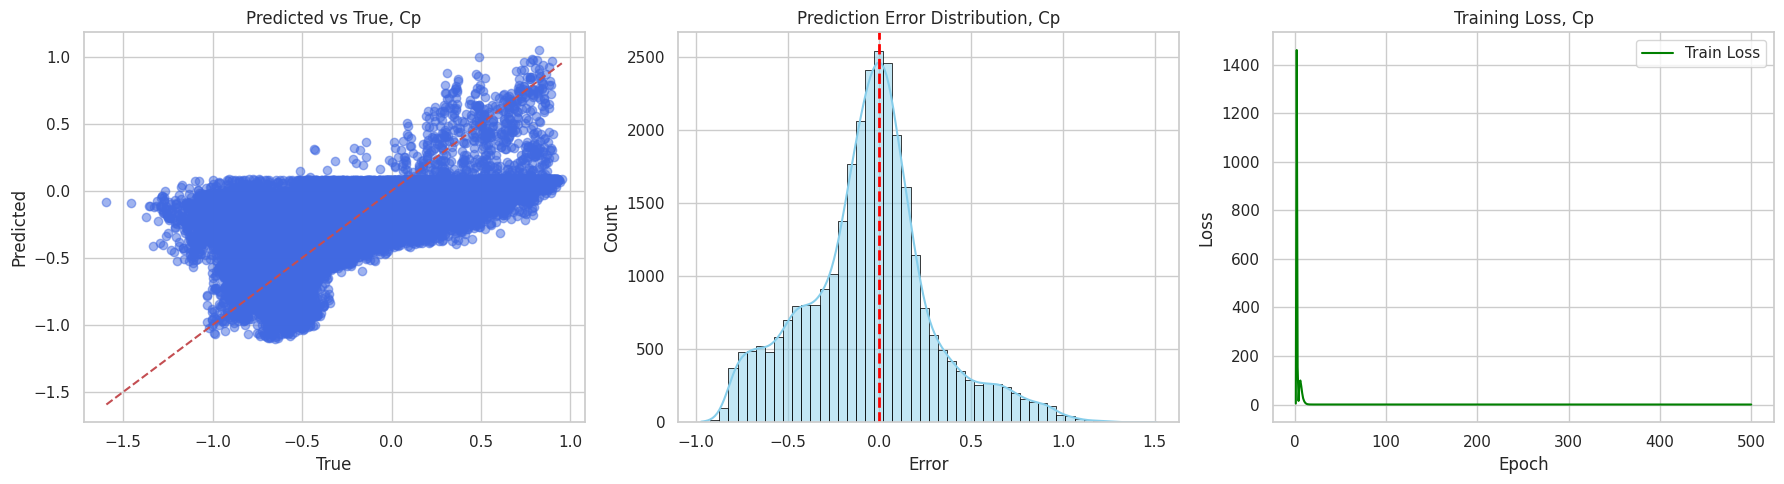

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 9/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   4%|▍         | 20/500 [00:00<00:04, 96.05it/s]

Epoch [10/500], Loss: 34.7996
Epoch [20/500], Loss: 0.4546
Epoch [30/500], Loss: 2.2261


Epochs:  11%|█▏        | 57/500 [00:00<00:03, 115.40it/s]

Epoch [40/500], Loss: 0.4260
Epoch [50/500], Loss: 0.2438
Epoch [60/500], Loss: 0.2327


Epochs:  17%|█▋        | 83/500 [00:00<00:03, 121.43it/s]

Epoch [70/500], Loss: 0.2276
Epoch [80/500], Loss: 0.2216
Epoch [90/500], Loss: 0.2158


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 124.31it/s]

Epoch [100/500], Loss: 0.2121
Epoch [110/500], Loss: 0.2071
Epoch [120/500], Loss: 0.1919


Epochs:  30%|██▉       | 148/500 [00:01<00:02, 125.49it/s]

Epoch [130/500], Loss: 0.1823
Epoch [140/500], Loss: 0.1619
Epoch [150/500], Loss: 0.1495


Epochs:  35%|███▍      | 174/500 [00:01<00:02, 125.58it/s]

Epoch [160/500], Loss: 0.1292
Epoch [170/500], Loss: 0.1191
Epoch [180/500], Loss: 0.1133


Epochs:  43%|████▎     | 213/500 [00:01<00:02, 125.84it/s]

Epoch [190/500], Loss: 0.1093
Epoch [200/500], Loss: 0.1058
Epoch [210/500], Loss: 0.1036


Epochs:  48%|████▊     | 239/500 [00:01<00:02, 125.83it/s]

Epoch [220/500], Loss: 0.1017
Epoch [230/500], Loss: 0.1000
Epoch [240/500], Loss: 0.0986


Epochs:  53%|█████▎    | 265/500 [00:02<00:01, 125.07it/s]

Epoch [250/500], Loss: 0.0968
Epoch [260/500], Loss: 0.0952
Epoch [270/500], Loss: 0.0937


Epochs:  61%|██████    | 304/500 [00:02<00:01, 125.34it/s]

Epoch [280/500], Loss: 0.0923
Epoch [290/500], Loss: 0.0902
Epoch [300/500], Loss: 0.0885


Epochs:  66%|██████▌   | 330/500 [00:02<00:01, 125.47it/s]

Epoch [310/500], Loss: 0.0865
Epoch [320/500], Loss: 0.0849
Epoch [330/500], Loss: 0.0831


Epochs:  71%|███████   | 356/500 [00:02<00:01, 124.73it/s]

Epoch [340/500], Loss: 0.0814
Epoch [350/500], Loss: 0.0798
Epoch [360/500], Loss: 0.0785


Epochs:  79%|███████▉  | 395/500 [00:03<00:00, 125.13it/s]

Epoch [370/500], Loss: 0.0774
Epoch [380/500], Loss: 0.0766
Epoch [390/500], Loss: 0.0760


Epochs:  84%|████████▍ | 421/500 [00:03<00:00, 125.05it/s]

Epoch [400/500], Loss: 0.0755
Epoch [410/500], Loss: 0.0749
Epoch [420/500], Loss: 0.0745


Epochs:  89%|████████▉ | 447/500 [00:03<00:00, 125.13it/s]

Epoch [430/500], Loss: 0.0741
Epoch [440/500], Loss: 0.0739
Epoch [450/500], Loss: 0.0733


Epochs:  95%|█████████▍| 473/500 [00:03<00:00, 125.30it/s]

Epoch [460/500], Loss: 0.0729
Epoch [470/500], Loss: 0.0726
Epoch [480/500], Loss: 0.0721


Epochs: 100%|██████████| 500/500 [00:04<00:00, 123.31it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0719
Epoch [500/500], Loss: 0.0713
📈 Evaluation metrics on test set:
MSE: 0.0723
MAE: 0.1858
R2: 0.7068


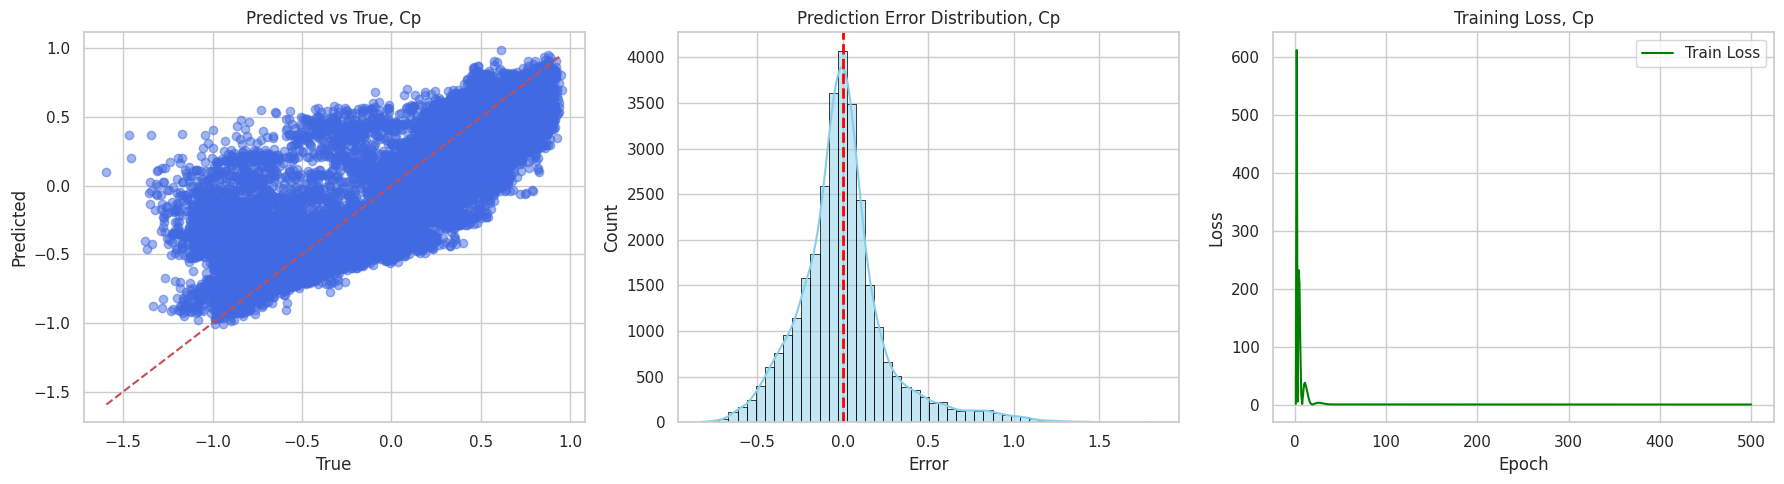

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 10/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   3%|▎         | 14/500 [00:00<00:03, 130.61it/s]

Epoch [10/500], Loss: 0.2857
Epoch [20/500], Loss: 1.9503


Epochs:   6%|▌         | 28/500 [00:00<00:03, 127.38it/s]

Epoch [30/500], Loss: 0.2283


Epochs:  11%|█         | 54/500 [00:00<00:03, 126.20it/s]

Epoch [40/500], Loss: 0.2373
Epoch [50/500], Loss: 0.2152
Epoch [60/500], Loss: 0.2137


Epochs:  16%|█▌        | 80/500 [00:00<00:03, 125.75it/s]

Epoch [70/500], Loss: 0.2087
Epoch [80/500], Loss: 0.1955


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 125.95it/s]

Epoch [90/500], Loss: 0.1822


Epochs:  21%|██        | 106/500 [00:00<00:03, 125.57it/s]

Epoch [100/500], Loss: 0.1751
Epoch [110/500], Loss: 0.1693


Epochs:  24%|██▍       | 119/500 [00:00<00:03, 125.57it/s]

Epoch [120/500], Loss: 0.1644


Epochs:  29%|██▉       | 145/500 [00:01<00:02, 125.21it/s]

Epoch [130/500], Loss: 0.1603
Epoch [140/500], Loss: 0.1566
Epoch [150/500], Loss: 0.1534


Epochs:  34%|███▍      | 171/500 [00:01<00:02, 125.47it/s]

Epoch [160/500], Loss: 0.1507
Epoch [170/500], Loss: 0.1487


Epochs:  37%|███▋      | 184/500 [00:01<00:02, 125.75it/s]

Epoch [180/500], Loss: 0.1382


Epochs:  39%|███▉      | 197/500 [00:01<00:02, 125.93it/s]

Epoch [190/500], Loss: 0.1254
Epoch [200/500], Loss: 0.1178


Epochs:  42%|████▏     | 210/500 [00:01<00:02, 126.04it/s]

Epoch [210/500], Loss: 0.1124


Epochs:  45%|████▍     | 223/500 [00:01<00:02, 125.87it/s]

Epoch [220/500], Loss: 0.1086
Epoch [230/500], Loss: 0.1073


Epochs:  47%|████▋     | 236/500 [00:01<00:02, 125.79it/s]

Epoch [240/500], Loss: 0.1061


Epochs:  52%|█████▏    | 262/500 [00:02<00:01, 125.96it/s]

Epoch [250/500], Loss: 0.1060
Epoch [260/500], Loss: 0.1044


Epochs:  55%|█████▌    | 275/500 [00:02<00:01, 125.93it/s]

Epoch [270/500], Loss: 0.1036


Epochs:  58%|█████▊    | 288/500 [00:02<00:01, 125.26it/s]

Epoch [280/500], Loss: 0.1029
Epoch [290/500], Loss: 0.1022


Epochs:  60%|██████    | 301/500 [00:02<00:01, 124.58it/s]

Epoch [300/500], Loss: 0.1025


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 124.37it/s]

Epoch [310/500], Loss: 0.1014
Epoch [320/500], Loss: 0.1030


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 124.36it/s]

Epoch [330/500], Loss: 0.1055


Epochs:  71%|███████   | 353/500 [00:02<00:01, 124.75it/s]

Epoch [340/500], Loss: 0.1009
Epoch [350/500], Loss: 0.0987
Epoch [360/500], Loss: 0.0976


Epochs:  76%|███████▌  | 379/500 [00:03<00:00, 125.03it/s]

Epoch [370/500], Loss: 0.0967
Epoch [380/500], Loss: 0.0961


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 124.42it/s]

Epoch [390/500], Loss: 0.0954


Epochs:  81%|████████  | 405/500 [00:03<00:00, 124.67it/s]

Epoch [400/500], Loss: 0.0948
Epoch [410/500], Loss: 0.1070


Epochs:  84%|████████▎ | 418/500 [00:03<00:00, 124.93it/s]

Epoch [420/500], Loss: 0.0989


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 125.19it/s]

Epoch [430/500], Loss: 0.0925
Epoch [440/500], Loss: 0.0897
Epoch [450/500], Loss: 0.0858


Epochs:  94%|█████████▍| 470/500 [00:03<00:00, 124.93it/s]

Epoch [460/500], Loss: 0.0864
Epoch [470/500], Loss: 0.0831


Epochs:  97%|█████████▋| 483/500 [00:03<00:00, 124.69it/s]

Epoch [480/500], Loss: 0.0822


Epochs: 100%|██████████| 500/500 [00:03<00:00, 125.26it/s]

Epoch [490/500], Loss: 0.0814
Epoch [500/500], Loss: 0.0797
📈 Evaluation metrics on test set:
MSE: 0.0815
MAE: 0.2025
R2: 0.6734



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


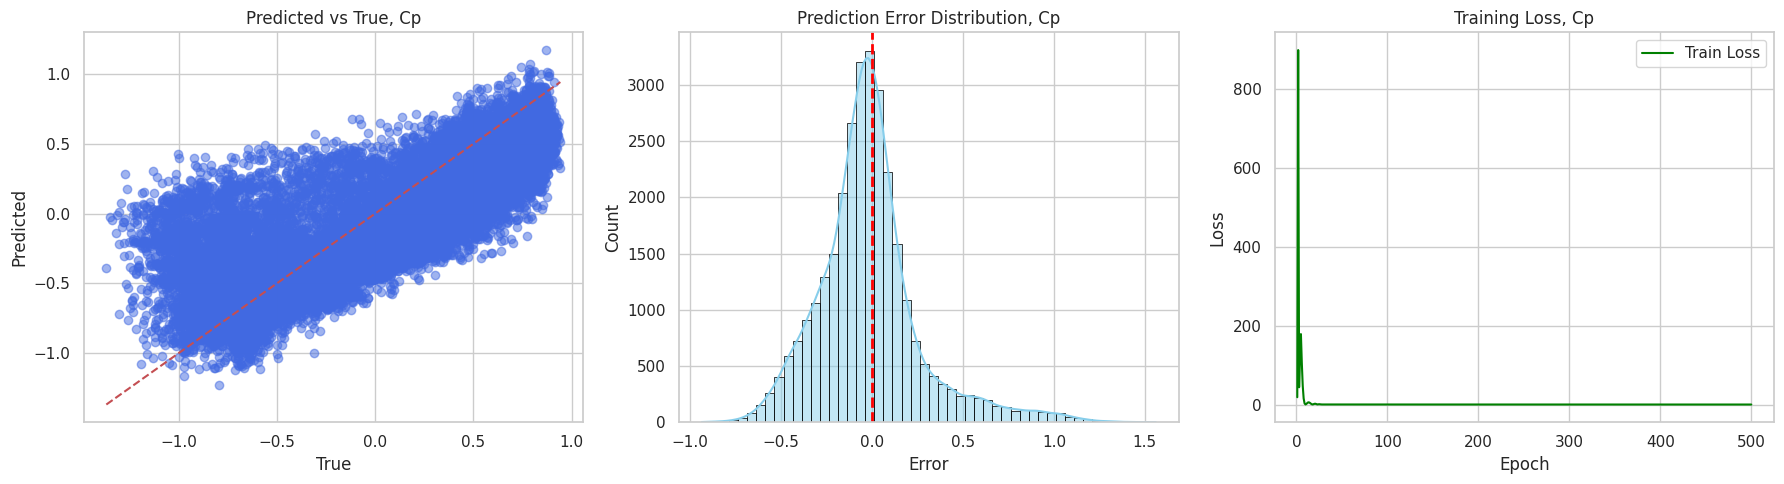

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 11/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 125.30it/s]

Epoch [10/500], Loss: 15.1271
Epoch [20/500], Loss: 2.6355
Epoch [30/500], Loss: 0.7794


Epochs:  13%|█▎        | 65/500 [00:00<00:03, 124.98it/s]

Epoch [40/500], Loss: 0.2476
Epoch [50/500], Loss: 0.2515
Epoch [60/500], Loss: 0.2206


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 124.91it/s]

Epoch [70/500], Loss: 0.2250
Epoch [80/500], Loss: 0.2118
Epoch [90/500], Loss: 0.1949


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 124.95it/s]

Epoch [100/500], Loss: 0.1836
Epoch [110/500], Loss: 0.1700
Epoch [120/500], Loss: 0.1596


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 124.38it/s]

Epoch [130/500], Loss: 0.1495
Epoch [140/500], Loss: 0.1439
Epoch [150/500], Loss: 0.2056


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 124.30it/s]

Epoch [160/500], Loss: 0.1831
Epoch [170/500], Loss: 0.1718
Epoch [180/500], Loss: 0.1604


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 124.34it/s]

Epoch [190/500], Loss: 0.1561
Epoch [200/500], Loss: 0.1526
Epoch [210/500], Loss: 0.1485


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 124.35it/s]

Epoch [220/500], Loss: 0.1445
Epoch [230/500], Loss: 0.1404
Epoch [240/500], Loss: 0.1364


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 124.01it/s]

Epoch [250/500], Loss: 0.1328
Epoch [260/500], Loss: 0.1296
Epoch [270/500], Loss: 0.1267


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 123.62it/s]

Epoch [280/500], Loss: 0.1230
Epoch [290/500], Loss: 0.1190
Epoch [300/500], Loss: 0.1158


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 123.71it/s]

Epoch [310/500], Loss: 0.1139
Epoch [320/500], Loss: 0.1121
Epoch [330/500], Loss: 0.1107


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 124.42it/s]

Epoch [340/500], Loss: 0.1095
Epoch [350/500], Loss: 0.1085
Epoch [360/500], Loss: 0.1076


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 124.48it/s]

Epoch [370/500], Loss: 0.1078
Epoch [380/500], Loss: 0.1064
Epoch [390/500], Loss: 0.1056


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 124.00it/s]

Epoch [400/500], Loss: 0.1049
Epoch [410/500], Loss: 0.1043
Epoch [420/500], Loss: 0.1038


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 123.98it/s]

Epoch [430/500], Loss: 0.1033
Epoch [440/500], Loss: 0.1027
Epoch [450/500], Loss: 0.1023


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 123.74it/s]

Epoch [460/500], Loss: 0.1017
Epoch [470/500], Loss: 0.0985
Epoch [480/500], Loss: 0.0953


Epochs: 100%|██████████| 500/500 [00:04<00:00, 124.28it/s]


Epoch [490/500], Loss: 0.0948
Epoch [500/500], Loss: 0.0905
📈 Evaluation metrics on test set:
MSE: 0.0903
MAE: 0.2118
R2: 0.6327


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


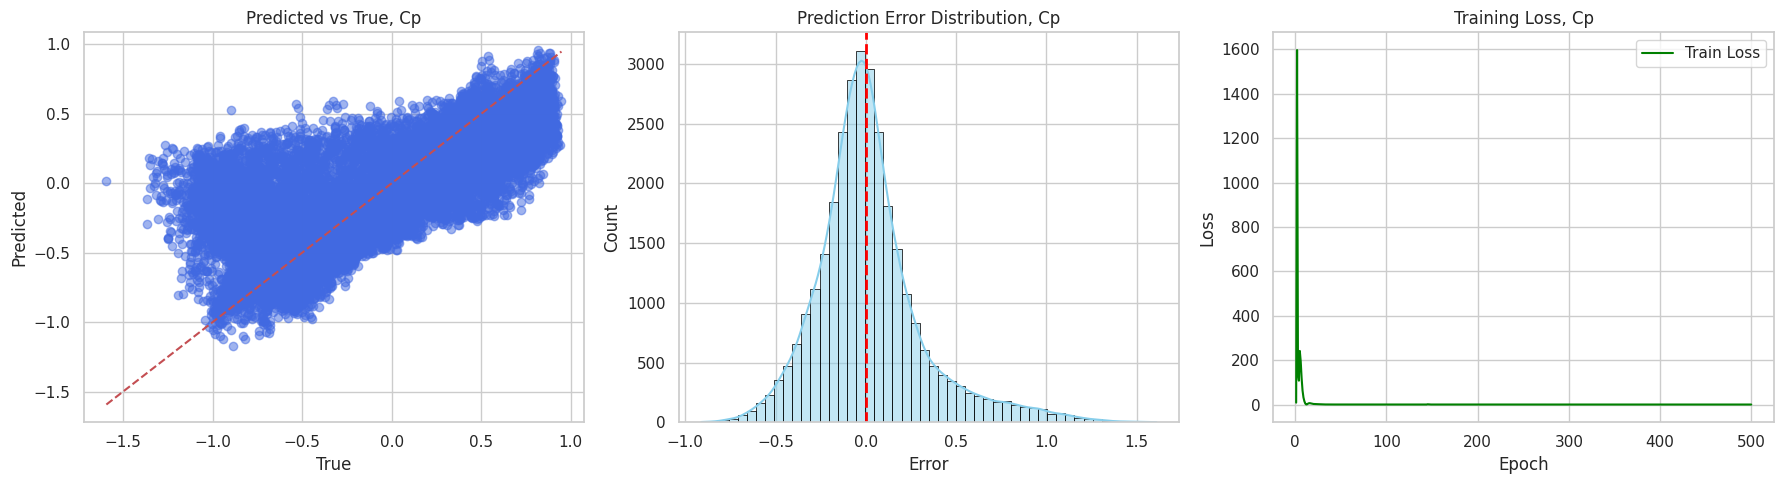

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 12/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 127.68it/s]

Epoch [10/500], Loss: 13.8332
Epoch [20/500], Loss: 2.6250


Epochs:   5%|▌         | 26/500 [00:00<00:03, 125.38it/s]

Epoch [30/500], Loss: 0.4722


Epochs:  10%|█         | 52/500 [00:00<00:03, 124.99it/s]

Epoch [40/500], Loss: 0.2772
Epoch [50/500], Loss: 0.2305


Epochs:  13%|█▎        | 65/500 [00:00<00:03, 124.49it/s]

Epoch [60/500], Loss: 0.2173


Epochs:  16%|█▌        | 78/500 [00:00<00:03, 124.74it/s]

Epoch [70/500], Loss: 0.2034
Epoch [80/500], Loss: 0.1941


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 124.40it/s]

Epoch [90/500], Loss: 0.1879


Epochs:  21%|██        | 104/500 [00:00<00:03, 124.47it/s]

Epoch [100/500], Loss: 0.1807
Epoch [110/500], Loss: 0.1710


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 124.28it/s]

Epoch [120/500], Loss: 0.1609


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 124.04it/s]

Epoch [130/500], Loss: 0.1520
Epoch [140/500], Loss: 0.1442
Epoch [150/500], Loss: 0.1389


Epochs:  34%|███▍      | 169/500 [00:01<00:02, 123.75it/s]

Epoch [160/500], Loss: 0.1335
Epoch [170/500], Loss: 0.1282


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 123.84it/s]

Epoch [180/500], Loss: 0.1233


Epochs:  39%|███▉      | 195/500 [00:01<00:02, 123.77it/s]

Epoch [190/500], Loss: 0.1193
Epoch [200/500], Loss: 0.1150


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 123.34it/s]

Epoch [210/500], Loss: 0.1099


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 123.34it/s]

Epoch [220/500], Loss: 0.1049
Epoch [230/500], Loss: 0.1001
Epoch [240/500], Loss: 0.0962


Epochs:  52%|█████▏    | 260/500 [00:02<00:01, 123.35it/s]

Epoch [250/500], Loss: 0.0928
Epoch [260/500], Loss: 0.0903


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 123.39it/s]

Epoch [270/500], Loss: 0.0877


Epochs:  57%|█████▋    | 286/500 [00:02<00:01, 123.31it/s]

Epoch [280/500], Loss: 0.0857
Epoch [290/500], Loss: 0.0843


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 123.66it/s]

Epoch [300/500], Loss: 0.0987


Epochs:  62%|██████▏   | 312/500 [00:02<00:01, 123.61it/s]

Epoch [310/500], Loss: 0.0857
Epoch [320/500], Loss: 0.0833


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 123.58it/s]

Epoch [330/500], Loss: 0.0811


Epochs:  70%|███████   | 351/500 [00:02<00:01, 123.50it/s]

Epoch [340/500], Loss: 0.0804
Epoch [350/500], Loss: 0.0797


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 123.96it/s]

Epoch [360/500], Loss: 0.0791


Epochs:  75%|███████▌  | 377/500 [00:03<00:00, 123.74it/s]

Epoch [370/500], Loss: 0.0786
Epoch [380/500], Loss: 0.0781


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 123.49it/s]

Epoch [390/500], Loss: 0.0776


Epochs:  81%|████████  | 403/500 [00:03<00:00, 123.35it/s]

Epoch [400/500], Loss: 0.0771
Epoch [410/500], Loss: 0.0766


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 123.30it/s]

Epoch [420/500], Loss: 0.0762


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 123.50it/s]

Epoch [430/500], Loss: 0.0757
Epoch [440/500], Loss: 0.0753
Epoch [450/500], Loss: 0.0748


Epochs:  94%|█████████▎| 468/500 [00:03<00:00, 123.81it/s]

Epoch [460/500], Loss: 0.0742
Epoch [470/500], Loss: 0.0735


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 123.37it/s]

Epoch [480/500], Loss: 0.0725


Epochs: 100%|██████████| 500/500 [00:04<00:00, 123.79it/s]

Epoch [490/500], Loss: 0.0713
Epoch [500/500], Loss: 0.0704
📈 Evaluation metrics on test set:
MSE: 0.0725
MAE: 0.1863
R2: 0.7067



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


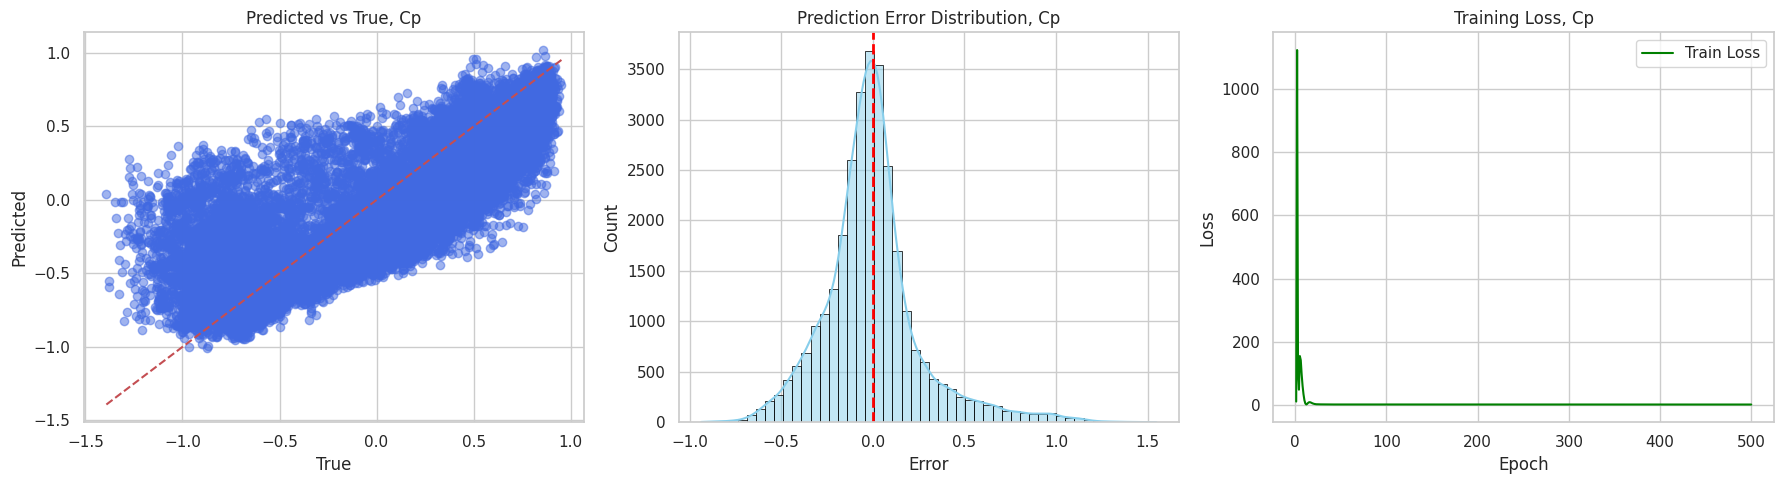

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 13/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 128.55it/s]

Epoch [10/500], Loss: 24.5059
Epoch [20/500], Loss: 24.4541


Epochs:   5%|▌         | 26/500 [00:00<00:03, 125.07it/s]

Epoch [30/500], Loss: 3.2144


Epochs:  10%|█         | 52/500 [00:00<00:03, 124.09it/s]

Epoch [40/500], Loss: 0.5894
Epoch [50/500], Loss: 0.4865
Epoch [60/500], Loss: 0.3375


Epochs:  16%|█▌        | 78/500 [00:00<00:03, 123.70it/s]

Epoch [70/500], Loss: 0.2842
Epoch [80/500], Loss: 0.2565


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 123.40it/s]

Epoch [90/500], Loss: 0.2262


Epochs:  21%|██        | 104/500 [00:00<00:03, 123.79it/s]

Epoch [100/500], Loss: 0.2122
Epoch [110/500], Loss: 0.1997


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 123.60it/s]

Epoch [120/500], Loss: 0.1873


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 123.79it/s]

Epoch [130/500], Loss: 0.1714
Epoch [140/500], Loss: 0.1459
Epoch [150/500], Loss: 0.1284


Epochs:  34%|███▍      | 169/500 [00:01<00:02, 123.49it/s]

Epoch [160/500], Loss: 0.1140
Epoch [170/500], Loss: 0.1053


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 123.45it/s]

Epoch [180/500], Loss: 0.0987


Epochs:  39%|███▉      | 195/500 [00:01<00:02, 123.40it/s]

Epoch [190/500], Loss: 0.0954
Epoch [200/500], Loss: 0.0933


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 123.69it/s]

Epoch [210/500], Loss: 0.0918


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 123.78it/s]

Epoch [220/500], Loss: 0.0907
Epoch [230/500], Loss: 0.0892
Epoch [240/500], Loss: 0.0878


Epochs:  52%|█████▏    | 260/500 [00:02<00:01, 123.45it/s]

Epoch [250/500], Loss: 0.0868
Epoch [260/500], Loss: 0.0859


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 123.65it/s]

Epoch [270/500], Loss: 0.0851


Epochs:  57%|█████▋    | 286/500 [00:02<00:01, 123.37it/s]

Epoch [280/500], Loss: 0.0844
Epoch [290/500], Loss: 0.0838


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 123.41it/s]

Epoch [300/500], Loss: 0.0831


Epochs:  62%|██████▏   | 312/500 [00:02<00:01, 123.19it/s]

Epoch [310/500], Loss: 0.0826
Epoch [320/500], Loss: 0.0821


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 122.88it/s]

Epoch [330/500], Loss: 0.0817


Epochs:  70%|███████   | 351/500 [00:02<00:01, 122.57it/s]

Epoch [340/500], Loss: 0.0808
Epoch [350/500], Loss: 0.0802


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 122.73it/s]

Epoch [360/500], Loss: 0.0794


Epochs:  75%|███████▌  | 377/500 [00:03<00:01, 122.61it/s]

Epoch [370/500], Loss: 0.0786
Epoch [380/500], Loss: 0.0787


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 122.65it/s]

Epoch [390/500], Loss: 0.0777


Epochs:  81%|████████  | 403/500 [00:03<00:00, 122.63it/s]

Epoch [400/500], Loss: 0.0765
Epoch [410/500], Loss: 0.0758


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 122.43it/s]

Epoch [420/500], Loss: 0.0751


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 122.81it/s]

Epoch [430/500], Loss: 0.0745
Epoch [440/500], Loss: 0.0738
Epoch [450/500], Loss: 0.0729


Epochs:  94%|█████████▎| 468/500 [00:03<00:00, 122.54it/s]

Epoch [460/500], Loss: 0.0726
Epoch [470/500], Loss: 0.0717


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 122.52it/s]

Epoch [480/500], Loss: 0.0710


Epochs: 100%|██████████| 500/500 [00:04<00:00, 123.21it/s]

Epoch [490/500], Loss: 0.0703
Epoch [500/500], Loss: 0.0698
📈 Evaluation metrics on test set:
MSE: 0.0688
MAE: 0.1840
R2: 0.7234



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


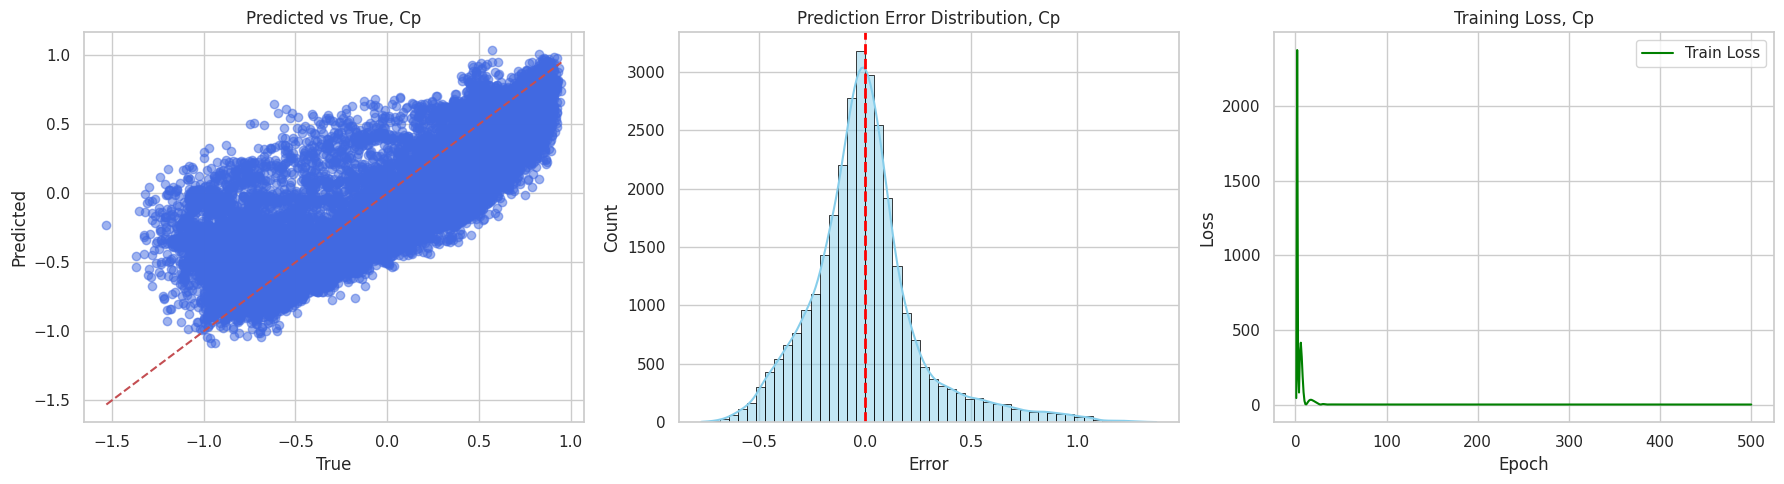

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 14/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 125.87it/s]

Epoch [10/500], Loss: 0.8819
Epoch [20/500], Loss: 3.8684


Epochs:   5%|▌         | 26/500 [00:00<00:03, 123.53it/s]

Epoch [30/500], Loss: 1.3239


Epochs:  10%|█         | 52/500 [00:00<00:03, 122.79it/s]

Epoch [40/500], Loss: 0.5474
Epoch [50/500], Loss: 0.3210
Epoch [60/500], Loss: 0.2362


Epochs:  16%|█▌        | 78/500 [00:00<00:03, 123.19it/s]

Epoch [70/500], Loss: 0.2199
Epoch [80/500], Loss: 0.2182


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 123.03it/s]

Epoch [90/500], Loss: 0.2168


Epochs:  21%|██        | 104/500 [00:00<00:03, 123.12it/s]

Epoch [100/500], Loss: 0.2143
Epoch [110/500], Loss: 0.2124


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 122.93it/s]

Epoch [120/500], Loss: 0.2111


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 122.61it/s]

Epoch [130/500], Loss: 0.2097
Epoch [140/500], Loss: 0.2083
Epoch [150/500], Loss: 0.2067


Epochs:  34%|███▍      | 169/500 [00:01<00:02, 123.10it/s]

Epoch [160/500], Loss: 0.2050
Epoch [170/500], Loss: 0.2031


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 122.97it/s]

Epoch [180/500], Loss: 0.2009


Epochs:  39%|███▉      | 195/500 [00:01<00:02, 123.04it/s]

Epoch [190/500], Loss: 0.1975
Epoch [200/500], Loss: 0.1919


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 122.99it/s]

Epoch [210/500], Loss: 0.1892


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 123.33it/s]

Epoch [220/500], Loss: 0.1859
Epoch [230/500], Loss: 0.1825
Epoch [240/500], Loss: 0.1791


Epochs:  52%|█████▏    | 260/500 [00:02<00:01, 122.70it/s]

Epoch [250/500], Loss: 0.1757
Epoch [260/500], Loss: 0.1723


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 122.35it/s]

Epoch [270/500], Loss: 0.1688


Epochs:  57%|█████▋    | 286/500 [00:02<00:01, 122.53it/s]

Epoch [280/500], Loss: 0.1653
Epoch [290/500], Loss: 0.1620


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 122.37it/s]

Epoch [300/500], Loss: 0.1587


Epochs:  62%|██████▏   | 312/500 [00:02<00:01, 122.19it/s]

Epoch [310/500], Loss: 0.1553
Epoch [320/500], Loss: 0.1547


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 122.53it/s]

Epoch [330/500], Loss: 0.1501


Epochs:  70%|███████   | 351/500 [00:02<00:01, 122.32it/s]

Epoch [340/500], Loss: 0.1662
Epoch [350/500], Loss: 0.1513


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 122.81it/s]

Epoch [360/500], Loss: 0.1473


Epochs:  75%|███████▌  | 377/500 [00:03<00:01, 122.69it/s]

Epoch [370/500], Loss: 0.1425
Epoch [380/500], Loss: 0.1383


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 122.63it/s]

Epoch [390/500], Loss: 0.1270


Epochs:  81%|████████  | 403/500 [00:03<00:00, 122.67it/s]

Epoch [400/500], Loss: 0.1221
Epoch [410/500], Loss: 0.1186


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 123.34it/s]

Epoch [420/500], Loss: 0.1160


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 123.26it/s]

Epoch [430/500], Loss: 0.1141
Epoch [440/500], Loss: 0.1124
Epoch [450/500], Loss: 0.1109


Epochs:  94%|█████████▎| 468/500 [00:03<00:00, 122.64it/s]

Epoch [460/500], Loss: 0.1095
Epoch [470/500], Loss: 0.1085


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 122.56it/s]

Epoch [480/500], Loss: 0.1053


Epochs: 100%|██████████| 500/500 [00:04<00:00, 122.78it/s]

Epoch [490/500], Loss: 0.1002
Epoch [500/500], Loss: 0.0939
📈 Evaluation metrics on test set:
MSE: 0.0946
MAE: 0.2261
R2: 0.6229



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


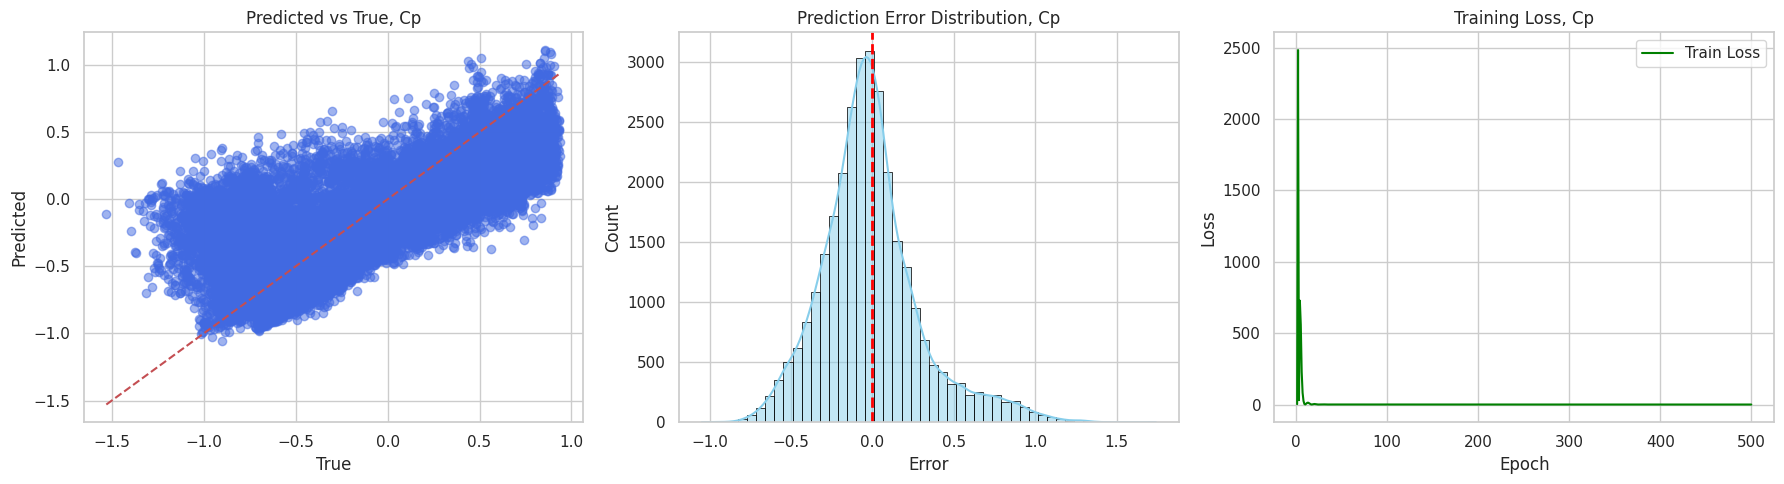

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 15/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 121.13it/s]

Epoch [10/500], Loss: 23.2302
Epoch [20/500], Loss: 3.8558
Epoch [30/500], Loss: 0.2780


Epochs:  13%|█▎        | 65/500 [00:00<00:03, 122.78it/s]

Epoch [40/500], Loss: 0.2590
Epoch [50/500], Loss: 0.2372
Epoch [60/500], Loss: 0.2130


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 122.60it/s]

Epoch [70/500], Loss: 0.2021
Epoch [80/500], Loss: 0.1958
Epoch [90/500], Loss: 0.1921


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 122.65it/s]

Epoch [100/500], Loss: 0.1891
Epoch [110/500], Loss: 0.1870
Epoch [120/500], Loss: 0.1849


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 122.38it/s]

Epoch [130/500], Loss: 0.1870
Epoch [140/500], Loss: 0.2025
Epoch [150/500], Loss: 0.1872


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 122.94it/s]

Epoch [160/500], Loss: 0.1657
Epoch [170/500], Loss: 0.2023
Epoch [180/500], Loss: 0.2038


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 122.66it/s]

Epoch [190/500], Loss: 0.1845
Epoch [200/500], Loss: 0.1735
Epoch [210/500], Loss: 0.1670


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 122.40it/s]

Epoch [220/500], Loss: 0.1597
Epoch [230/500], Loss: 0.1495
Epoch [240/500], Loss: 0.1401


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 122.27it/s]

Epoch [250/500], Loss: 0.1312
Epoch [260/500], Loss: 0.1215
Epoch [270/500], Loss: 0.1133


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 122.16it/s]

Epoch [280/500], Loss: 0.1053
Epoch [290/500], Loss: 0.1014
Epoch [300/500], Loss: 0.0994


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 122.54it/s]

Epoch [310/500], Loss: 0.0976
Epoch [320/500], Loss: 0.0963
Epoch [330/500], Loss: 0.0951


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 122.15it/s]

Epoch [340/500], Loss: 0.0941
Epoch [350/500], Loss: 0.0930
Epoch [360/500], Loss: 0.0920


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 122.11it/s]

Epoch [370/500], Loss: 0.0911
Epoch [380/500], Loss: 0.0901
Epoch [390/500], Loss: 0.0889


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 121.99it/s]

Epoch [400/500], Loss: 0.0880
Epoch [410/500], Loss: 0.0871
Epoch [420/500], Loss: 0.0863


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 121.79it/s]

Epoch [430/500], Loss: 0.0856
Epoch [440/500], Loss: 0.0849
Epoch [450/500], Loss: 0.0843


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 122.08it/s]

Epoch [460/500], Loss: 0.0848
Epoch [470/500], Loss: 0.0833
Epoch [480/500], Loss: 0.0828


Epochs: 100%|██████████| 500/500 [00:04<00:00, 122.25it/s]


Epoch [490/500], Loss: 0.0824
Epoch [500/500], Loss: 0.0819
📈 Evaluation metrics on test set:
MSE: 0.0817
MAE: 0.2052
R2: 0.6659


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


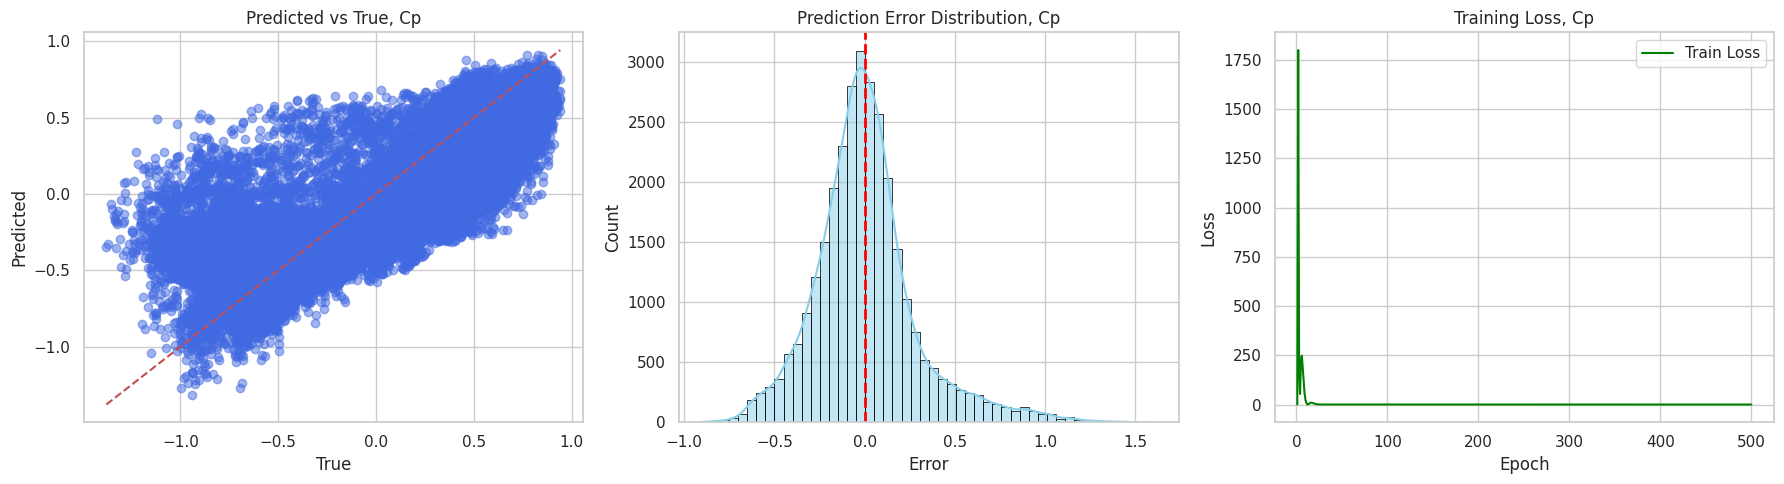

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 16/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   4%|▍         | 20/500 [00:00<00:05, 93.37it/s]

Epoch [10/500], Loss: 13.1476
Epoch [20/500], Loss: 6.3233
Epoch [30/500], Loss: 1.4313


Epochs:  12%|█▏        | 59/500 [00:00<00:03, 115.48it/s]

Epoch [40/500], Loss: 0.3155
Epoch [50/500], Loss: 0.2641
Epoch [60/500], Loss: 0.2555


Epochs:  17%|█▋        | 85/500 [00:00<00:03, 118.66it/s]

Epoch [70/500], Loss: 0.2483
Epoch [80/500], Loss: 0.2403
Epoch [90/500], Loss: 0.2334


Epochs:  25%|██▍       | 124/500 [00:01<00:03, 120.76it/s]

Epoch [100/500], Loss: 0.2274
Epoch [110/500], Loss: 0.2213
Epoch [120/500], Loss: 0.2148


Epochs:  30%|███       | 150/500 [00:01<00:02, 120.56it/s]

Epoch [130/500], Loss: 0.2085
Epoch [140/500], Loss: 0.1966
Epoch [150/500], Loss: 0.1769


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 120.64it/s]

Epoch [160/500], Loss: 0.1437
Epoch [170/500], Loss: 0.1250
Epoch [180/500], Loss: 0.1102


Epochs:  40%|████      | 202/500 [00:01<00:02, 120.76it/s]

Epoch [190/500], Loss: 0.1020
Epoch [200/500], Loss: 0.0978
Epoch [210/500], Loss: 0.0946


Epochs:  48%|████▊     | 241/500 [00:02<00:02, 120.82it/s]

Epoch [220/500], Loss: 0.0921
Epoch [230/500], Loss: 0.0900
Epoch [240/500], Loss: 0.0881


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 120.72it/s]

Epoch [250/500], Loss: 0.0864
Epoch [260/500], Loss: 0.0846
Epoch [270/500], Loss: 0.0838


Epochs:  59%|█████▊    | 293/500 [00:02<00:01, 120.37it/s]

Epoch [280/500], Loss: 0.0820
Epoch [290/500], Loss: 0.0808
Epoch [300/500], Loss: 0.0799


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 120.60it/s]

Epoch [310/500], Loss: 0.0797
Epoch [320/500], Loss: 0.0784
Epoch [330/500], Loss: 0.0776


Epochs:  72%|███████▏  | 358/500 [00:03<00:01, 120.69it/s]

Epoch [340/500], Loss: 0.0769
Epoch [350/500], Loss: 0.0761
Epoch [360/500], Loss: 0.0758


Epochs:  77%|███████▋  | 384/500 [00:03<00:00, 120.47it/s]

Epoch [370/500], Loss: 0.0750
Epoch [380/500], Loss: 0.0754
Epoch [390/500], Loss: 0.0745


Epochs:  85%|████████▍ | 423/500 [00:03<00:00, 120.45it/s]

Epoch [400/500], Loss: 0.0736
Epoch [410/500], Loss: 0.0732
Epoch [420/500], Loss: 0.0727


Epochs:  90%|████████▉ | 449/500 [00:03<00:00, 120.37it/s]

Epoch [430/500], Loss: 0.0733
Epoch [440/500], Loss: 0.0722
Epoch [450/500], Loss: 0.0714


Epochs:  95%|█████████▌| 475/500 [00:03<00:00, 120.51it/s]

Epoch [460/500], Loss: 0.0710
Epoch [470/500], Loss: 0.0706
Epoch [480/500], Loss: 0.0702


Epochs: 100%|██████████| 500/500 [00:04<00:00, 119.27it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0704
Epoch [500/500], Loss: 0.0699
📈 Evaluation metrics on test set:
MSE: 0.0690
MAE: 0.1860
R2: 0.7197


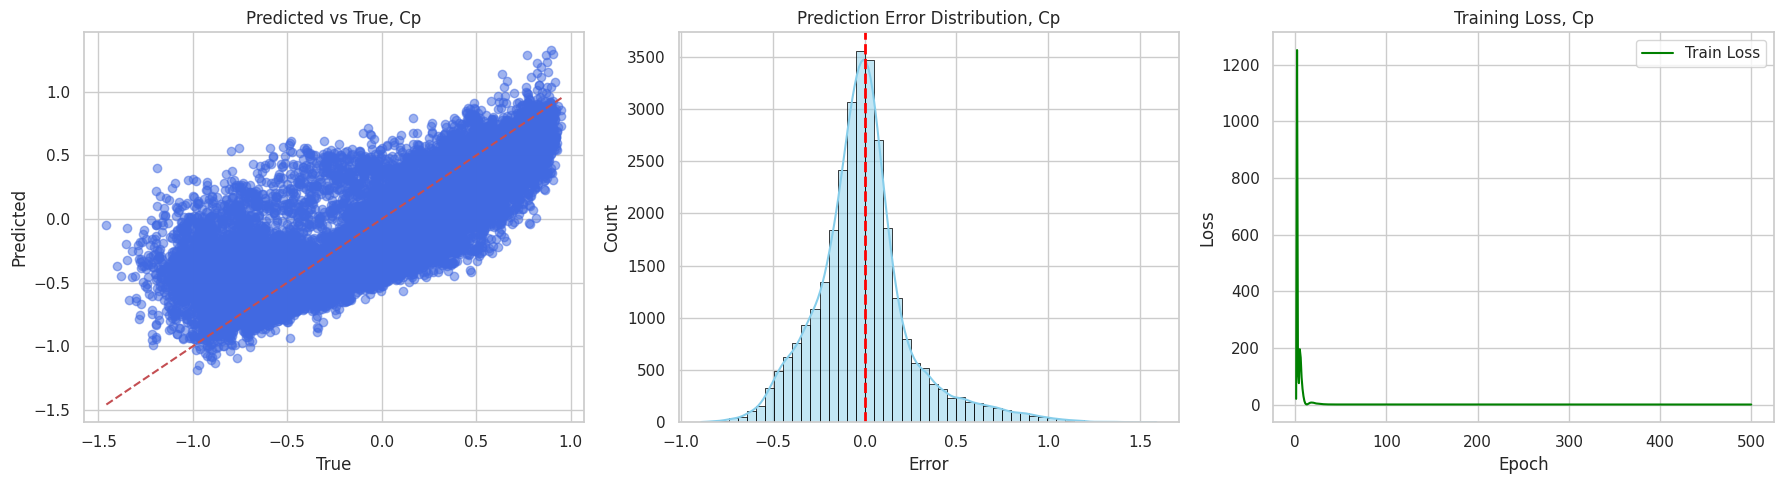

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 17/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 124.83it/s]

Epoch [10/500], Loss: 6.4038
Epoch [20/500], Loss: 7.3635


Epochs:   5%|▌         | 26/500 [00:00<00:03, 121.24it/s]

Epoch [30/500], Loss: 0.3088


Epochs:  10%|█         | 52/500 [00:00<00:03, 120.51it/s]

Epoch [40/500], Loss: 0.5815
Epoch [50/500], Loss: 0.2522
Epoch [60/500], Loss: 0.2468


Epochs:  16%|█▌        | 78/500 [00:00<00:03, 120.53it/s]

Epoch [70/500], Loss: 0.2237
Epoch [80/500], Loss: 0.2155


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 120.40it/s]

Epoch [90/500], Loss: 0.2113


Epochs:  21%|██        | 104/500 [00:00<00:03, 120.01it/s]

Epoch [100/500], Loss: 0.2092
Epoch [110/500], Loss: 0.2076


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 120.39it/s]

Epoch [120/500], Loss: 0.1986


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 120.21it/s]

Epoch [130/500], Loss: 0.1715
Epoch [140/500], Loss: 0.1510
Epoch [150/500], Loss: 0.1493


Epochs:  34%|███▍      | 169/500 [00:01<00:02, 119.76it/s]

Epoch [160/500], Loss: 0.1343
Epoch [170/500], Loss: 0.1249


Epochs:  36%|███▌      | 181/500 [00:01<00:02, 119.69it/s]

Epoch [180/500], Loss: 0.1176


Epochs:  39%|███▊      | 193/500 [00:01<00:02, 119.38it/s]

Epoch [190/500], Loss: 0.1102
Epoch [200/500], Loss: 0.1057


Epochs:  41%|████      | 206/500 [00:01<00:02, 119.90it/s]

Epoch [210/500], Loss: 0.1025


Epochs:  46%|████▋     | 232/500 [00:01<00:02, 120.03it/s]

Epoch [220/500], Loss: 0.1016
Epoch [230/500], Loss: 0.0987
Epoch [240/500], Loss: 0.0966


Epochs:  51%|█████▏    | 257/500 [00:02<00:02, 119.22it/s]

Epoch [250/500], Loss: 0.0939
Epoch [260/500], Loss: 0.0945


Epochs:  54%|█████▍    | 269/500 [00:02<00:01, 119.27it/s]

Epoch [270/500], Loss: 0.0907


Epochs:  59%|█████▊    | 293/500 [00:02<00:01, 119.26it/s]

Epoch [280/500], Loss: 0.0890
Epoch [290/500], Loss: 0.0877
Epoch [300/500], Loss: 0.0880


Epochs:  63%|██████▎   | 317/500 [00:02<00:01, 119.10it/s]

Epoch [310/500], Loss: 0.0870
Epoch [320/500], Loss: 0.0847


Epochs:  66%|██████▌   | 329/500 [00:02<00:01, 119.37it/s]

Epoch [330/500], Loss: 0.0840


Epochs:  71%|███████   | 353/500 [00:02<00:01, 119.13it/s]

Epoch [340/500], Loss: 0.0827
Epoch [350/500], Loss: 0.0824
Epoch [360/500], Loss: 0.0847


Epochs:  76%|███████▌  | 378/500 [00:03<00:01, 119.49it/s]

Epoch [370/500], Loss: 0.0824
Epoch [380/500], Loss: 0.0810


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 119.61it/s]

Epoch [390/500], Loss: 0.0797


Epochs:  80%|████████  | 402/500 [00:03<00:00, 119.32it/s]

Epoch [400/500], Loss: 0.0792
Epoch [410/500], Loss: 0.0785


Epochs:  83%|████████▎ | 414/500 [00:03<00:00, 119.35it/s]

Epoch [420/500], Loss: 0.0780


Epochs:  88%|████████▊ | 438/500 [00:03<00:00, 119.35it/s]

Epoch [430/500], Loss: 0.0782
Epoch [440/500], Loss: 0.0783


Epochs:  90%|█████████ | 450/500 [00:03<00:00, 119.52it/s]

Epoch [450/500], Loss: 0.0779


Epochs:  95%|█████████▍| 474/500 [00:03<00:00, 119.70it/s]

Epoch [460/500], Loss: 0.0770
Epoch [470/500], Loss: 0.0763
Epoch [480/500], Loss: 0.0762


Epochs: 100%|██████████| 500/500 [00:04<00:00, 119.71it/s]

Epoch [490/500], Loss: 0.0762
Epoch [500/500], Loss: 0.0754
📈 Evaluation metrics on test set:
MSE: 0.0777
MAE: 0.1985
R2: 0.6841



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


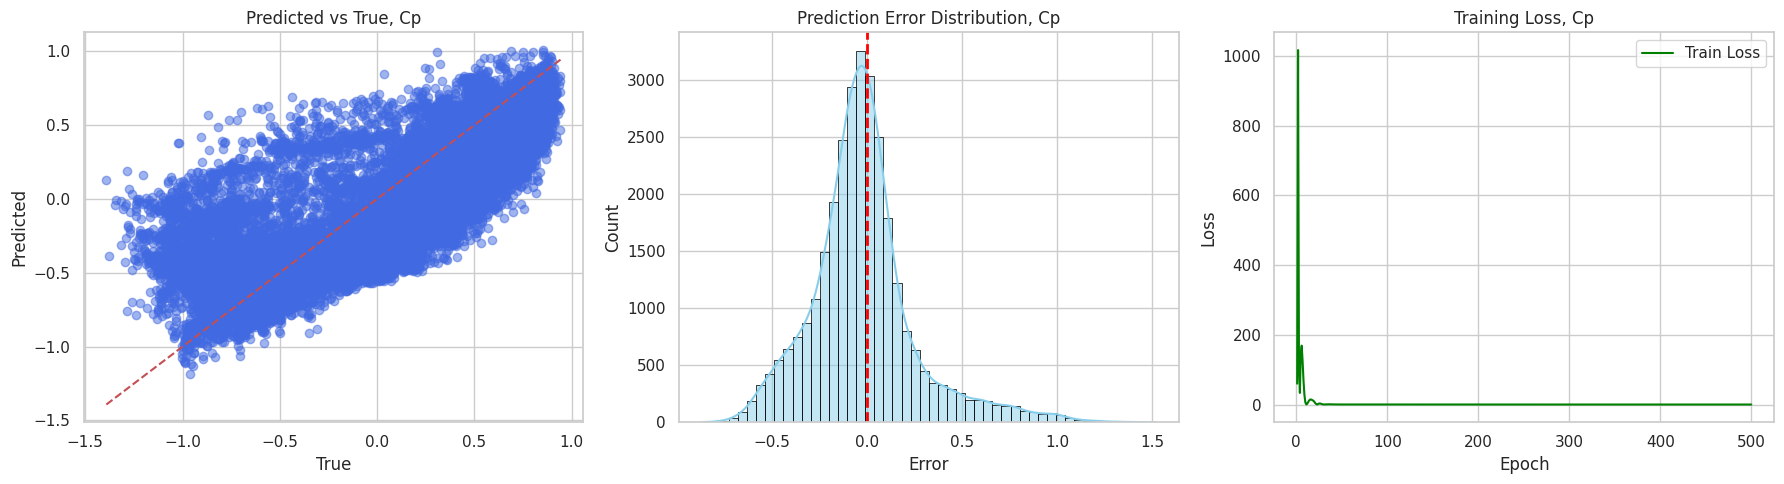

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 18/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.07it/s]

Epoch [10/500], Loss: 0.5861


Epochs:   4%|▍         | 21/500 [00:00<00:04, 99.74it/s]

Epoch [20/500], Loss: 0.3518
Epoch [30/500], Loss: 0.6277


Epochs:   7%|▋         | 33/500 [00:00<00:04, 104.64it/s]

Epoch [40/500], Loss: 0.2475


Epochs:  12%|█▏        | 59/500 [00:00<00:03, 114.29it/s]

Epoch [50/500], Loss: 0.2402
Epoch [60/500], Loss: 0.2227


Epochs:  14%|█▍        | 72/500 [00:00<00:03, 116.34it/s]

Epoch [70/500], Loss: 0.2065


Epochs:  17%|█▋        | 85/500 [00:00<00:03, 117.55it/s]

Epoch [80/500], Loss: 0.1975
Epoch [90/500], Loss: 0.1914


Epochs:  19%|█▉        | 97/500 [00:00<00:03, 118.19it/s]

Epoch [100/500], Loss: 0.1863


Epochs:  24%|██▍       | 121/500 [00:01<00:03, 118.79it/s]

Epoch [110/500], Loss: 0.1921
Epoch [120/500], Loss: 0.1857


Epochs:  27%|██▋       | 133/500 [00:01<00:03, 118.79it/s]

Epoch [130/500], Loss: 0.2048


Epochs:  29%|██▉       | 145/500 [00:01<00:02, 119.02it/s]

Epoch [140/500], Loss: 0.1833
Epoch [150/500], Loss: 0.1637


Epochs:  31%|███▏      | 157/500 [00:01<00:02, 119.17it/s]

Epoch [160/500], Loss: 0.1483


Epochs:  36%|███▌      | 181/500 [00:01<00:02, 119.07it/s]

Epoch [170/500], Loss: 0.1394
Epoch [180/500], Loss: 0.1316


Epochs:  39%|███▊      | 193/500 [00:01<00:02, 118.95it/s]

Epoch [190/500], Loss: 0.1249


Epochs:  41%|████      | 205/500 [00:01<00:02, 118.96it/s]

Epoch [200/500], Loss: 0.1190
Epoch [210/500], Loss: 0.1157


Epochs:  43%|████▎     | 217/500 [00:01<00:02, 118.88it/s]

Epoch [220/500], Loss: 0.1128


Epochs:  48%|████▊     | 241/500 [00:02<00:02, 118.69it/s]

Epoch [230/500], Loss: 0.1106
Epoch [240/500], Loss: 0.1091


Epochs:  51%|█████     | 253/500 [00:02<00:02, 118.87it/s]

Epoch [250/500], Loss: 0.1076


Epochs:  53%|█████▎    | 265/500 [00:02<00:01, 119.10it/s]

Epoch [260/500], Loss: 0.1060
Epoch [270/500], Loss: 0.1029


Epochs:  55%|█████▌    | 277/500 [00:02<00:01, 119.20it/s]

Epoch [280/500], Loss: 0.0981


Epochs:  60%|██████    | 301/500 [00:02<00:01, 119.25it/s]

Epoch [290/500], Loss: 0.0939
Epoch [300/500], Loss: 0.0908


Epochs:  63%|██████▎   | 313/500 [00:02<00:01, 119.12it/s]

Epoch [310/500], Loss: 0.0884


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 119.13it/s]

Epoch [320/500], Loss: 0.0860
Epoch [330/500], Loss: 0.0859


Epochs:  67%|██████▋   | 337/500 [00:02<00:01, 119.06it/s]

Epoch [340/500], Loss: 0.0831


Epochs:  72%|███████▏  | 361/500 [00:03<00:01, 118.87it/s]

Epoch [350/500], Loss: 0.0821
Epoch [360/500], Loss: 0.0811


Epochs:  75%|███████▍  | 373/500 [00:03<00:01, 119.10it/s]

Epoch [370/500], Loss: 0.0802


Epochs:  77%|███████▋  | 385/500 [00:03<00:00, 119.08it/s]

Epoch [380/500], Loss: 0.0824
Epoch [390/500], Loss: 0.0799


Epochs:  79%|███████▉  | 397/500 [00:03<00:00, 119.05it/s]

Epoch [400/500], Loss: 0.0778


Epochs:  84%|████████▍ | 421/500 [00:03<00:00, 118.94it/s]

Epoch [410/500], Loss: 0.0772
Epoch [420/500], Loss: 0.0766


Epochs:  87%|████████▋ | 433/500 [00:03<00:00, 118.93it/s]

Epoch [430/500], Loss: 0.0761


Epochs:  89%|████████▉ | 445/500 [00:03<00:00, 118.71it/s]

Epoch [440/500], Loss: 0.0756
Epoch [450/500], Loss: 0.0751


Epochs:  91%|█████████▏| 457/500 [00:03<00:00, 119.09it/s]

Epoch [460/500], Loss: 0.0744


Epochs:  96%|█████████▌| 481/500 [00:04<00:00, 118.88it/s]

Epoch [470/500], Loss: 0.0763
Epoch [480/500], Loss: 0.0739


Epochs:  99%|█████████▊| 493/500 [00:04<00:00, 118.68it/s]

Epoch [490/500], Loss: 0.0731


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.88it/s]


Epoch [500/500], Loss: 0.0718
📈 Evaluation metrics on test set:
MSE: 0.0739
MAE: 0.1871
R2: 0.7010


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


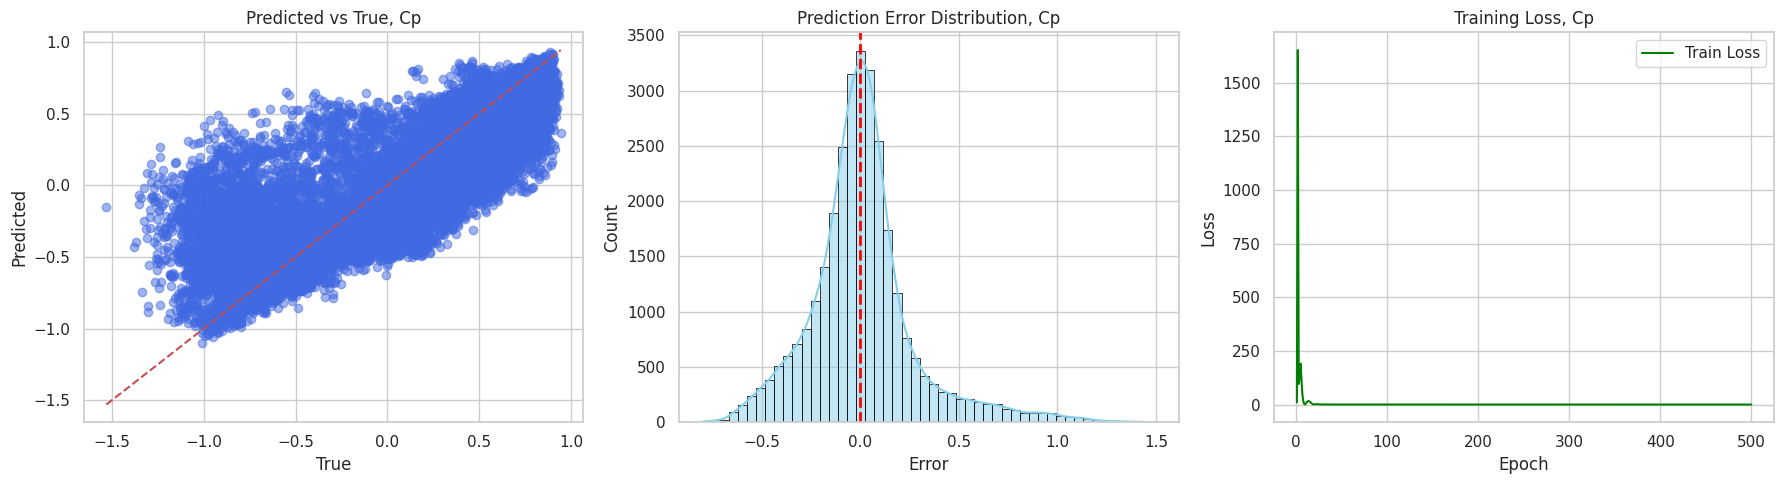

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 19/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.86it/s]

Epoch [10/500], Loss: 2.7066


Epochs:   4%|▍         | 20/500 [00:00<00:05, 90.82it/s]

Epoch [20/500], Loss: 0.3063


Epochs:   6%|▌         | 31/500 [00:00<00:04, 96.86it/s]

Epoch [30/500], Loss: 0.7261
Epoch [40/500], Loss: 0.2870


Epochs:   9%|▊         | 43/500 [00:00<00:04, 105.39it/s]

Epoch [50/500], Loss: 0.2358


Epochs:  13%|█▎        | 67/500 [00:00<00:03, 113.32it/s]

Epoch [60/500], Loss: 0.2266
Epoch [70/500], Loss: 0.2195


Epochs:  16%|█▌        | 79/500 [00:00<00:03, 115.43it/s]

Epoch [80/500], Loss: 0.2135


Epochs:  21%|██        | 103/500 [00:00<00:03, 117.34it/s]

Epoch [90/500], Loss: 0.2092
Epoch [100/500], Loss: 0.2003
Epoch [110/500], Loss: 0.1850


Epochs:  25%|██▌       | 127/500 [00:01<00:03, 117.91it/s]

Epoch [120/500], Loss: 0.1667
Epoch [130/500], Loss: 0.1499


Epochs:  28%|██▊       | 139/500 [00:01<00:03, 118.16it/s]

Epoch [140/500], Loss: 0.1376


Epochs:  33%|███▎      | 163/500 [00:01<00:02, 118.50it/s]

Epoch [150/500], Loss: 0.1260
Epoch [160/500], Loss: 0.1166
Epoch [170/500], Loss: 0.1099


Epochs:  37%|███▋      | 187/500 [00:01<00:02, 118.64it/s]

Epoch [180/500], Loss: 0.1051
Epoch [190/500], Loss: 0.1024


Epochs:  40%|███▉      | 199/500 [00:01<00:02, 118.82it/s]

Epoch [200/500], Loss: 0.0991


Epochs:  45%|████▍     | 223/500 [00:01<00:02, 118.76it/s]

Epoch [210/500], Loss: 0.0961
Epoch [220/500], Loss: 0.0938
Epoch [230/500], Loss: 0.0919


Epochs:  49%|████▉     | 247/500 [00:02<00:02, 118.42it/s]

Epoch [240/500], Loss: 0.0902
Epoch [250/500], Loss: 0.0885


Epochs:  52%|█████▏    | 259/500 [00:02<00:02, 118.41it/s]

Epoch [260/500], Loss: 0.0867


Epochs:  57%|█████▋    | 283/500 [00:02<00:01, 118.14it/s]

Epoch [270/500], Loss: 0.0848
Epoch [280/500], Loss: 0.0828
Epoch [290/500], Loss: 0.0812


Epochs:  61%|██████▏   | 307/500 [00:02<00:01, 118.18it/s]

Epoch [300/500], Loss: 0.0800
Epoch [310/500], Loss: 0.0792


Epochs:  64%|██████▍   | 319/500 [00:02<00:01, 118.22it/s]

Epoch [320/500], Loss: 0.0781


Epochs:  69%|██████▊   | 343/500 [00:02<00:01, 117.93it/s]

Epoch [330/500], Loss: 0.0774
Epoch [340/500], Loss: 0.0767
Epoch [350/500], Loss: 0.0761


Epochs:  73%|███████▎  | 367/500 [00:03<00:01, 117.88it/s]

Epoch [360/500], Loss: 0.0755
Epoch [370/500], Loss: 0.0745


Epochs:  76%|███████▌  | 379/500 [00:03<00:01, 118.00it/s]

Epoch [380/500], Loss: 0.0758


Epochs:  81%|████████  | 403/500 [00:03<00:00, 117.83it/s]

Epoch [390/500], Loss: 0.0756
Epoch [400/500], Loss: 0.0741
Epoch [410/500], Loss: 0.0729


Epochs:  85%|████████▌ | 427/500 [00:03<00:00, 117.83it/s]

Epoch [420/500], Loss: 0.0718
Epoch [430/500], Loss: 0.0710


Epochs:  88%|████████▊ | 439/500 [00:03<00:00, 118.17it/s]

Epoch [440/500], Loss: 0.0702


Epochs:  93%|█████████▎| 463/500 [00:03<00:00, 117.56it/s]

Epoch [450/500], Loss: 0.0694
Epoch [460/500], Loss: 0.0684
Epoch [470/500], Loss: 0.0675


Epochs:  97%|█████████▋| 487/500 [00:04<00:00, 117.88it/s]

Epoch [480/500], Loss: 0.0666
Epoch [490/500], Loss: 0.0666


Epochs: 100%|██████████| 500/500 [00:04<00:00, 116.54it/s]

Epoch [500/500], Loss: 0.0664
📈 Evaluation metrics on test set:
MSE: 0.0677
MAE: 0.1852
R2: 0.7287



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


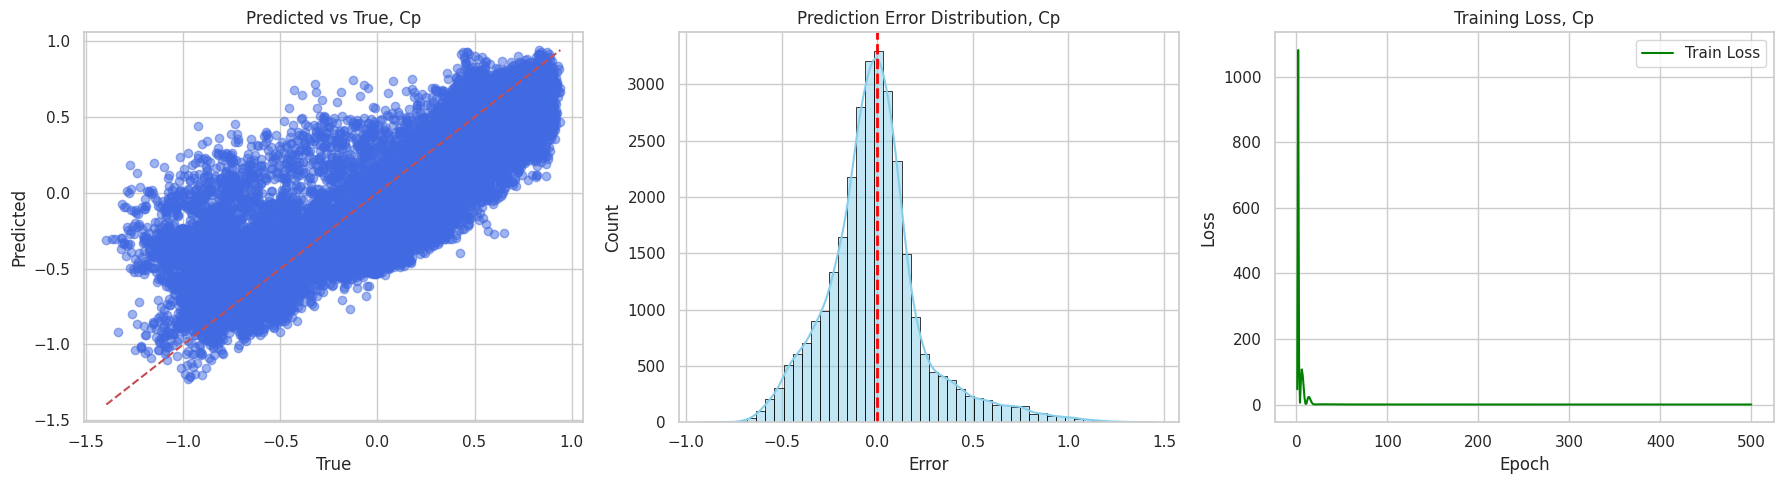

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 20/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 93.81it/s]

Epoch [10/500], Loss: 10.3597


Epochs:   4%|▍         | 20/500 [00:00<00:05, 92.92it/s]

Epoch [20/500], Loss: 2.6439
Epoch [30/500], Loss: 0.2769


Epochs:   6%|▋         | 32/500 [00:00<00:04, 103.51it/s]

Epoch [40/500], Loss: 0.2247


Epochs:  11%|█         | 56/500 [00:00<00:03, 112.51it/s]

Epoch [50/500], Loss: 0.2462
Epoch [60/500], Loss: 0.2338


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 114.36it/s]

Epoch [70/500], Loss: 0.2293


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 116.43it/s]

Epoch [80/500], Loss: 0.2235
Epoch [90/500], Loss: 0.2164
Epoch [100/500], Loss: 0.2109


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 117.60it/s]

Epoch [110/500], Loss: 0.2070
Epoch [120/500], Loss: 0.2012


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 117.76it/s]

Epoch [130/500], Loss: 0.1930


Epochs:  30%|███       | 152/500 [00:01<00:02, 117.68it/s]

Epoch [140/500], Loss: 0.1796
Epoch [150/500], Loss: 0.1605
Epoch [160/500], Loss: 0.1451


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 117.64it/s]

Epoch [170/500], Loss: 0.1392
Epoch [180/500], Loss: 0.1339


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 117.61it/s]

Epoch [190/500], Loss: 0.1299


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 117.76it/s]

Epoch [200/500], Loss: 0.1265
Epoch [210/500], Loss: 0.1230
Epoch [220/500], Loss: 0.1198


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 117.63it/s]

Epoch [230/500], Loss: 0.1169
Epoch [240/500], Loss: 0.1142


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 117.56it/s]

Epoch [250/500], Loss: 0.1123


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 117.85it/s]

Epoch [260/500], Loss: 0.1102
Epoch [270/500], Loss: 0.1073
Epoch [280/500], Loss: 0.1050


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 117.49it/s]

Epoch [290/500], Loss: 0.1027
Epoch [300/500], Loss: 0.1088


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 117.45it/s]

Epoch [310/500], Loss: 0.0988


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 117.25it/s]

Epoch [320/500], Loss: 0.0965
Epoch [330/500], Loss: 0.0942
Epoch [340/500], Loss: 0.0974


Epochs:  71%|███████   | 356/500 [00:03<00:01, 117.11it/s]

Epoch [350/500], Loss: 0.0919
Epoch [360/500], Loss: 0.0883


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 117.12it/s]

Epoch [370/500], Loss: 0.0887


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 117.04it/s]

Epoch [380/500], Loss: 0.0873
Epoch [390/500], Loss: 0.0906
Epoch [400/500], Loss: 0.0897


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 117.47it/s]

Epoch [410/500], Loss: 0.0887
Epoch [420/500], Loss: 0.0846


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 117.09it/s]

Epoch [430/500], Loss: 0.0820


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 117.14it/s]

Epoch [440/500], Loss: 0.0840
Epoch [450/500], Loss: 0.0883
Epoch [460/500], Loss: 0.0861


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 116.73it/s]

Epoch [470/500], Loss: 0.0830
Epoch [480/500], Loss: 0.0799


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 116.94it/s]

Epoch [490/500], Loss: 0.0940


Epochs: 100%|██████████| 500/500 [00:04<00:00, 116.23it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0797
📈 Evaluation metrics on test set:
MSE: 0.0818
MAE: 0.2096
R2: 0.6711


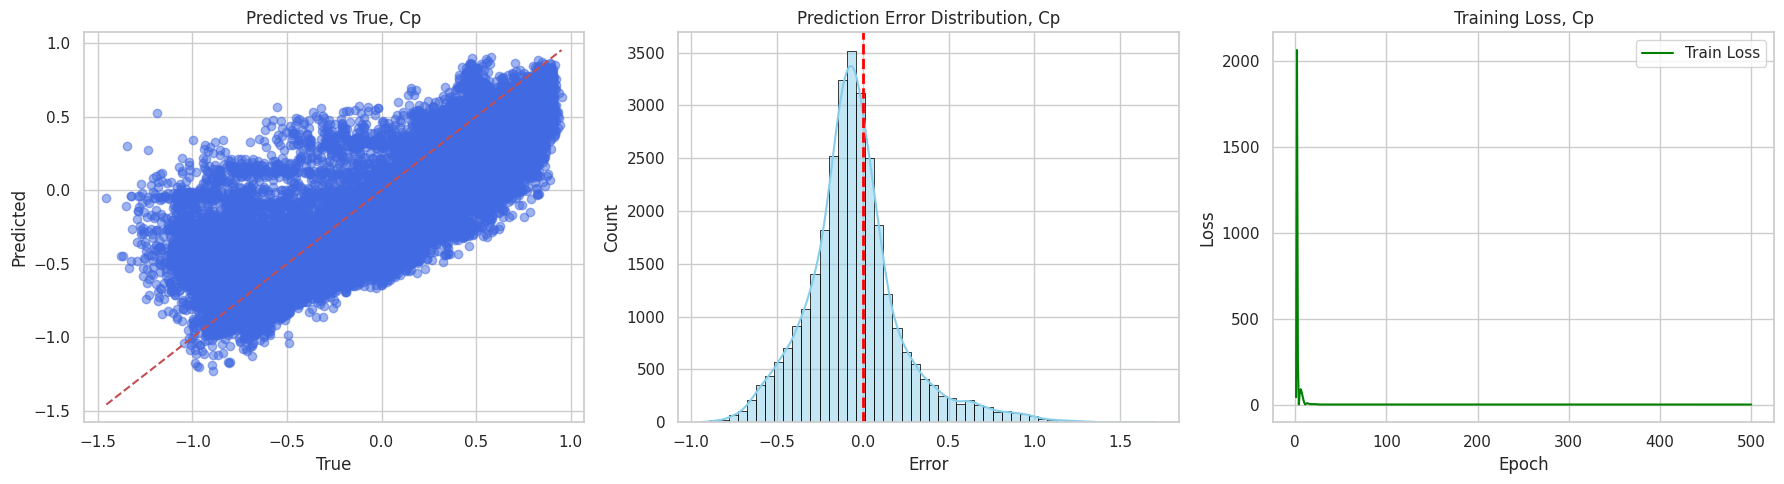

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 21/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.95it/s]

Epoch [10/500], Loss: 24.3585


Epochs:   4%|▍         | 20/500 [00:00<00:05, 94.78it/s]

Epoch [20/500], Loss: 0.4651


Epochs:   6%|▌         | 30/500 [00:00<00:04, 96.90it/s]

Epoch [30/500], Loss: 0.2653
Epoch [40/500], Loss: 0.2387


Epochs:   8%|▊         | 42/500 [00:00<00:04, 104.50it/s]

Epoch [50/500], Loss: 0.2281


Epochs:  13%|█▎        | 66/500 [00:00<00:03, 112.09it/s]

Epoch [60/500], Loss: 0.2235
Epoch [70/500], Loss: 0.2198


Epochs:  16%|█▌        | 78/500 [00:00<00:03, 114.00it/s]

Epoch [80/500], Loss: 0.2159


Epochs:  20%|██        | 102/500 [00:00<00:03, 115.73it/s]

Epoch [90/500], Loss: 0.2108
Epoch [100/500], Loss: 0.1986
Epoch [110/500], Loss: 0.1749


Epochs:  25%|██▌       | 126/500 [00:01<00:03, 115.96it/s]

Epoch [120/500], Loss: 0.1437
Epoch [130/500], Loss: 0.1280


Epochs:  28%|██▊       | 138/500 [00:01<00:03, 116.10it/s]

Epoch [140/500], Loss: 0.1205


Epochs:  32%|███▏      | 162/500 [00:01<00:02, 116.27it/s]

Epoch [150/500], Loss: 0.1158
Epoch [160/500], Loss: 0.1117
Epoch [170/500], Loss: 0.1128


Epochs:  37%|███▋      | 186/500 [00:01<00:02, 116.09it/s]

Epoch [180/500], Loss: 0.1080
Epoch [190/500], Loss: 0.1051


Epochs:  40%|███▉      | 198/500 [00:01<00:02, 116.22it/s]

Epoch [200/500], Loss: 0.1043


Epochs:  44%|████▍     | 222/500 [00:01<00:02, 116.63it/s]

Epoch [210/500], Loss: 0.1028
Epoch [220/500], Loss: 0.1013
Epoch [230/500], Loss: 0.0975


Epochs:  49%|████▉     | 246/500 [00:02<00:02, 116.17it/s]

Epoch [240/500], Loss: 0.0969
Epoch [250/500], Loss: 0.0993


Epochs:  52%|█████▏    | 258/500 [00:02<00:02, 116.00it/s]

Epoch [260/500], Loss: 0.0936


Epochs:  56%|█████▋    | 282/500 [00:02<00:01, 116.14it/s]

Epoch [270/500], Loss: 0.0921
Epoch [280/500], Loss: 0.0910
Epoch [290/500], Loss: 0.1034


Epochs:  61%|██████    | 306/500 [00:02<00:01, 116.36it/s]

Epoch [300/500], Loss: 0.0933
Epoch [310/500], Loss: 0.0885


Epochs:  64%|██████▎   | 318/500 [00:02<00:01, 116.64it/s]

Epoch [320/500], Loss: 0.0853


Epochs:  68%|██████▊   | 342/500 [00:02<00:01, 116.59it/s]

Epoch [330/500], Loss: 0.0964
Epoch [340/500], Loss: 0.0857
Epoch [350/500], Loss: 0.0845


Epochs:  73%|███████▎  | 366/500 [00:03<00:01, 116.36it/s]

Epoch [360/500], Loss: 0.0843
Epoch [370/500], Loss: 0.0804


Epochs:  76%|███████▌  | 378/500 [00:03<00:01, 116.28it/s]

Epoch [380/500], Loss: 0.0800


Epochs:  80%|████████  | 402/500 [00:03<00:00, 115.95it/s]

Epoch [390/500], Loss: 0.0935
Epoch [400/500], Loss: 0.0815
Epoch [410/500], Loss: 0.0787


Epochs:  85%|████████▌ | 426/500 [00:03<00:00, 115.70it/s]

Epoch [420/500], Loss: 0.0774
Epoch [430/500], Loss: 0.0805


Epochs:  88%|████████▊ | 438/500 [00:03<00:00, 115.89it/s]

Epoch [440/500], Loss: 0.0784


Epochs:  92%|█████████▏| 462/500 [00:04<00:00, 115.76it/s]

Epoch [450/500], Loss: 0.0783
Epoch [460/500], Loss: 0.0748
Epoch [470/500], Loss: 0.0763


Epochs:  97%|█████████▋| 486/500 [00:04<00:00, 115.48it/s]

Epoch [480/500], Loss: 0.0825
Epoch [490/500], Loss: 0.0771


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.75it/s]

Epoch [500/500], Loss: 0.0735
📈 Evaluation metrics on test set:
MSE: 0.0731
MAE: 0.1907
R2: 0.7061



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


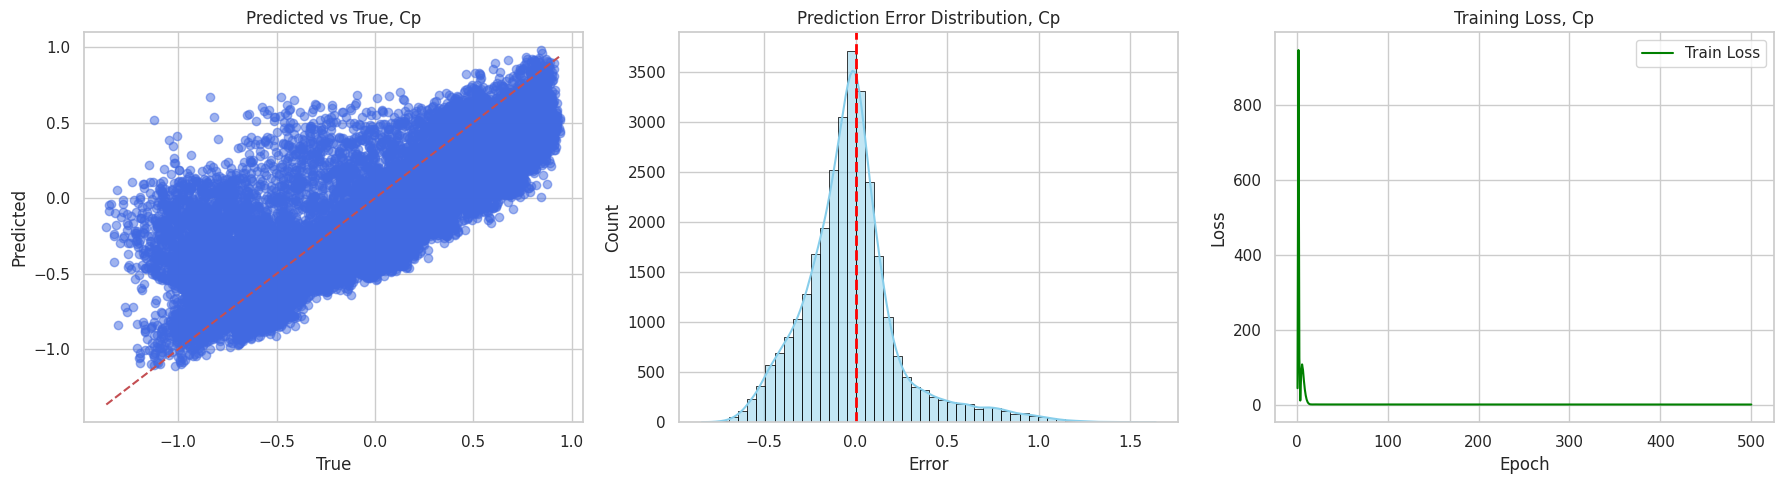

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 22/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.94it/s]

Epoch [10/500], Loss: 2.0906


Epochs:   4%|▍         | 20/500 [00:00<00:05, 94.49it/s]

Epoch [20/500], Loss: 0.2800
Epoch [30/500], Loss: 0.7163


Epochs:   6%|▋         | 32/500 [00:00<00:04, 104.32it/s]

Epoch [40/500], Loss: 0.2206


Epochs:  11%|█         | 56/500 [00:00<00:03, 111.46it/s]

Epoch [50/500], Loss: 0.2644
Epoch [60/500], Loss: 0.2137


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 112.87it/s]

Epoch [70/500], Loss: 0.2074


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 114.81it/s]

Epoch [80/500], Loss: 0.2015
Epoch [90/500], Loss: 0.1929
Epoch [100/500], Loss: 0.1828


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 115.57it/s]

Epoch [110/500], Loss: 0.1515
Epoch [120/500], Loss: 0.1401


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 115.99it/s]

Epoch [130/500], Loss: 0.1325


Epochs:  30%|███       | 152/500 [00:01<00:02, 116.14it/s]

Epoch [140/500], Loss: 0.1271
Epoch [150/500], Loss: 0.1229
Epoch [160/500], Loss: 0.1185


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 115.83it/s]

Epoch [170/500], Loss: 0.1133
Epoch [180/500], Loss: 0.1068


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 115.91it/s]

Epoch [190/500], Loss: 0.1005


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 116.04it/s]

Epoch [200/500], Loss: 0.0961
Epoch [210/500], Loss: 0.0934
Epoch [220/500], Loss: 0.0906


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 116.08it/s]

Epoch [230/500], Loss: 0.0881
Epoch [240/500], Loss: 0.0864


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 115.66it/s]

Epoch [250/500], Loss: 0.0845


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 116.04it/s]

Epoch [260/500], Loss: 0.0826
Epoch [270/500], Loss: 0.0812
Epoch [280/500], Loss: 0.0843


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 116.01it/s]

Epoch [290/500], Loss: 0.0792
Epoch [300/500], Loss: 0.0787


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 115.89it/s]

Epoch [310/500], Loss: 0.0773


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 115.74it/s]

Epoch [320/500], Loss: 0.0765
Epoch [330/500], Loss: 0.0757
Epoch [340/500], Loss: 0.0751


Epochs:  71%|███████   | 356/500 [00:03<00:01, 115.58it/s]

Epoch [350/500], Loss: 0.0745
Epoch [360/500], Loss: 0.0739


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 115.52it/s]

Epoch [370/500], Loss: 0.0733


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 115.54it/s]

Epoch [380/500], Loss: 0.0728
Epoch [390/500], Loss: 0.0723
Epoch [400/500], Loss: 0.0724


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 114.92it/s]

Epoch [410/500], Loss: 0.0717
Epoch [420/500], Loss: 0.0714


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 115.01it/s]

Epoch [430/500], Loss: 0.0706


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 115.21it/s]

Epoch [440/500], Loss: 0.0719
Epoch [450/500], Loss: 0.0713
Epoch [460/500], Loss: 0.0710


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 115.57it/s]

Epoch [470/500], Loss: 0.0702
Epoch [480/500], Loss: 0.0694


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 115.73it/s]

Epoch [490/500], Loss: 0.0688


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.72it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0702
📈 Evaluation metrics on test set:
MSE: 0.0717
MAE: 0.1831
R2: 0.7130


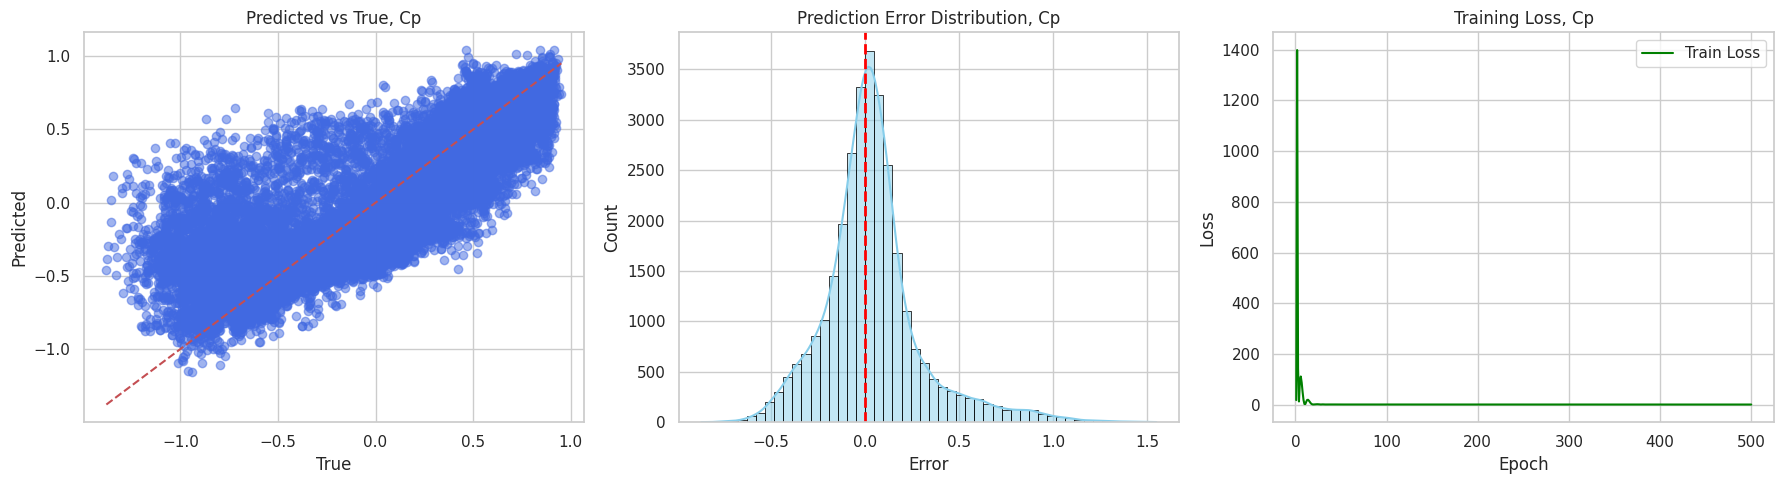

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 23/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:04, 119.68it/s]

Epoch [10/500], Loss: 1.3337
Epoch [20/500], Loss: 0.2764


Epochs:   5%|▌         | 25/500 [00:00<00:04, 115.08it/s]

Epoch [30/500], Loss: 0.5311


Epochs:  10%|▉         | 49/500 [00:00<00:03, 114.34it/s]

Epoch [40/500], Loss: 0.3062
Epoch [50/500], Loss: 0.3273


Epochs:  12%|█▏        | 61/500 [00:00<00:03, 114.36it/s]

Epoch [60/500], Loss: 0.2427


Epochs:  15%|█▍        | 73/500 [00:00<00:03, 113.93it/s]

Epoch [70/500], Loss: 0.2103
Epoch [80/500], Loss: 0.1960


Epochs:  17%|█▋        | 85/500 [00:00<00:03, 114.20it/s]

Epoch [90/500], Loss: 0.1918


Epochs:  22%|██▏       | 109/500 [00:00<00:03, 113.31it/s]

Epoch [100/500], Loss: 0.1889
Epoch [110/500], Loss: 0.1862


Epochs:  24%|██▍       | 121/500 [00:01<00:03, 113.27it/s]

Epoch [120/500], Loss: 0.1833


Epochs:  27%|██▋       | 133/500 [00:01<00:03, 113.15it/s]

Epoch [130/500], Loss: 0.1626
Epoch [140/500], Loss: 0.1429


Epochs:  29%|██▉       | 145/500 [00:01<00:03, 112.98it/s]

Epoch [150/500], Loss: 0.1316


Epochs:  34%|███▍      | 169/500 [00:01<00:02, 113.74it/s]

Epoch [160/500], Loss: 0.1251
Epoch [170/500], Loss: 0.1201


Epochs:  36%|███▌      | 181/500 [00:01<00:02, 113.46it/s]

Epoch [180/500], Loss: 0.1163


Epochs:  39%|███▊      | 193/500 [00:01<00:02, 113.03it/s]

Epoch [190/500], Loss: 0.1132
Epoch [200/500], Loss: 0.1105


Epochs:  41%|████      | 205/500 [00:01<00:02, 113.42it/s]

Epoch [210/500], Loss: 0.1080


Epochs:  46%|████▌     | 229/500 [00:02<00:02, 113.91it/s]

Epoch [220/500], Loss: 0.1051
Epoch [230/500], Loss: 0.1010


Epochs:  48%|████▊     | 241/500 [00:02<00:02, 114.00it/s]

Epoch [240/500], Loss: 0.0972


Epochs:  51%|█████     | 253/500 [00:02<00:02, 114.13it/s]

Epoch [250/500], Loss: 0.0942
Epoch [260/500], Loss: 0.0918


Epochs:  53%|█████▎    | 265/500 [00:02<00:02, 114.38it/s]

Epoch [270/500], Loss: 0.0898


Epochs:  58%|█████▊    | 289/500 [00:02<00:01, 114.03it/s]

Epoch [280/500], Loss: 0.0881
Epoch [290/500], Loss: 0.0866


Epochs:  60%|██████    | 301/500 [00:02<00:01, 113.49it/s]

Epoch [300/500], Loss: 0.0855


Epochs:  63%|██████▎   | 313/500 [00:02<00:01, 113.64it/s]

Epoch [310/500], Loss: 0.0843
Epoch [320/500], Loss: 0.0838


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 113.74it/s]

Epoch [330/500], Loss: 0.0823


Epochs:  70%|██████▉   | 349/500 [00:03<00:01, 114.20it/s]

Epoch [340/500], Loss: 0.0816
Epoch [350/500], Loss: 0.0808


Epochs:  72%|███████▏  | 361/500 [00:03<00:01, 113.91it/s]

Epoch [360/500], Loss: 0.0801


Epochs:  75%|███████▍  | 373/500 [00:03<00:01, 113.81it/s]

Epoch [370/500], Loss: 0.0795
Epoch [380/500], Loss: 0.0789


Epochs:  77%|███████▋  | 385/500 [00:03<00:01, 113.54it/s]

Epoch [390/500], Loss: 0.0785


Epochs:  82%|████████▏ | 409/500 [00:03<00:00, 112.97it/s]

Epoch [400/500], Loss: 0.0780
Epoch [410/500], Loss: 0.0774


Epochs:  84%|████████▍ | 421/500 [00:03<00:00, 113.05it/s]

Epoch [420/500], Loss: 0.0768


Epochs:  87%|████████▋ | 433/500 [00:03<00:00, 113.10it/s]

Epoch [430/500], Loss: 0.0763
Epoch [440/500], Loss: 0.0760


Epochs:  89%|████████▉ | 445/500 [00:03<00:00, 113.43it/s]

Epoch [450/500], Loss: 0.0759


Epochs:  94%|█████████▍| 469/500 [00:04<00:00, 113.43it/s]

Epoch [460/500], Loss: 0.0751
Epoch [470/500], Loss: 0.0748


Epochs:  96%|█████████▌| 481/500 [00:04<00:00, 113.03it/s]

Epoch [480/500], Loss: 0.0744


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.66it/s]

Epoch [490/500], Loss: 0.0740
Epoch [500/500], Loss: 0.0736
📈 Evaluation metrics on test set:
MSE: 0.0738
MAE: 0.1890
R2: 0.7007



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


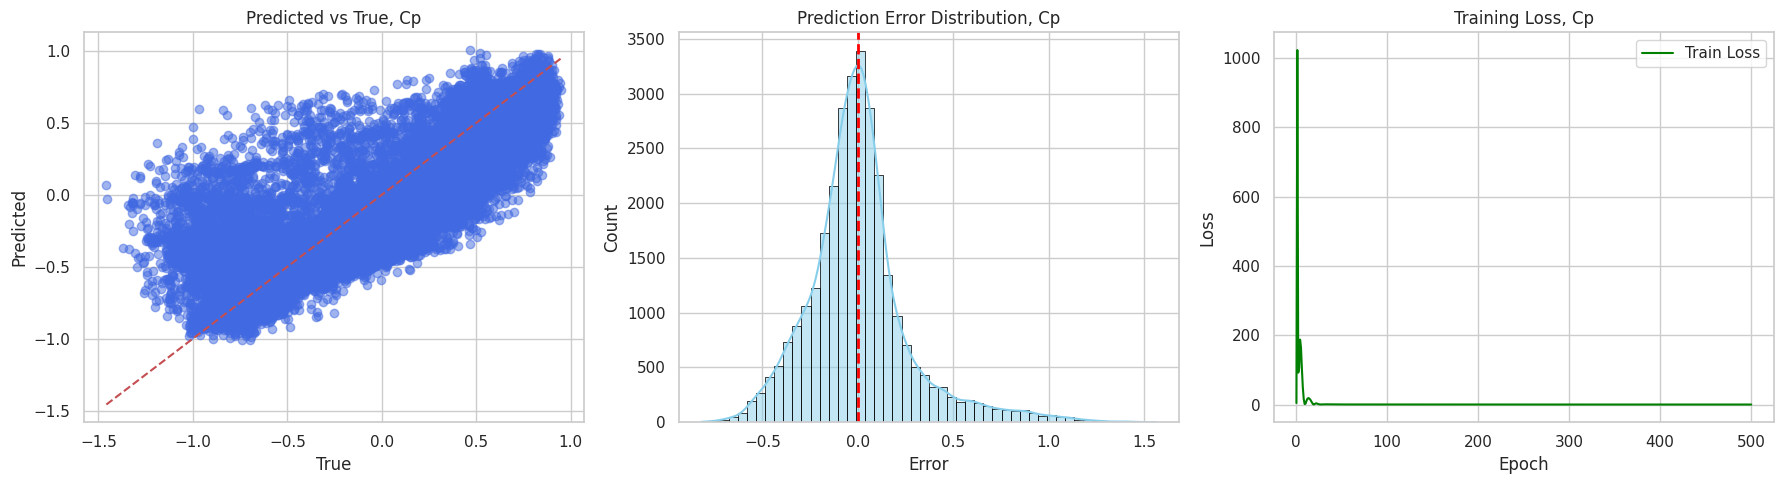

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 24/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.21it/s]

Epoch [10/500], Loss: 10.2797


Epochs:   4%|▍         | 21/500 [00:00<00:04, 98.22it/s]

Epoch [20/500], Loss: 1.1626
Epoch [30/500], Loss: 0.7769


Epochs:   6%|▋         | 32/500 [00:00<00:04, 101.06it/s]

Epoch [40/500], Loss: 0.3151


Epochs:  11%|█         | 56/500 [00:00<00:04, 108.80it/s]

Epoch [50/500], Loss: 0.2717
Epoch [60/500], Loss: 0.2226


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 110.56it/s]

Epoch [70/500], Loss: 0.2108


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 111.75it/s]

Epoch [80/500], Loss: 0.2008
Epoch [90/500], Loss: 0.1638
Epoch [100/500], Loss: 0.1411


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 112.06it/s]

Epoch [110/500], Loss: 0.1302
Epoch [120/500], Loss: 0.1224


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 112.10it/s]

Epoch [130/500], Loss: 0.1966


Epochs:  30%|███       | 152/500 [00:01<00:03, 112.50it/s]

Epoch [140/500], Loss: 0.1554
Epoch [150/500], Loss: 0.1289
Epoch [160/500], Loss: 0.1175


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 112.46it/s]

Epoch [170/500], Loss: 0.1126
Epoch [180/500], Loss: 0.1099


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 112.46it/s]

Epoch [190/500], Loss: 0.1075


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 112.53it/s]

Epoch [200/500], Loss: 0.1053
Epoch [210/500], Loss: 0.1034
Epoch [220/500], Loss: 0.1017


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 113.01it/s]

Epoch [230/500], Loss: 0.1001
Epoch [240/500], Loss: 0.0986


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 112.78it/s]

Epoch [250/500], Loss: 0.0973


Epochs:  54%|█████▍    | 272/500 [00:02<00:02, 112.67it/s]

Epoch [260/500], Loss: 0.0960
Epoch [270/500], Loss: 0.0947
Epoch [280/500], Loss: 0.0935


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 112.41it/s]

Epoch [290/500], Loss: 0.0923
Epoch [300/500], Loss: 0.0911


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 112.65it/s]

Epoch [310/500], Loss: 0.0900


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 112.44it/s]

Epoch [320/500], Loss: 0.0889
Epoch [330/500], Loss: 0.0879
Epoch [340/500], Loss: 0.0873


Epochs:  71%|███████   | 356/500 [00:03<00:01, 112.62it/s]

Epoch [350/500], Loss: 0.0869
Epoch [360/500], Loss: 0.0857


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 112.45it/s]

Epoch [370/500], Loss: 0.0849


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 112.11it/s]

Epoch [380/500], Loss: 0.0842
Epoch [390/500], Loss: 0.0845
Epoch [400/500], Loss: 0.0814


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 112.69it/s]

Epoch [410/500], Loss: 0.0806
Epoch [420/500], Loss: 0.0795


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 112.25it/s]

Epoch [430/500], Loss: 0.0790


Epochs:  90%|█████████ | 452/500 [00:04<00:00, 112.07it/s]

Epoch [440/500], Loss: 0.0777
Epoch [450/500], Loss: 0.0777
Epoch [460/500], Loss: 0.0763


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 112.29it/s]

Epoch [470/500], Loss: 0.0766
Epoch [480/500], Loss: 0.0788


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 112.45it/s]

Epoch [490/500], Loss: 0.2371


Epochs: 100%|██████████| 500/500 [00:04<00:00, 111.61it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.1072
📈 Evaluation metrics on test set:
MSE: 0.1312
MAE: 0.2843
R2: 0.4748


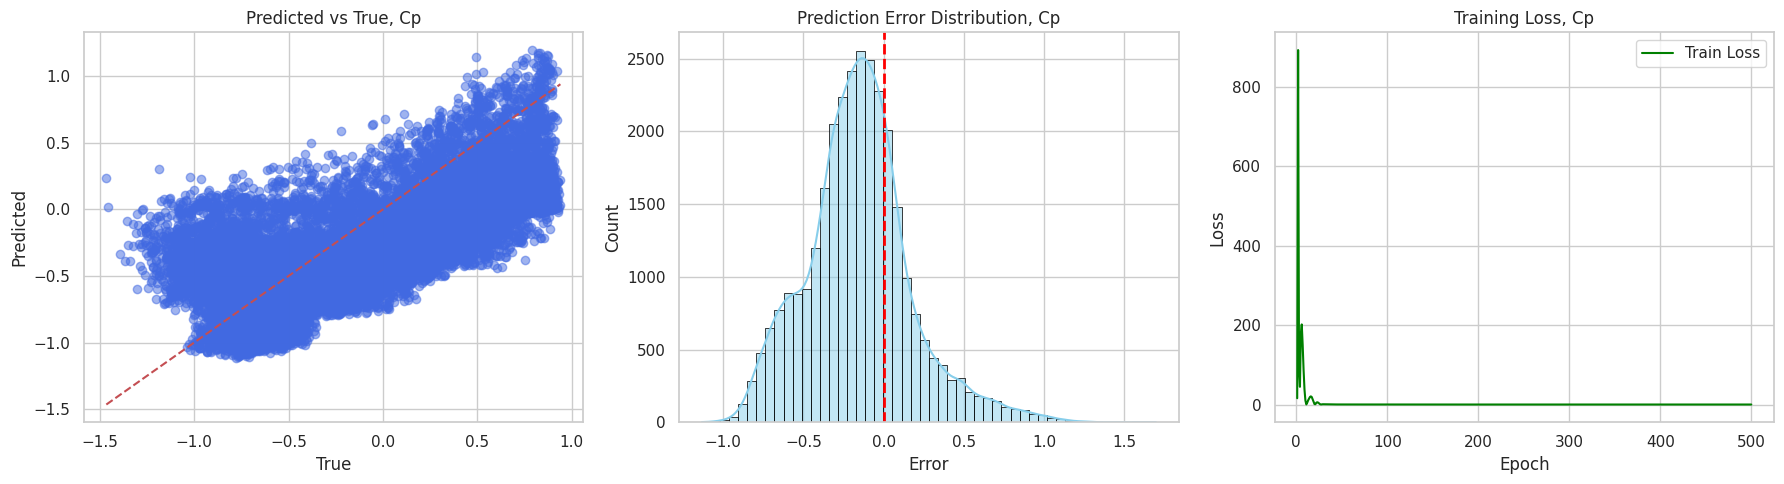

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 25/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 12/500 [00:00<00:04, 112.64it/s]

Epoch [10/500], Loss: 0.5155
Epoch [20/500], Loss: 1.7302


Epochs:   5%|▍         | 24/500 [00:00<00:04, 107.66it/s]

Epoch [30/500], Loss: 0.4401


Epochs:  10%|▉         | 48/500 [00:00<00:04, 110.93it/s]

Epoch [40/500], Loss: 0.2918
Epoch [50/500], Loss: 0.2247


Epochs:  12%|█▏        | 60/500 [00:00<00:03, 112.18it/s]

Epoch [60/500], Loss: 0.2143


Epochs:  14%|█▍        | 72/500 [00:00<00:03, 112.52it/s]

Epoch [70/500], Loss: 0.2187
Epoch [80/500], Loss: 0.2020


Epochs:  17%|█▋        | 84/500 [00:00<00:03, 112.93it/s]

Epoch [90/500], Loss: 0.1945


Epochs:  22%|██▏       | 108/500 [00:00<00:03, 112.89it/s]

Epoch [100/500], Loss: 0.1789
Epoch [110/500], Loss: 0.1632


Epochs:  24%|██▍       | 120/500 [00:01<00:03, 112.76it/s]

Epoch [120/500], Loss: 0.1426


Epochs:  26%|██▋       | 132/500 [00:01<00:03, 113.08it/s]

Epoch [130/500], Loss: 0.1373
Epoch [140/500], Loss: 0.1331


Epochs:  29%|██▉       | 144/500 [00:01<00:03, 112.77it/s]

Epoch [150/500], Loss: 0.1285


Epochs:  34%|███▎      | 168/500 [00:01<00:02, 112.87it/s]

Epoch [160/500], Loss: 0.1246
Epoch [170/500], Loss: 0.1210


Epochs:  36%|███▌      | 180/500 [00:01<00:02, 112.62it/s]

Epoch [180/500], Loss: 0.1175


Epochs:  38%|███▊      | 192/500 [00:01<00:02, 112.90it/s]

Epoch [190/500], Loss: 0.1144
Epoch [200/500], Loss: 0.1120


Epochs:  41%|████      | 204/500 [00:01<00:02, 112.43it/s]

Epoch [210/500], Loss: 0.1098


Epochs:  46%|████▌     | 228/500 [00:02<00:02, 112.70it/s]

Epoch [220/500], Loss: 0.1079
Epoch [230/500], Loss: 0.1060


Epochs:  48%|████▊     | 240/500 [00:02<00:02, 112.92it/s]

Epoch [240/500], Loss: 0.1042


Epochs:  50%|█████     | 252/500 [00:02<00:02, 113.00it/s]

Epoch [250/500], Loss: 0.1023
Epoch [260/500], Loss: 0.1005


Epochs:  53%|█████▎    | 264/500 [00:02<00:02, 112.61it/s]

Epoch [270/500], Loss: 0.0990


Epochs:  58%|█████▊    | 288/500 [00:02<00:01, 112.85it/s]

Epoch [280/500], Loss: 0.0975
Epoch [290/500], Loss: 0.0962


Epochs:  60%|██████    | 300/500 [00:02<00:01, 112.45it/s]

Epoch [300/500], Loss: 0.0950


Epochs:  62%|██████▏   | 312/500 [00:02<00:01, 112.75it/s]

Epoch [310/500], Loss: 0.0964
Epoch [320/500], Loss: 0.0889


Epochs:  65%|██████▍   | 324/500 [00:02<00:01, 112.62it/s]

Epoch [330/500], Loss: 0.0859


Epochs:  70%|██████▉   | 348/500 [00:03<00:01, 112.39it/s]

Epoch [340/500], Loss: 0.0832
Epoch [350/500], Loss: 0.0815


Epochs:  72%|███████▏  | 360/500 [00:03<00:01, 112.41it/s]

Epoch [360/500], Loss: 0.0802


Epochs:  74%|███████▍  | 372/500 [00:03<00:01, 112.10it/s]

Epoch [370/500], Loss: 0.0792
Epoch [380/500], Loss: 0.0784


Epochs:  77%|███████▋  | 384/500 [00:03<00:01, 112.05it/s]

Epoch [390/500], Loss: 0.0777


Epochs:  82%|████████▏ | 408/500 [00:03<00:00, 111.74it/s]

Epoch [400/500], Loss: 0.0771
Epoch [410/500], Loss: 0.0770


Epochs:  84%|████████▍ | 420/500 [00:03<00:00, 111.72it/s]

Epoch [420/500], Loss: 0.0766


Epochs:  86%|████████▋ | 432/500 [00:03<00:00, 111.50it/s]

Epoch [430/500], Loss: 0.0759
Epoch [440/500], Loss: 0.0754


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 111.75it/s]

Epoch [450/500], Loss: 0.0751


Epochs:  94%|█████████▎| 468/500 [00:04<00:00, 111.97it/s]

Epoch [460/500], Loss: 0.0747
Epoch [470/500], Loss: 0.0743


Epochs:  96%|█████████▌| 480/500 [00:04<00:00, 112.00it/s]

Epoch [480/500], Loss: 0.0743


Epochs: 100%|██████████| 500/500 [00:04<00:00, 112.31it/s]

Epoch [490/500], Loss: 0.0737
Epoch [500/500], Loss: 0.0736
📈 Evaluation metrics on test set:
MSE: 0.0727
MAE: 0.1875
R2: 0.7039



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


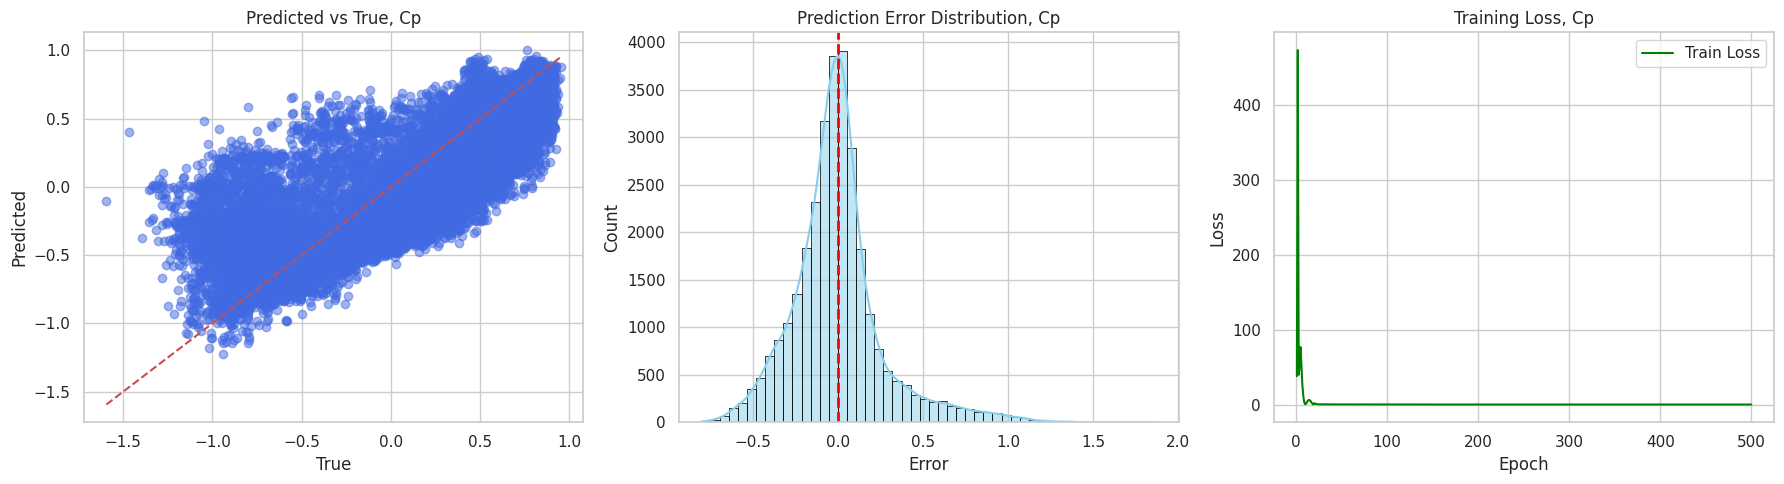

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 26/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 97.95it/s]

Epoch [10/500], Loss: 3.4876


Epochs:   4%|▍         | 20/500 [00:00<00:05, 93.58it/s]

Epoch [20/500], Loss: 1.2180


Epochs:   6%|▌         | 31/500 [00:00<00:04, 100.05it/s]

Epoch [30/500], Loss: 0.7045
Epoch [40/500], Loss: 0.2338


Epochs:   9%|▊         | 43/500 [00:00<00:04, 104.66it/s]

Epoch [50/500], Loss: 0.2563


Epochs:  13%|█▎        | 67/500 [00:00<00:03, 109.23it/s]

Epoch [60/500], Loss: 0.2066
Epoch [70/500], Loss: 0.2031


Epochs:  16%|█▌        | 79/500 [00:00<00:03, 110.24it/s]

Epoch [80/500], Loss: 0.1997


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 111.04it/s]

Epoch [90/500], Loss: 0.1953
Epoch [100/500], Loss: 0.1920


Epochs:  21%|██        | 103/500 [00:00<00:03, 111.14it/s]

Epoch [110/500], Loss: 0.1885


Epochs:  25%|██▌       | 127/500 [00:01<00:03, 111.54it/s]

Epoch [120/500], Loss: 0.1785
Epoch [130/500], Loss: 0.1656


Epochs:  28%|██▊       | 139/500 [00:01<00:03, 111.55it/s]

Epoch [140/500], Loss: 0.1555


Epochs:  30%|███       | 151/500 [00:01<00:03, 111.12it/s]

Epoch [150/500], Loss: 0.1493
Epoch [160/500], Loss: 0.1403


Epochs:  33%|███▎      | 163/500 [00:01<00:03, 111.06it/s]

Epoch [170/500], Loss: 0.1491


Epochs:  37%|███▋      | 187/500 [00:01<00:02, 111.31it/s]

Epoch [180/500], Loss: 0.1269
Epoch [190/500], Loss: 0.1233


Epochs:  40%|███▉      | 199/500 [00:01<00:02, 111.79it/s]

Epoch [200/500], Loss: 0.1196


Epochs:  42%|████▏     | 211/500 [00:01<00:02, 111.97it/s]

Epoch [210/500], Loss: 0.1165
Epoch [220/500], Loss: 0.1140


Epochs:  45%|████▍     | 223/500 [00:02<00:02, 112.02it/s]

Epoch [230/500], Loss: 0.1119


Epochs:  49%|████▉     | 247/500 [00:02<00:02, 111.44it/s]

Epoch [240/500], Loss: 0.1102
Epoch [250/500], Loss: 0.1087


Epochs:  52%|█████▏    | 259/500 [00:02<00:02, 111.40it/s]

Epoch [260/500], Loss: 0.1074


Epochs:  54%|█████▍    | 271/500 [00:02<00:02, 111.34it/s]

Epoch [270/500], Loss: 0.1061
Epoch [280/500], Loss: 0.1050


Epochs:  57%|█████▋    | 283/500 [00:02<00:01, 111.43it/s]

Epoch [290/500], Loss: 0.1038


Epochs:  61%|██████▏   | 307/500 [00:02<00:01, 111.77it/s]

Epoch [300/500], Loss: 0.1234
Epoch [310/500], Loss: 0.1078


Epochs:  64%|██████▍   | 319/500 [00:02<00:01, 111.68it/s]

Epoch [320/500], Loss: 0.1022


Epochs:  66%|██████▌   | 331/500 [00:03<00:01, 111.63it/s]

Epoch [330/500], Loss: 0.1006
Epoch [340/500], Loss: 0.0998


Epochs:  69%|██████▊   | 343/500 [00:03<00:01, 111.53it/s]

Epoch [350/500], Loss: 0.0988


Epochs:  73%|███████▎  | 367/500 [00:03<00:01, 111.69it/s]

Epoch [360/500], Loss: 0.0980
Epoch [370/500], Loss: 0.0972


Epochs:  76%|███████▌  | 379/500 [00:03<00:01, 111.80it/s]

Epoch [380/500], Loss: 0.0964


Epochs:  78%|███████▊  | 391/500 [00:03<00:00, 111.88it/s]

Epoch [390/500], Loss: 0.0957
Epoch [400/500], Loss: 0.1089


Epochs:  81%|████████  | 403/500 [00:03<00:00, 111.81it/s]

Epoch [410/500], Loss: 0.0997


Epochs:  85%|████████▌ | 427/500 [00:03<00:00, 112.30it/s]

Epoch [420/500], Loss: 0.0965
Epoch [430/500], Loss: 0.0943


Epochs:  88%|████████▊ | 439/500 [00:03<00:00, 112.39it/s]

Epoch [440/500], Loss: 0.0934


Epochs:  90%|█████████ | 451/500 [00:04<00:00, 111.91it/s]

Epoch [450/500], Loss: 0.0925
Epoch [460/500], Loss: 0.0917


Epochs:  93%|█████████▎| 463/500 [00:04<00:00, 112.40it/s]

Epoch [470/500], Loss: 0.0911


Epochs:  97%|█████████▋| 487/500 [00:04<00:00, 111.66it/s]

Epoch [480/500], Loss: 0.0906
Epoch [490/500], Loss: 0.1172


Epochs: 100%|██████████| 500/500 [00:04<00:00, 110.82it/s]

Epoch [500/500], Loss: 0.0975
📈 Evaluation metrics on test set:
MSE: 0.0971
MAE: 0.2143
R2: 0.6063



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


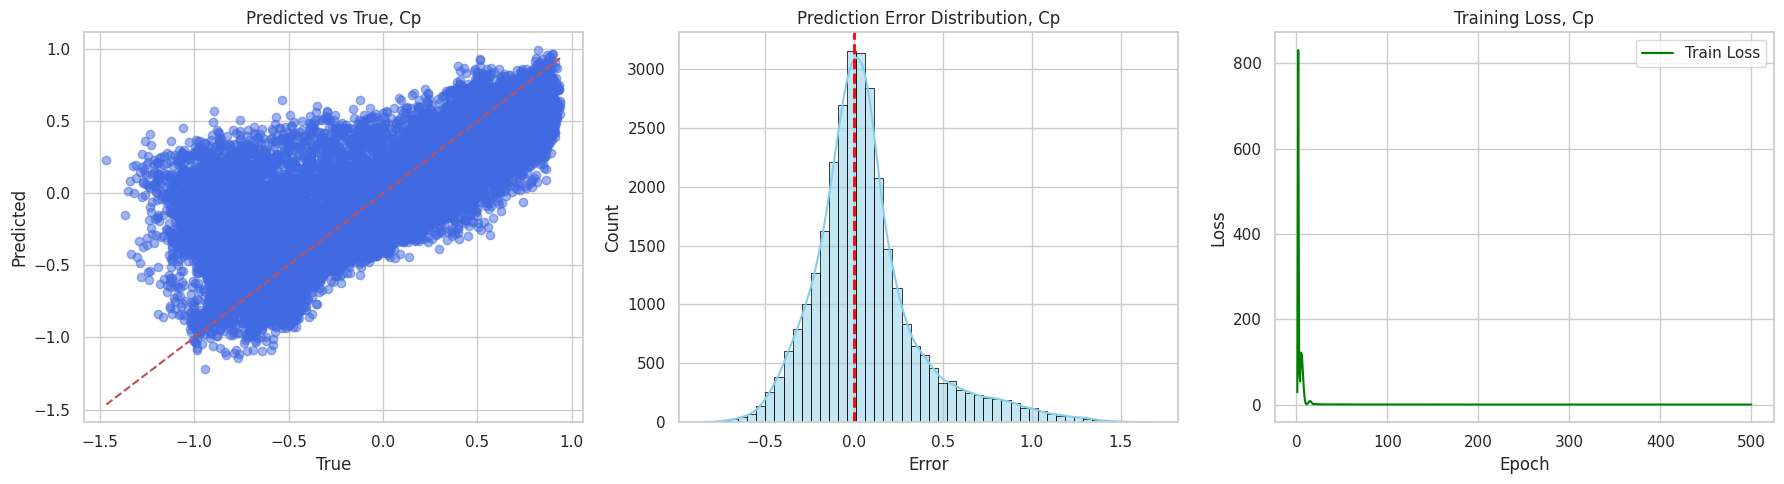

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 27/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.68it/s]

Epoch [10/500], Loss: 8.7096


Epochs:   4%|▍         | 20/500 [00:00<00:05, 94.42it/s]

Epoch [20/500], Loss: 3.8030
Epoch [30/500], Loss: 0.9954


Epochs:   6%|▋         | 32/500 [00:00<00:04, 102.24it/s]

Epoch [40/500], Loss: 0.8487


Epochs:  11%|█         | 56/500 [00:00<00:04, 108.48it/s]

Epoch [50/500], Loss: 0.4269
Epoch [60/500], Loss: 0.2743


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 110.14it/s]

Epoch [70/500], Loss: 0.2371


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 111.75it/s]

Epoch [80/500], Loss: 0.2349
Epoch [90/500], Loss: 0.2299
Epoch [100/500], Loss: 0.2169


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 112.28it/s]

Epoch [110/500], Loss: 0.2026
Epoch [120/500], Loss: 0.1932


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 112.61it/s]

Epoch [130/500], Loss: 0.1769


Epochs:  30%|███       | 152/500 [00:01<00:03, 112.16it/s]

Epoch [140/500], Loss: 0.1627
Epoch [150/500], Loss: 0.1430
Epoch [160/500], Loss: 0.1293


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 112.86it/s]

Epoch [170/500], Loss: 0.1203
Epoch [180/500], Loss: 0.1145


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 113.06it/s]

Epoch [190/500], Loss: 0.1103


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 112.80it/s]

Epoch [200/500], Loss: 0.1067
Epoch [210/500], Loss: 0.1026
Epoch [220/500], Loss: 0.0989


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 112.56it/s]

Epoch [230/500], Loss: 0.0932
Epoch [240/500], Loss: 0.0909


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 112.82it/s]

Epoch [250/500], Loss: 0.0872


Epochs:  54%|█████▍    | 272/500 [00:02<00:02, 112.54it/s]

Epoch [260/500], Loss: 0.0856
Epoch [270/500], Loss: 0.0840
Epoch [280/500], Loss: 0.0831


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 112.90it/s]

Epoch [290/500], Loss: 0.0815
Epoch [300/500], Loss: 0.0820


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 112.66it/s]

Epoch [310/500], Loss: 0.0799


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 112.52it/s]

Epoch [320/500], Loss: 0.0787
Epoch [330/500], Loss: 0.0773
Epoch [340/500], Loss: 0.0801


Epochs:  71%|███████   | 356/500 [00:03<00:01, 112.13it/s]

Epoch [350/500], Loss: 0.0754
Epoch [360/500], Loss: 0.0741


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 111.96it/s]

Epoch [370/500], Loss: 0.0741


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 112.05it/s]

Epoch [380/500], Loss: 0.0732
Epoch [390/500], Loss: 0.0777
Epoch [400/500], Loss: 0.0733


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 112.03it/s]

Epoch [410/500], Loss: 0.0718
Epoch [420/500], Loss: 0.0699


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 112.28it/s]

Epoch [430/500], Loss: 0.0701


Epochs:  90%|█████████ | 452/500 [00:04<00:00, 111.88it/s]

Epoch [440/500], Loss: 0.0682
Epoch [450/500], Loss: 0.0687
Epoch [460/500], Loss: 0.0707


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 112.56it/s]

Epoch [470/500], Loss: 0.0719
Epoch [480/500], Loss: 0.0671


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 112.30it/s]

Epoch [490/500], Loss: 0.0662


Epochs: 100%|██████████| 500/500 [00:04<00:00, 111.59it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0656
📈 Evaluation metrics on test set:
MSE: 0.0659
MAE: 0.1817
R2: 0.7357


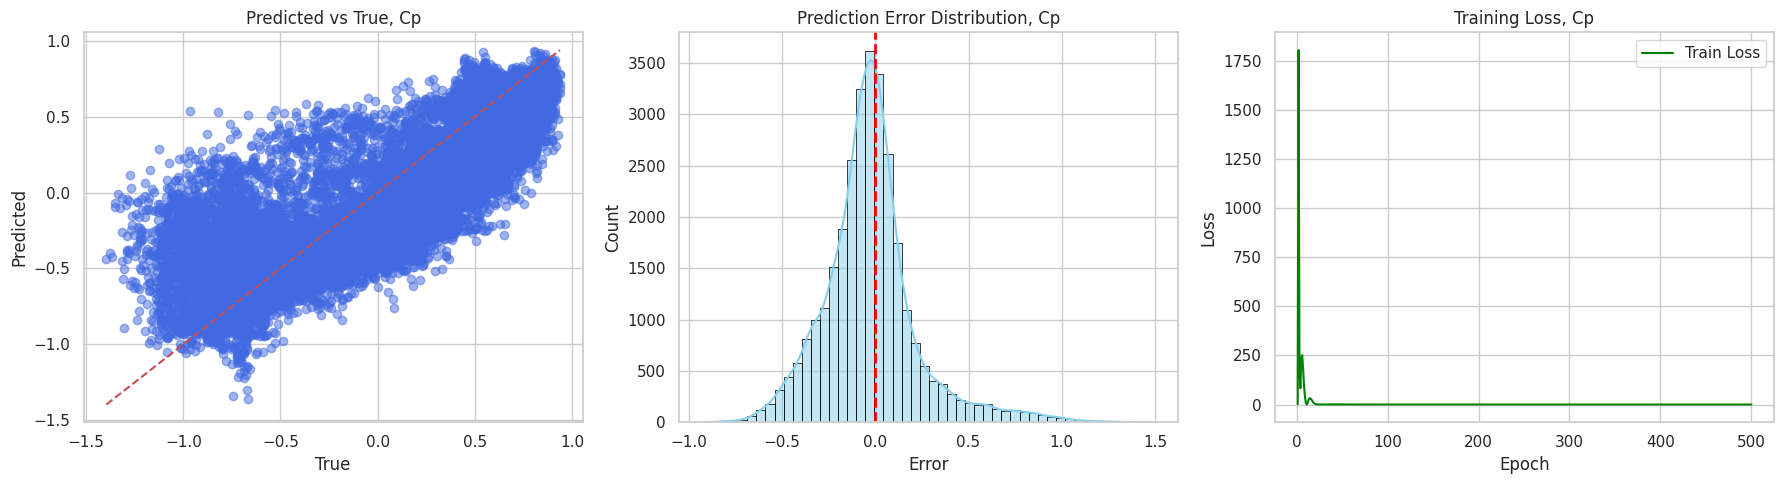

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 28/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.04it/s]

Epoch [10/500], Loss: 5.3188


Epochs:   4%|▍         | 20/500 [00:00<00:05, 92.93it/s]

Epoch [20/500], Loss: 1.8813
Epoch [30/500], Loss: 0.3288


Epochs:   6%|▋         | 32/500 [00:00<00:04, 102.05it/s]

Epoch [40/500], Loss: 0.2599


Epochs:  11%|█         | 56/500 [00:00<00:04, 109.47it/s]

Epoch [50/500], Loss: 0.2508
Epoch [60/500], Loss: 0.2371


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 111.24it/s]

Epoch [70/500], Loss: 0.2234


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 112.14it/s]

Epoch [80/500], Loss: 0.2186
Epoch [90/500], Loss: 0.2114
Epoch [100/500], Loss: 0.2059


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 113.42it/s]

Epoch [110/500], Loss: 0.2022
Epoch [120/500], Loss: 0.1993


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 113.62it/s]

Epoch [130/500], Loss: 0.1964


Epochs:  30%|███       | 152/500 [00:01<00:03, 113.39it/s]

Epoch [140/500], Loss: 0.1801
Epoch [150/500], Loss: 0.1609
Epoch [160/500], Loss: 0.1473


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 113.21it/s]

Epoch [170/500], Loss: 0.1390
Epoch [180/500], Loss: 0.1322


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 113.22it/s]

Epoch [190/500], Loss: 0.1270


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 113.71it/s]

Epoch [200/500], Loss: 0.1225
Epoch [210/500], Loss: 0.1193
Epoch [220/500], Loss: 0.1169


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 112.85it/s]

Epoch [230/500], Loss: 0.1136
Epoch [240/500], Loss: 0.1123


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 112.80it/s]

Epoch [250/500], Loss: 0.1109


Epochs:  54%|█████▍    | 272/500 [00:02<00:02, 113.85it/s]

Epoch [260/500], Loss: 0.1080
Epoch [270/500], Loss: 0.1064
Epoch [280/500], Loss: 0.1042


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 114.17it/s]

Epoch [290/500], Loss: 0.1063
Epoch [300/500], Loss: 0.1060


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 114.20it/s]

Epoch [310/500], Loss: 0.1012


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 113.97it/s]

Epoch [320/500], Loss: 0.0999
Epoch [330/500], Loss: 0.0990
Epoch [340/500], Loss: 0.0979


Epochs:  71%|███████   | 356/500 [00:03<00:01, 113.79it/s]

Epoch [350/500], Loss: 0.0968
Epoch [360/500], Loss: 0.0959


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 113.47it/s]

Epoch [370/500], Loss: 0.0971


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 113.57it/s]

Epoch [380/500], Loss: 0.1053
Epoch [390/500], Loss: 0.0979
Epoch [400/500], Loss: 0.0934


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 113.55it/s]

Epoch [410/500], Loss: 0.0930
Epoch [420/500], Loss: 0.0918


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 113.54it/s]

Epoch [430/500], Loss: 0.0908


Epochs:  90%|█████████ | 452/500 [00:04<00:00, 113.69it/s]

Epoch [440/500], Loss: 0.0901
Epoch [450/500], Loss: 0.1032
Epoch [460/500], Loss: 0.0921


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 113.71it/s]

Epoch [470/500], Loss: 0.0932
Epoch [480/500], Loss: 0.0879


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 113.98it/s]

Epoch [490/500], Loss: 0.0869


Epochs: 100%|██████████| 500/500 [00:04<00:00, 112.68it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0855
📈 Evaluation metrics on test set:
MSE: 0.0862
MAE: 0.2100
R2: 0.6504


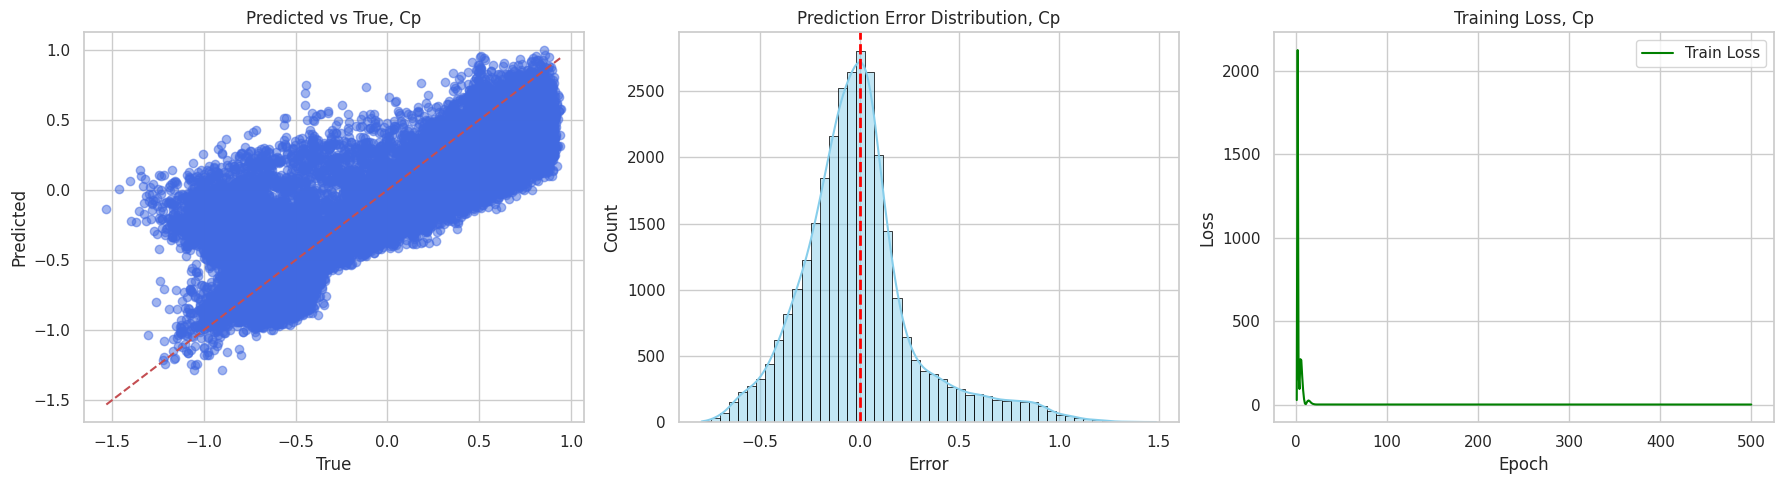

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 29/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   2%|▏         | 12/500 [00:00<00:04, 115.23it/s]

Epoch [10/500], Loss: 13.2726
Epoch [20/500], Loss: 4.8995


Epochs:   5%|▍         | 24/500 [00:00<00:04, 109.44it/s]

Epoch [30/500], Loss: 0.4559


Epochs:  10%|▉         | 48/500 [00:00<00:04, 112.64it/s]

Epoch [40/500], Loss: 0.2732
Epoch [50/500], Loss: 0.2924


Epochs:  12%|█▏        | 60/500 [00:00<00:03, 113.57it/s]

Epoch [60/500], Loss: 0.2303


Epochs:  14%|█▍        | 72/500 [00:00<00:03, 114.08it/s]

Epoch [70/500], Loss: 0.2220
Epoch [80/500], Loss: 0.2207


Epochs:  17%|█▋        | 84/500 [00:00<00:03, 114.59it/s]

Epoch [90/500], Loss: 0.2133


Epochs:  22%|██▏       | 108/500 [00:00<00:03, 114.12it/s]

Epoch [100/500], Loss: 0.2090
Epoch [110/500], Loss: 0.2029


Epochs:  24%|██▍       | 120/500 [00:01<00:03, 113.84it/s]

Epoch [120/500], Loss: 0.2009


Epochs:  26%|██▋       | 132/500 [00:01<00:03, 113.92it/s]

Epoch [130/500], Loss: 0.1984
Epoch [140/500], Loss: 0.1953


Epochs:  29%|██▉       | 144/500 [00:01<00:03, 114.35it/s]

Epoch [150/500], Loss: 0.1916


Epochs:  34%|███▎      | 168/500 [00:01<00:02, 114.32it/s]

Epoch [160/500], Loss: 0.1879
Epoch [170/500], Loss: 0.1785


Epochs:  36%|███▌      | 180/500 [00:01<00:02, 113.93it/s]

Epoch [180/500], Loss: 0.1487


Epochs:  38%|███▊      | 192/500 [00:01<00:02, 114.05it/s]

Epoch [190/500], Loss: 0.1360
Epoch [200/500], Loss: 0.1283


Epochs:  41%|████      | 204/500 [00:01<00:02, 114.57it/s]

Epoch [210/500], Loss: 0.1221


Epochs:  46%|████▌     | 228/500 [00:02<00:02, 114.10it/s]

Epoch [220/500], Loss: 0.1185
Epoch [230/500], Loss: 0.1154


Epochs:  48%|████▊     | 240/500 [00:02<00:02, 113.68it/s]

Epoch [240/500], Loss: 0.1131


Epochs:  50%|█████     | 252/500 [00:02<00:02, 113.97it/s]

Epoch [250/500], Loss: 0.1112
Epoch [260/500], Loss: 0.1098


Epochs:  53%|█████▎    | 264/500 [00:02<00:02, 114.30it/s]

Epoch [270/500], Loss: 0.1082


Epochs:  58%|█████▊    | 288/500 [00:02<00:01, 114.16it/s]

Epoch [280/500], Loss: 0.1065
Epoch [290/500], Loss: 0.1053


Epochs:  60%|██████    | 300/500 [00:02<00:01, 114.30it/s]

Epoch [300/500], Loss: 0.1039


Epochs:  62%|██████▏   | 312/500 [00:02<00:01, 113.79it/s]

Epoch [310/500], Loss: 0.1029
Epoch [320/500], Loss: 0.1018


Epochs:  65%|██████▍   | 324/500 [00:02<00:01, 113.88it/s]

Epoch [330/500], Loss: 0.1008


Epochs:  70%|██████▉   | 348/500 [00:03<00:01, 114.25it/s]

Epoch [340/500], Loss: 0.1001
Epoch [350/500], Loss: 0.0993


Epochs:  72%|███████▏  | 360/500 [00:03<00:01, 114.64it/s]

Epoch [360/500], Loss: 0.0990


Epochs:  74%|███████▍  | 372/500 [00:03<00:01, 114.50it/s]

Epoch [370/500], Loss: 0.0980
Epoch [380/500], Loss: 0.0975


Epochs:  77%|███████▋  | 384/500 [00:03<00:01, 114.18it/s]

Epoch [390/500], Loss: 0.0972


Epochs:  82%|████████▏ | 408/500 [00:03<00:00, 113.62it/s]

Epoch [400/500], Loss: 0.0965
Epoch [410/500], Loss: 0.0976


Epochs:  84%|████████▍ | 420/500 [00:03<00:00, 113.95it/s]

Epoch [420/500], Loss: 0.0961


Epochs:  86%|████████▋ | 432/500 [00:03<00:00, 114.10it/s]

Epoch [430/500], Loss: 0.0954
Epoch [440/500], Loss: 0.0948


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 113.80it/s]

Epoch [450/500], Loss: 0.1086


Epochs:  94%|█████████▎| 468/500 [00:04<00:00, 114.47it/s]

Epoch [460/500], Loss: 0.0970
Epoch [470/500], Loss: 0.0960


Epochs:  96%|█████████▌| 480/500 [00:04<00:00, 114.67it/s]

Epoch [480/500], Loss: 0.0943


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.06it/s]

Epoch [490/500], Loss: 0.0918
Epoch [500/500], Loss: 0.0873
📈 Evaluation metrics on test set:
MSE: 0.0860
MAE: 0.2077
R2: 0.6499



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


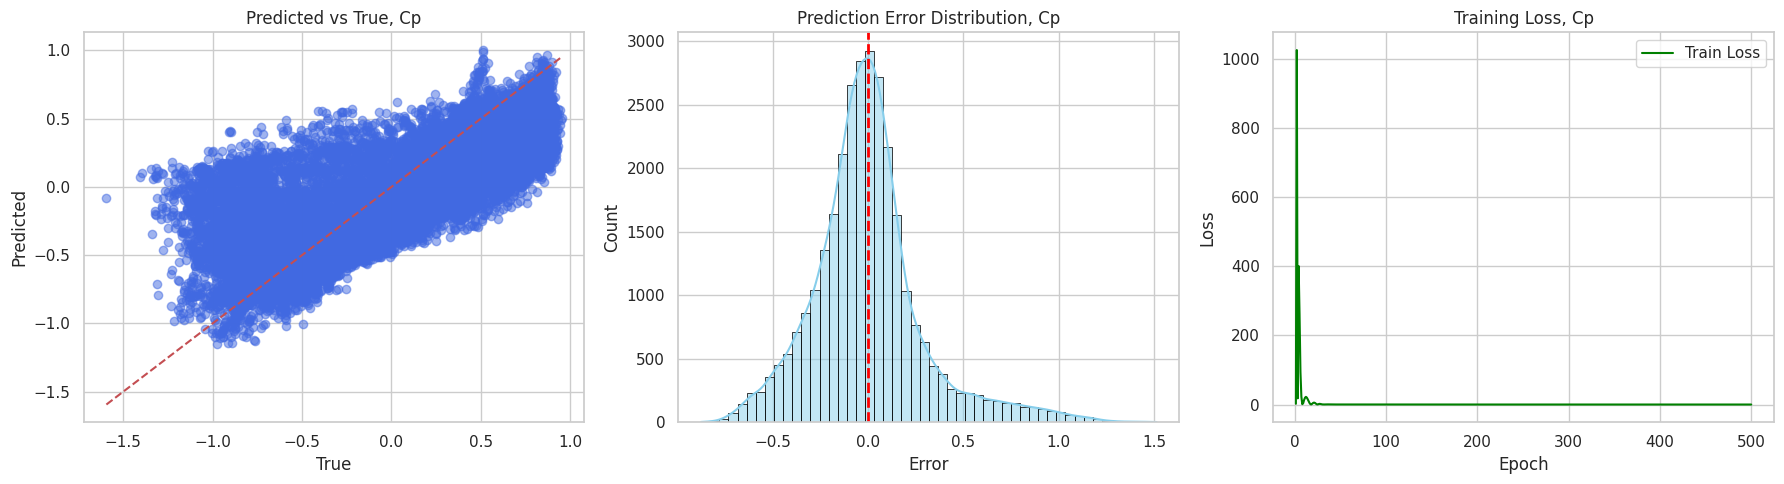

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 30/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 117.12it/s]

Epoch [10/500], Loss: 26.3275
Epoch [20/500], Loss: 0.3677
Epoch [30/500], Loss: 0.3202


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 116.05it/s]

Epoch [40/500], Loss: 0.2566
Epoch [50/500], Loss: 0.2152
Epoch [60/500], Loss: 0.2058


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 115.93it/s]

Epoch [70/500], Loss: 0.1956
Epoch [80/500], Loss: 0.1858
Epoch [90/500], Loss: 0.1767


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 115.84it/s]

Epoch [100/500], Loss: 0.1649
Epoch [110/500], Loss: 0.1578
Epoch [120/500], Loss: 0.1511


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 115.69it/s]

Epoch [130/500], Loss: 0.1467
Epoch [140/500], Loss: 0.1431
Epoch [150/500], Loss: 0.1398


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 114.92it/s]

Epoch [160/500], Loss: 0.1365
Epoch [170/500], Loss: 0.1342
Epoch [180/500], Loss: 0.1262


Epochs:  41%|████      | 206/500 [00:01<00:02, 115.17it/s]

Epoch [190/500], Loss: 0.1192
Epoch [200/500], Loss: 0.1129
Epoch [210/500], Loss: 0.1079


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 115.39it/s]

Epoch [220/500], Loss: 0.1050
Epoch [230/500], Loss: 0.1024
Epoch [240/500], Loss: 0.1000


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 115.35it/s]

Epoch [250/500], Loss: 0.1013
Epoch [260/500], Loss: 0.0970
Epoch [270/500], Loss: 0.0959


Epochs:  60%|██████    | 302/500 [00:02<00:01, 115.54it/s]

Epoch [280/500], Loss: 0.0944
Epoch [290/500], Loss: 0.0933
Epoch [300/500], Loss: 0.0926


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 115.65it/s]

Epoch [310/500], Loss: 0.0916
Epoch [320/500], Loss: 0.0906
Epoch [330/500], Loss: 0.0903


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 115.13it/s]

Epoch [340/500], Loss: 0.0887
Epoch [350/500], Loss: 0.0923
Epoch [360/500], Loss: 0.0883


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 115.46it/s]

Epoch [370/500], Loss: 0.0874
Epoch [380/500], Loss: 0.0862
Epoch [390/500], Loss: 0.0855


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 115.68it/s]

Epoch [400/500], Loss: 0.0859
Epoch [410/500], Loss: 0.0844
Epoch [420/500], Loss: 0.0860


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 115.47it/s]

Epoch [430/500], Loss: 0.0836
Epoch [440/500], Loss: 0.0834
Epoch [450/500], Loss: 0.0838


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 115.64it/s]

Epoch [460/500], Loss: 0.0820
Epoch [470/500], Loss: 0.0827
Epoch [480/500], Loss: 0.0821


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.57it/s]


Epoch [490/500], Loss: 0.0817
Epoch [500/500], Loss: 0.0829
📈 Evaluation metrics on test set:
MSE: 0.0827
MAE: 0.2117
R2: 0.6626


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


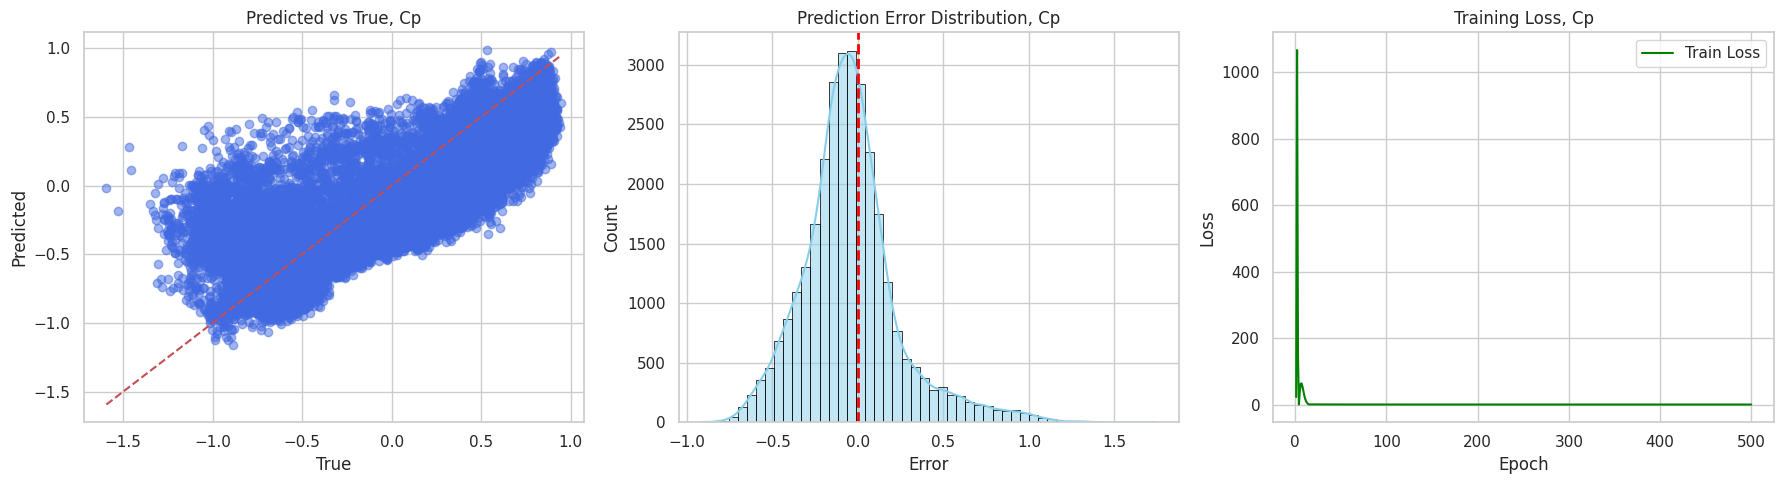

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 31/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.06it/s]

Epoch [10/500], Loss: 3.6876


Epochs:   4%|▍         | 21/500 [00:00<00:04, 98.37it/s]

Epoch [20/500], Loss: 0.3263
Epoch [30/500], Loss: 0.4099


Epochs:   7%|▋         | 33/500 [00:00<00:04, 106.28it/s]

Epoch [40/500], Loss: 0.2534


Epochs:  11%|█▏        | 57/500 [00:00<00:03, 112.26it/s]

Epoch [50/500], Loss: 0.2464
Epoch [60/500], Loss: 0.2453


Epochs:  14%|█▍        | 69/500 [00:00<00:03, 113.42it/s]

Epoch [70/500], Loss: 0.2309


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 114.73it/s]

Epoch [80/500], Loss: 0.2123
Epoch [90/500], Loss: 0.2065
Epoch [100/500], Loss: 0.2013


Epochs:  23%|██▎       | 117/500 [00:01<00:03, 115.11it/s]

Epoch [110/500], Loss: 0.1888
Epoch [120/500], Loss: 0.1701


Epochs:  26%|██▌       | 129/500 [00:01<00:03, 115.19it/s]

Epoch [130/500], Loss: 0.1563


Epochs:  31%|███       | 153/500 [00:01<00:03, 114.75it/s]

Epoch [140/500], Loss: 0.1468
Epoch [150/500], Loss: 0.1403
Epoch [160/500], Loss: 0.1356


Epochs:  35%|███▌      | 177/500 [00:01<00:02, 114.09it/s]

Epoch [170/500], Loss: 0.1321
Epoch [180/500], Loss: 0.1289


Epochs:  38%|███▊      | 189/500 [00:01<00:02, 114.32it/s]

Epoch [190/500], Loss: 0.1659


Epochs:  43%|████▎     | 213/500 [00:01<00:02, 115.08it/s]

Epoch [200/500], Loss: 0.1333
Epoch [210/500], Loss: 0.1261
Epoch [220/500], Loss: 0.1223


Epochs:  47%|████▋     | 237/500 [00:02<00:02, 115.30it/s]

Epoch [230/500], Loss: 0.1202
Epoch [240/500], Loss: 0.1179


Epochs:  50%|████▉     | 249/500 [00:02<00:02, 115.42it/s]

Epoch [250/500], Loss: 0.1160


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 115.39it/s]

Epoch [260/500], Loss: 0.1141
Epoch [270/500], Loss: 0.1122
Epoch [280/500], Loss: 0.1103


Epochs:  59%|█████▉    | 297/500 [00:02<00:01, 115.47it/s]

Epoch [290/500], Loss: 0.1079
Epoch [300/500], Loss: 0.1054


Epochs:  62%|██████▏   | 309/500 [00:02<00:01, 115.42it/s]

Epoch [310/500], Loss: 0.1031


Epochs:  67%|██████▋   | 333/500 [00:02<00:01, 115.30it/s]

Epoch [320/500], Loss: 0.1009
Epoch [330/500], Loss: 0.0985
Epoch [340/500], Loss: 0.0962


Epochs:  71%|███████▏  | 357/500 [00:03<00:01, 115.50it/s]

Epoch [350/500], Loss: 0.0941
Epoch [360/500], Loss: 0.0922


Epochs:  74%|███████▍  | 369/500 [00:03<00:01, 115.20it/s]

Epoch [370/500], Loss: 0.0895


Epochs:  79%|███████▊  | 393/500 [00:03<00:00, 114.95it/s]

Epoch [380/500], Loss: 0.0865
Epoch [390/500], Loss: 0.0847
Epoch [400/500], Loss: 0.0834


Epochs:  83%|████████▎ | 417/500 [00:03<00:00, 115.21it/s]

Epoch [410/500], Loss: 0.0819
Epoch [420/500], Loss: 0.0805


Epochs:  86%|████████▌ | 429/500 [00:03<00:00, 115.36it/s]

Epoch [430/500], Loss: 0.0792


Epochs:  91%|█████████ | 453/500 [00:03<00:00, 115.64it/s]

Epoch [440/500], Loss: 0.0780
Epoch [450/500], Loss: 0.0772
Epoch [460/500], Loss: 0.0758


Epochs:  95%|█████████▌| 477/500 [00:04<00:00, 115.47it/s]

Epoch [470/500], Loss: 0.0748
Epoch [480/500], Loss: 0.0742


Epochs:  98%|█████████▊| 489/500 [00:04<00:00, 115.60it/s]

Epoch [490/500], Loss: 0.0733


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.43it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.5007
📈 Evaluation metrics on test set:
MSE: 0.8278
MAE: 0.6654
R2: -2.3557


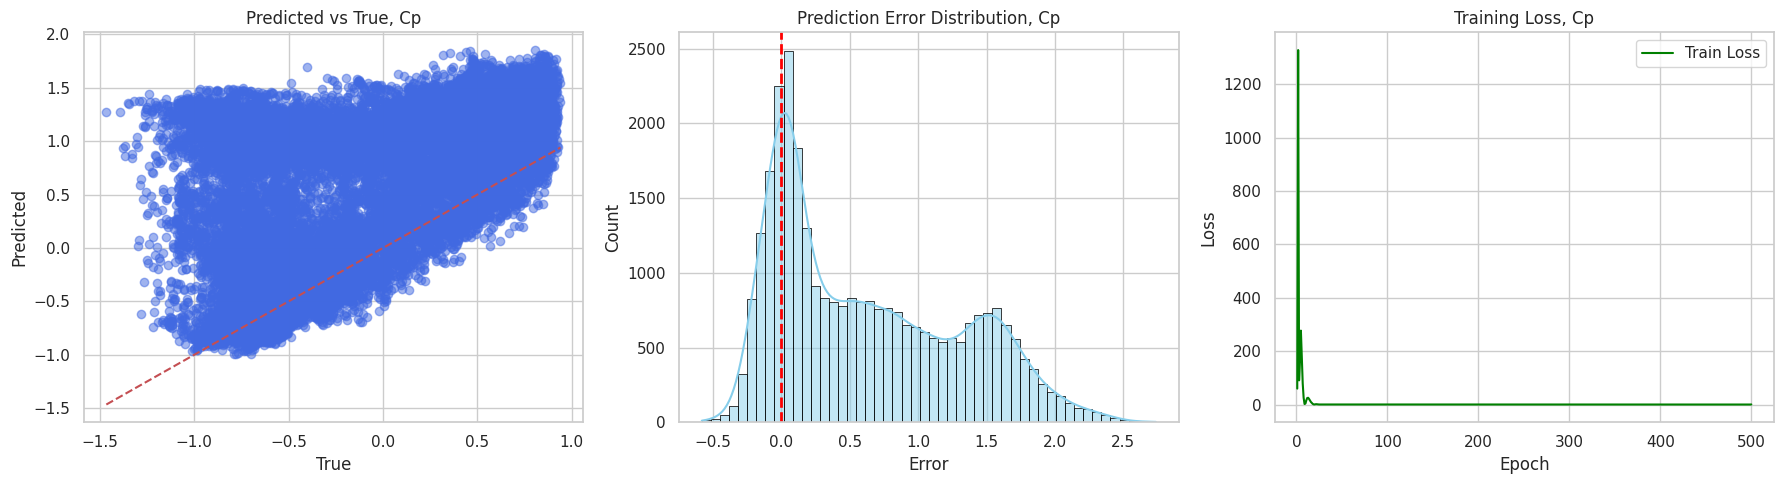

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 32/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.84it/s]

Epoch [10/500], Loss: 0.4385


Epochs:   4%|▍         | 21/500 [00:00<00:04, 99.49it/s]

Epoch [20/500], Loss: 10.2750
Epoch [30/500], Loss: 0.3622


Epochs:   6%|▋         | 32/500 [00:00<00:04, 102.95it/s]

Epoch [40/500], Loss: 0.6958


Epochs:  11%|█         | 56/500 [00:00<00:04, 110.87it/s]

Epoch [50/500], Loss: 0.5453
Epoch [60/500], Loss: 0.2578


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 112.85it/s]

Epoch [70/500], Loss: 0.2322


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 114.59it/s]

Epoch [80/500], Loss: 0.2204
Epoch [90/500], Loss: 0.2096
Epoch [100/500], Loss: 0.2079


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 115.41it/s]

Epoch [110/500], Loss: 0.2044
Epoch [120/500], Loss: 0.2012


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 115.86it/s]

Epoch [130/500], Loss: 0.1994


Epochs:  30%|███       | 152/500 [00:01<00:03, 115.70it/s]

Epoch [140/500], Loss: 0.1973
Epoch [150/500], Loss: 0.1948
Epoch [160/500], Loss: 0.1924


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 116.02it/s]

Epoch [170/500], Loss: 0.1899
Epoch [180/500], Loss: 0.2371


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 116.15it/s]

Epoch [190/500], Loss: 0.1715


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 115.94it/s]

Epoch [200/500], Loss: 0.1505
Epoch [210/500], Loss: 0.1339
Epoch [220/500], Loss: 0.1270


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 116.00it/s]

Epoch [230/500], Loss: 0.1226
Epoch [240/500], Loss: 0.1194


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 115.53it/s]

Epoch [250/500], Loss: 0.1209


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 115.81it/s]

Epoch [260/500], Loss: 0.1157
Epoch [270/500], Loss: 0.1096
Epoch [280/500], Loss: 0.1059


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 115.75it/s]

Epoch [290/500], Loss: 0.1036
Epoch [300/500], Loss: 0.1012


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 115.92it/s]

Epoch [310/500], Loss: 0.0993


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 116.07it/s]

Epoch [320/500], Loss: 0.0973
Epoch [330/500], Loss: 0.0940
Epoch [340/500], Loss: 0.0902


Epochs:  71%|███████   | 356/500 [00:03<00:01, 115.71it/s]

Epoch [350/500], Loss: 0.0869
Epoch [360/500], Loss: 0.0848


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 115.64it/s]

Epoch [370/500], Loss: 0.0833


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 115.63it/s]

Epoch [380/500], Loss: 0.0838
Epoch [390/500], Loss: 0.0818
Epoch [400/500], Loss: 0.0806


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 115.78it/s]

Epoch [410/500], Loss: 0.0798
Epoch [420/500], Loss: 0.0792


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 115.85it/s]

Epoch [430/500], Loss: 0.0823


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 116.04it/s]

Epoch [440/500], Loss: 0.0783
Epoch [450/500], Loss: 0.0779
Epoch [460/500], Loss: 0.0768


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 115.78it/s]

Epoch [470/500], Loss: 0.0762
Epoch [480/500], Loss: 0.0755


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 115.79it/s]

Epoch [490/500], Loss: 0.0802


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.81it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0747
📈 Evaluation metrics on test set:
MSE: 0.0755
MAE: 0.1901
R2: 0.6953


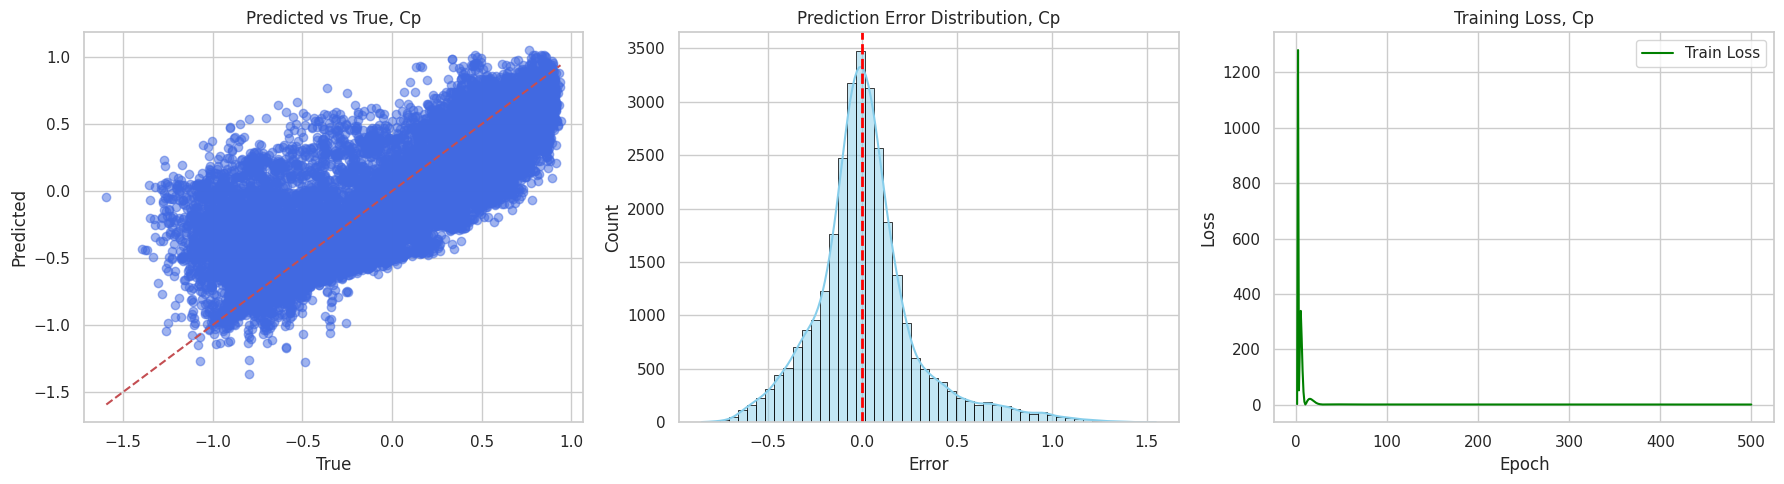

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 33/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.07it/s]

Epoch [10/500], Loss: 0.2940


Epochs:   4%|▍         | 21/500 [00:00<00:04, 100.31it/s]

Epoch [20/500], Loss: 7.7223
Epoch [30/500], Loss: 0.3907


Epochs:   7%|▋         | 33/500 [00:00<00:04, 106.77it/s]

Epoch [40/500], Loss: 0.8301


Epochs:  11%|█▏        | 57/500 [00:00<00:03, 112.52it/s]

Epoch [50/500], Loss: 0.3489
Epoch [60/500], Loss: 0.2325


Epochs:  14%|█▍        | 69/500 [00:00<00:03, 113.74it/s]

Epoch [70/500], Loss: 0.2473


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 115.28it/s]

Epoch [80/500], Loss: 0.2339
Epoch [90/500], Loss: 0.2213
Epoch [100/500], Loss: 0.2173


Epochs:  23%|██▎       | 117/500 [00:01<00:03, 115.54it/s]

Epoch [110/500], Loss: 0.2123
Epoch [120/500], Loss: 0.2070


Epochs:  26%|██▌       | 129/500 [00:01<00:03, 115.72it/s]

Epoch [130/500], Loss: 0.2047


Epochs:  31%|███       | 153/500 [00:01<00:02, 115.92it/s]

Epoch [140/500], Loss: 0.2027
Epoch [150/500], Loss: 0.1824
Epoch [160/500], Loss: 0.1737


Epochs:  35%|███▌      | 177/500 [00:01<00:02, 115.69it/s]

Epoch [170/500], Loss: 0.1361
Epoch [180/500], Loss: 0.1282


Epochs:  38%|███▊      | 189/500 [00:01<00:02, 115.35it/s]

Epoch [190/500], Loss: 0.1197


Epochs:  43%|████▎     | 213/500 [00:01<00:02, 115.24it/s]

Epoch [200/500], Loss: 0.1134
Epoch [210/500], Loss: 0.1085
Epoch [220/500], Loss: 0.1048


Epochs:  47%|████▋     | 237/500 [00:02<00:02, 115.20it/s]

Epoch [230/500], Loss: 0.1018
Epoch [240/500], Loss: 0.0993


Epochs:  50%|████▉     | 249/500 [00:02<00:02, 115.42it/s]

Epoch [250/500], Loss: 0.0971


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 115.14it/s]

Epoch [260/500], Loss: 0.0950
Epoch [270/500], Loss: 0.0925
Epoch [280/500], Loss: 0.0903


Epochs:  59%|█████▉    | 297/500 [00:02<00:01, 115.20it/s]

Epoch [290/500], Loss: 0.0884
Epoch [300/500], Loss: 0.0868


Epochs:  62%|██████▏   | 309/500 [00:02<00:01, 114.69it/s]

Epoch [310/500], Loss: 0.0850


Epochs:  67%|██████▋   | 333/500 [00:02<00:01, 114.77it/s]

Epoch [320/500], Loss: 0.0837
Epoch [330/500], Loss: 0.0828
Epoch [340/500], Loss: 0.0822


Epochs:  71%|███████▏  | 357/500 [00:03<00:01, 115.07it/s]

Epoch [350/500], Loss: 0.0805
Epoch [360/500], Loss: 0.0795


Epochs:  74%|███████▍  | 369/500 [00:03<00:01, 115.00it/s]

Epoch [370/500], Loss: 0.0786


Epochs:  79%|███████▊  | 393/500 [00:03<00:00, 115.15it/s]

Epoch [380/500], Loss: 0.0800
Epoch [390/500], Loss: 0.0777
Epoch [400/500], Loss: 0.0764


Epochs:  83%|████████▎ | 417/500 [00:03<00:00, 115.29it/s]

Epoch [410/500], Loss: 0.0757
Epoch [420/500], Loss: 0.0751


Epochs:  86%|████████▌ | 429/500 [00:03<00:00, 115.39it/s]

Epoch [430/500], Loss: 0.0761


Epochs:  91%|█████████ | 453/500 [00:03<00:00, 115.38it/s]

Epoch [440/500], Loss: 0.0743
Epoch [450/500], Loss: 0.0736
Epoch [460/500], Loss: 0.0726


Epochs:  95%|█████████▌| 477/500 [00:04<00:00, 115.58it/s]

Epoch [470/500], Loss: 0.0736
Epoch [480/500], Loss: 0.0720


Epochs:  98%|█████████▊| 489/500 [00:04<00:00, 115.51it/s]

Epoch [490/500], Loss: 0.0712


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.59it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0704
📈 Evaluation metrics on test set:
MSE: 0.0707
MAE: 0.1867
R2: 0.7143


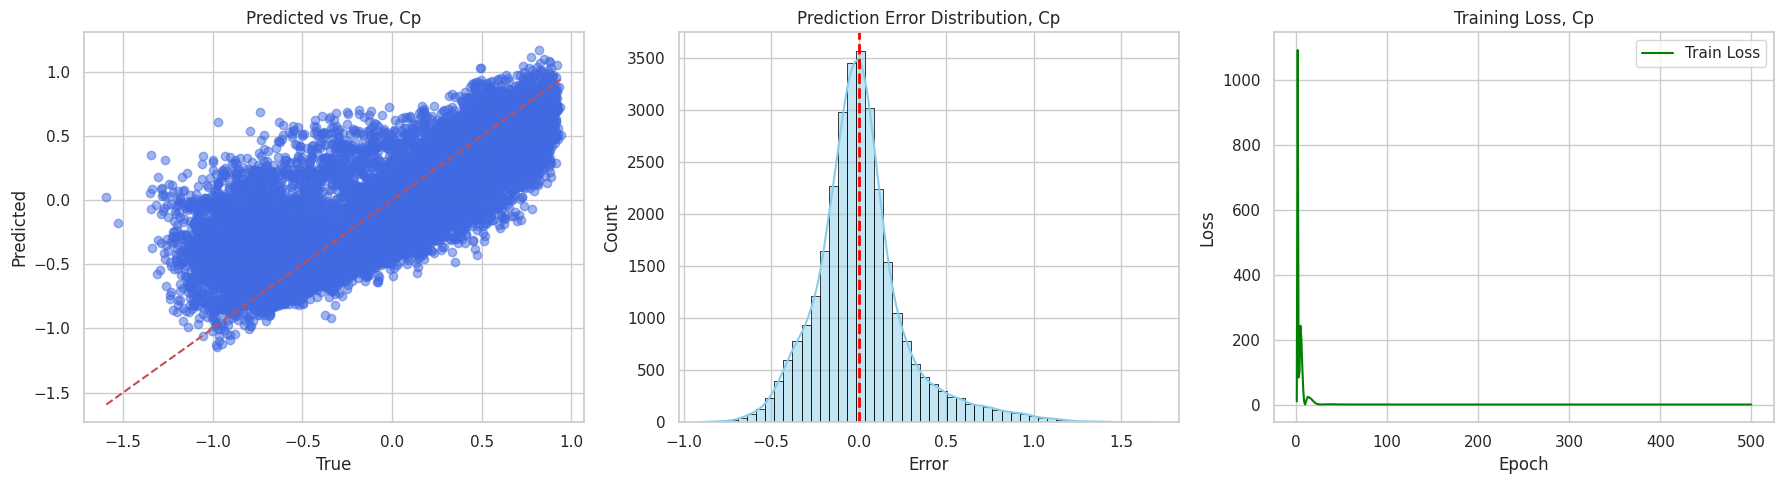

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 34/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.92it/s]

Epoch [10/500], Loss: 11.1653


Epochs:   4%|▍         | 21/500 [00:00<00:04, 99.38it/s]

Epoch [20/500], Loss: 12.7781
Epoch [30/500], Loss: 0.8320


Epochs:   7%|▋         | 33/500 [00:00<00:04, 106.64it/s]

Epoch [40/500], Loss: 0.5404


Epochs:  11%|█▏        | 57/500 [00:00<00:03, 112.14it/s]

Epoch [50/500], Loss: 0.6133
Epoch [60/500], Loss: 0.3151


Epochs:  14%|█▍        | 69/500 [00:00<00:03, 113.47it/s]

Epoch [70/500], Loss: 0.2448


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 114.37it/s]

Epoch [80/500], Loss: 0.2247
Epoch [90/500], Loss: 0.2174
Epoch [100/500], Loss: 0.2054


Epochs:  23%|██▎       | 117/500 [00:01<00:03, 115.09it/s]

Epoch [110/500], Loss: 0.2147
Epoch [120/500], Loss: 0.2093


Epochs:  26%|██▌       | 129/500 [00:01<00:03, 115.30it/s]

Epoch [130/500], Loss: 0.2039


Epochs:  31%|███       | 153/500 [00:01<00:03, 115.43it/s]

Epoch [140/500], Loss: 0.2007
Epoch [150/500], Loss: 0.1961
Epoch [160/500], Loss: 0.1642


Epochs:  35%|███▌      | 177/500 [00:01<00:02, 115.49it/s]

Epoch [170/500], Loss: 0.1464
Epoch [180/500], Loss: 0.1379


Epochs:  38%|███▊      | 189/500 [00:01<00:02, 115.39it/s]

Epoch [190/500], Loss: 0.1334


Epochs:  43%|████▎     | 213/500 [00:01<00:02, 115.52it/s]

Epoch [200/500], Loss: 0.1286
Epoch [210/500], Loss: 0.1230
Epoch [220/500], Loss: 0.1180


Epochs:  47%|████▋     | 237/500 [00:02<00:02, 115.58it/s]

Epoch [230/500], Loss: 0.1137
Epoch [240/500], Loss: 0.1096


Epochs:  50%|████▉     | 249/500 [00:02<00:02, 115.45it/s]

Epoch [250/500], Loss: 0.1057


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 115.25it/s]

Epoch [260/500], Loss: 0.1019
Epoch [270/500], Loss: 0.0985
Epoch [280/500], Loss: 0.0963


Epochs:  59%|█████▉    | 297/500 [00:02<00:01, 115.09it/s]

Epoch [290/500], Loss: 0.0939
Epoch [300/500], Loss: 0.0920


Epochs:  62%|██████▏   | 309/500 [00:02<00:01, 115.20it/s]

Epoch [310/500], Loss: 0.0905


Epochs:  67%|██████▋   | 333/500 [00:02<00:01, 115.11it/s]

Epoch [320/500], Loss: 0.0891
Epoch [330/500], Loss: 0.0881
Epoch [340/500], Loss: 0.0873


Epochs:  71%|███████▏  | 357/500 [00:03<00:01, 115.13it/s]

Epoch [350/500], Loss: 0.0863
Epoch [360/500], Loss: 0.0852


Epochs:  74%|███████▍  | 369/500 [00:03<00:01, 115.15it/s]

Epoch [370/500], Loss: 0.0842


Epochs:  79%|███████▊  | 393/500 [00:03<00:00, 115.43it/s]

Epoch [380/500], Loss: 0.0835
Epoch [390/500], Loss: 0.0830
Epoch [400/500], Loss: 0.0822


Epochs:  83%|████████▎ | 417/500 [00:03<00:00, 114.82it/s]

Epoch [410/500], Loss: 0.0814
Epoch [420/500], Loss: 0.0812


Epochs:  86%|████████▌ | 429/500 [00:03<00:00, 115.13it/s]

Epoch [430/500], Loss: 0.0804


Epochs:  91%|█████████ | 453/500 [00:03<00:00, 114.82it/s]

Epoch [440/500], Loss: 0.0799
Epoch [450/500], Loss: 0.0791
Epoch [460/500], Loss: 0.0800


Epochs:  95%|█████████▌| 477/500 [00:04<00:00, 115.33it/s]

Epoch [470/500], Loss: 0.0784
Epoch [480/500], Loss: 0.0781


Epochs:  98%|█████████▊| 489/500 [00:04<00:00, 115.31it/s]

Epoch [490/500], Loss: 0.0775


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.46it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0770
📈 Evaluation metrics on test set:
MSE: 0.0764
MAE: 0.1948
R2: 0.6920


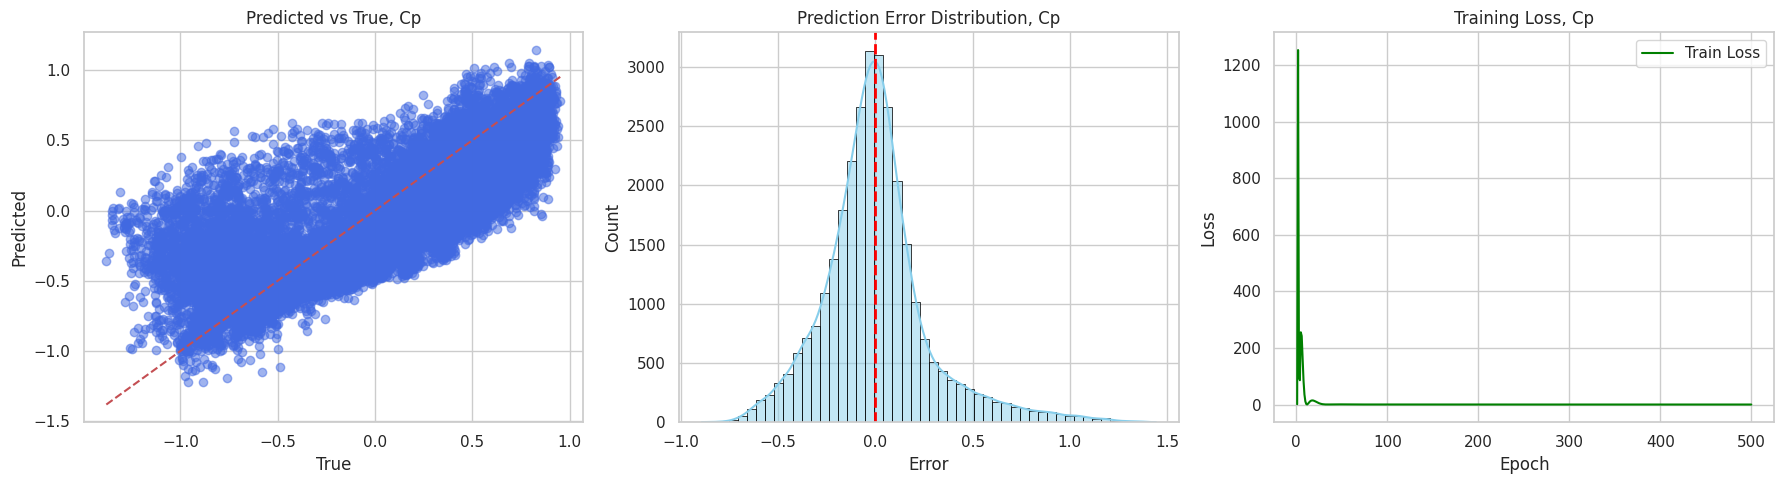

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 35/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.50it/s]

Epoch [10/500], Loss: 62.8554


Epochs:   4%|▍         | 21/500 [00:00<00:04, 97.39it/s]

Epoch [20/500], Loss: 2.2817
Epoch [30/500], Loss: 2.2221


Epochs:   6%|▋         | 32/500 [00:00<00:04, 100.27it/s]

Epoch [40/500], Loss: 0.2435


Epochs:  11%|█         | 56/500 [00:00<00:04, 109.59it/s]

Epoch [50/500], Loss: 0.4285
Epoch [60/500], Loss: 0.2894


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 111.48it/s]

Epoch [70/500], Loss: 0.2288


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 113.51it/s]

Epoch [80/500], Loss: 0.2327
Epoch [90/500], Loss: 0.2207
Epoch [100/500], Loss: 0.2151


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 114.35it/s]

Epoch [110/500], Loss: 0.2153
Epoch [120/500], Loss: 0.2050


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 114.76it/s]

Epoch [130/500], Loss: 0.1991


Epochs:  30%|███       | 152/500 [00:01<00:03, 115.10it/s]

Epoch [140/500], Loss: 0.1785
Epoch [150/500], Loss: 0.1797
Epoch [160/500], Loss: 0.1982


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 115.02it/s]

Epoch [170/500], Loss: 0.1595
Epoch [180/500], Loss: 0.1438


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 115.03it/s]

Epoch [190/500], Loss: 0.1274


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 115.28it/s]

Epoch [200/500], Loss: 0.1190
Epoch [210/500], Loss: 0.1140
Epoch [220/500], Loss: 0.1090


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 114.53it/s]

Epoch [230/500], Loss: 0.1043
Epoch [240/500], Loss: 0.1001


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 114.49it/s]

Epoch [250/500], Loss: 0.0965


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 114.69it/s]

Epoch [260/500], Loss: 0.0934
Epoch [270/500], Loss: 0.0911
Epoch [280/500], Loss: 0.0913


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 114.21it/s]

Epoch [290/500], Loss: 0.0907
Epoch [300/500], Loss: 0.0876


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 113.69it/s]

Epoch [310/500], Loss: 0.0866


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 114.20it/s]

Epoch [320/500], Loss: 0.0849
Epoch [330/500], Loss: 0.0831
Epoch [340/500], Loss: 0.0814


Epochs:  71%|███████   | 356/500 [00:03<00:01, 114.71it/s]

Epoch [350/500], Loss: 0.0810
Epoch [360/500], Loss: 0.0829


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 114.57it/s]

Epoch [370/500], Loss: 0.0826


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 114.77it/s]

Epoch [380/500], Loss: 0.0789
Epoch [390/500], Loss: 0.0777
Epoch [400/500], Loss: 0.0769


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 114.22it/s]

Epoch [410/500], Loss: 0.0759
Epoch [420/500], Loss: 0.0752


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 113.95it/s]

Epoch [430/500], Loss: 0.0762


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 114.17it/s]

Epoch [440/500], Loss: 0.1000
Epoch [450/500], Loss: 0.1120
Epoch [460/500], Loss: 0.0896


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 113.71it/s]

Epoch [470/500], Loss: 0.0857
Epoch [480/500], Loss: 0.0823


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 113.57it/s]

Epoch [490/500], Loss: 0.0804


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.42it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0790
📈 Evaluation metrics on test set:
MSE: 0.0785
MAE: 0.2001
R2: 0.6844


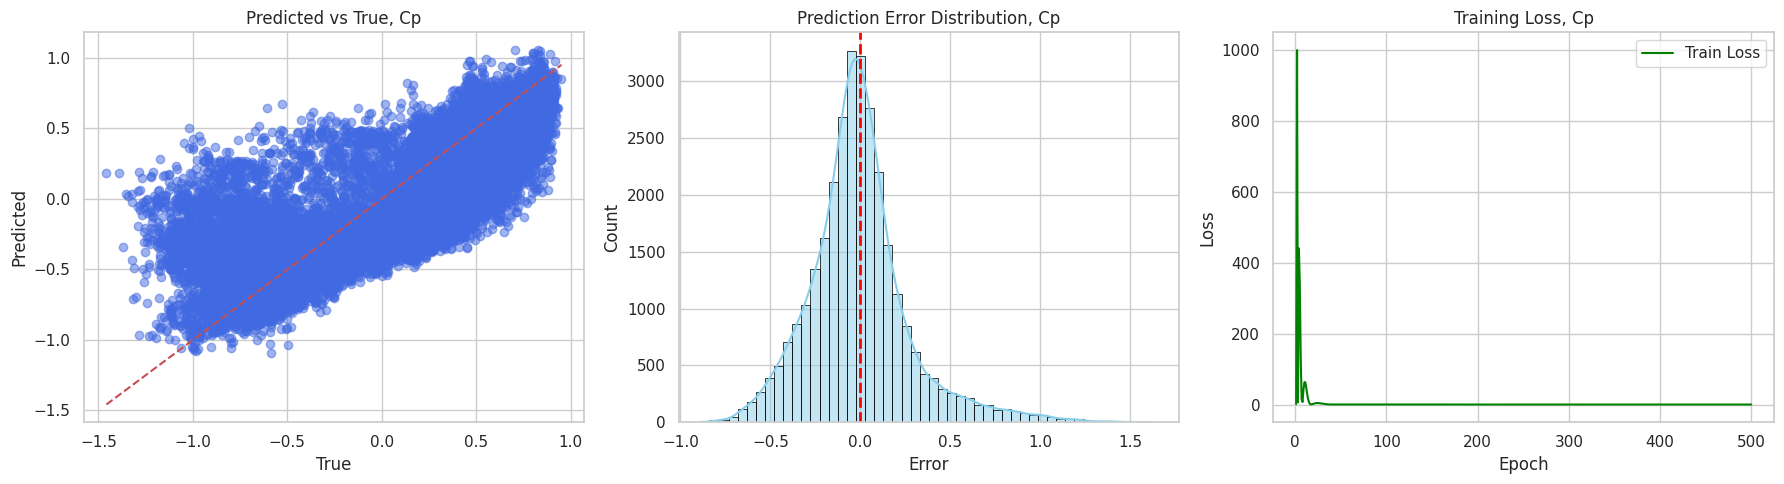

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 36/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 99.43it/s]

Epoch [10/500], Loss: 3.0502
Epoch [20/500], Loss: 1.5464
Epoch [30/500], Loss: 1.6588


Epochs:  11%|█         | 56/500 [00:00<00:04, 110.60it/s]

Epoch [40/500], Loss: 0.3586
Epoch [50/500], Loss: 0.2930
Epoch [60/500], Loss: 0.2478


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 114.24it/s]

Epoch [70/500], Loss: 0.2349
Epoch [80/500], Loss: 0.2247
Epoch [90/500], Loss: 0.2142


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 114.83it/s]

Epoch [100/500], Loss: 0.2098
Epoch [110/500], Loss: 0.2016
Epoch [120/500], Loss: 0.1889


Epochs:  30%|███       | 152/500 [00:01<00:03, 115.03it/s]

Epoch [130/500], Loss: 0.1730
Epoch [140/500], Loss: 0.1589
Epoch [150/500], Loss: 0.1464


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 114.66it/s]

Epoch [160/500], Loss: 0.1360
Epoch [170/500], Loss: 0.1277
Epoch [180/500], Loss: 0.1213


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 115.02it/s]

Epoch [190/500], Loss: 0.1144
Epoch [200/500], Loss: 0.1087
Epoch [210/500], Loss: 0.1043


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 113.77it/s]

Epoch [220/500], Loss: 0.1006
Epoch [230/500], Loss: 0.0974
Epoch [240/500], Loss: 0.0948


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 114.69it/s]

Epoch [250/500], Loss: 0.0926
Epoch [260/500], Loss: 0.0907
Epoch [270/500], Loss: 0.0891


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 114.75it/s]

Epoch [280/500], Loss: 0.0875
Epoch [290/500], Loss: 0.0862
Epoch [300/500], Loss: 0.0849


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 114.77it/s]

Epoch [310/500], Loss: 0.0837
Epoch [320/500], Loss: 0.0827
Epoch [330/500], Loss: 0.0816


Epochs:  71%|███████   | 356/500 [00:03<00:01, 114.89it/s]

Epoch [340/500], Loss: 0.0805
Epoch [350/500], Loss: 0.0795
Epoch [360/500], Loss: 0.0795


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 114.70it/s]

Epoch [370/500], Loss: 0.0780
Epoch [380/500], Loss: 0.0769
Epoch [390/500], Loss: 0.0762


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 114.68it/s]

Epoch [400/500], Loss: 0.0755
Epoch [410/500], Loss: 0.0749
Epoch [420/500], Loss: 0.0743


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 113.95it/s]

Epoch [430/500], Loss: 0.0736
Epoch [440/500], Loss: 0.0731
Epoch [450/500], Loss: 0.0724


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 114.35it/s]

Epoch [460/500], Loss: 0.0718
Epoch [470/500], Loss: 0.0708
Epoch [480/500], Loss: 0.0694


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.72it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0681
Epoch [500/500], Loss: 0.0671
📈 Evaluation metrics on test set:
MSE: 0.0679
MAE: 0.1834
R2: 0.7244


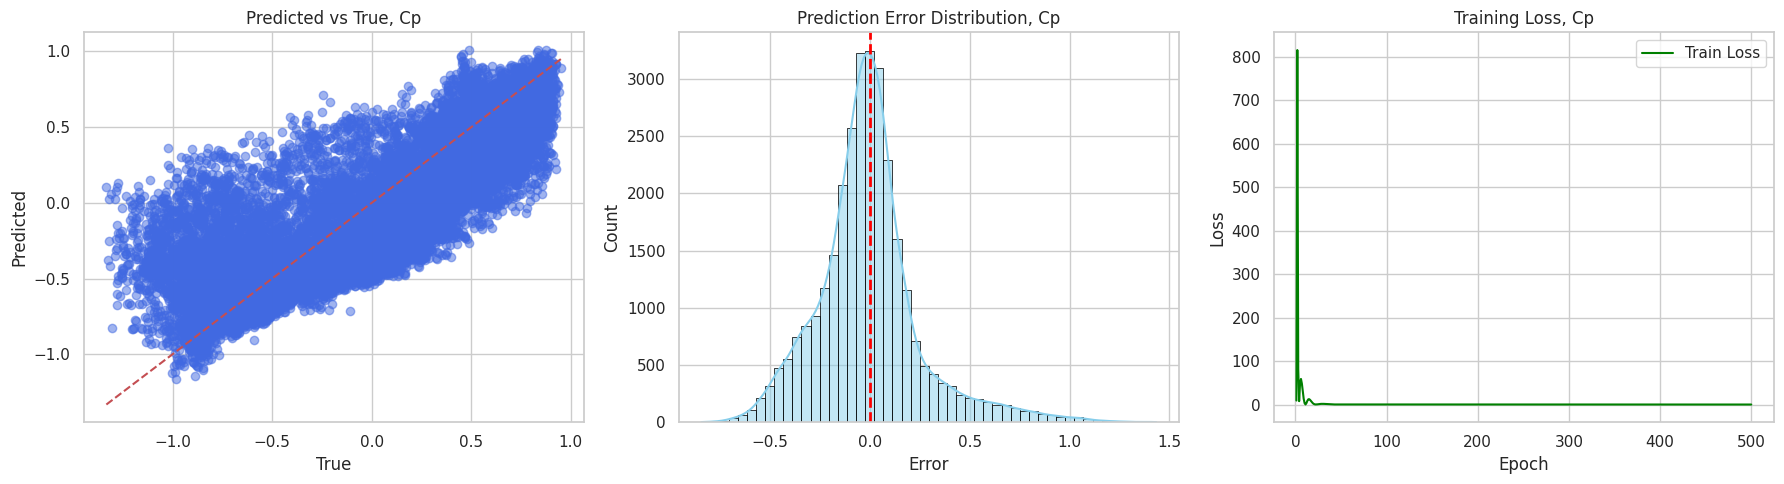

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 37/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.87it/s]

Epoch [10/500], Loss: 8.6786


Epochs:   4%|▍         | 20/500 [00:00<00:04, 96.30it/s]

Epoch [20/500], Loss: 4.3512
Epoch [30/500], Loss: 0.3069


Epochs:   6%|▌         | 31/500 [00:00<00:04, 98.95it/s]

Epoch [40/500], Loss: 0.3727


Epochs:  11%|█         | 55/500 [00:00<00:04, 107.81it/s]

Epoch [50/500], Loss: 0.2454
Epoch [60/500], Loss: 0.2337


Epochs:  13%|█▎        | 67/500 [00:00<00:03, 110.13it/s]

Epoch [70/500], Loss: 0.2219


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 112.78it/s]

Epoch [80/500], Loss: 0.2199
Epoch [90/500], Loss: 0.2031


Epochs:  21%|██        | 103/500 [00:00<00:03, 113.50it/s]

Epoch [100/500], Loss: 0.1945


Epochs:  23%|██▎       | 115/500 [00:01<00:03, 113.41it/s]

Epoch [110/500], Loss: 0.1888
Epoch [120/500], Loss: 0.1794


Epochs:  25%|██▌       | 127/500 [00:01<00:03, 113.66it/s]

Epoch [130/500], Loss: 0.1663


Epochs:  30%|███       | 151/500 [00:01<00:03, 114.05it/s]

Epoch [140/500], Loss: 0.1630
Epoch [150/500], Loss: 0.1728


Epochs:  33%|███▎      | 163/500 [00:01<00:02, 113.98it/s]

Epoch [160/500], Loss: 0.1312


Epochs:  35%|███▌      | 175/500 [00:01<00:02, 114.13it/s]

Epoch [170/500], Loss: 0.1199
Epoch [180/500], Loss: 0.1109


Epochs:  37%|███▋      | 187/500 [00:01<00:02, 114.40it/s]

Epoch [190/500], Loss: 0.1069


Epochs:  42%|████▏     | 211/500 [00:01<00:02, 114.92it/s]

Epoch [200/500], Loss: 0.1054
Epoch [210/500], Loss: 0.1037


Epochs:  45%|████▍     | 223/500 [00:01<00:02, 114.71it/s]

Epoch [220/500], Loss: 0.1027


Epochs:  47%|████▋     | 235/500 [00:02<00:02, 114.67it/s]

Epoch [230/500], Loss: 0.1038
Epoch [240/500], Loss: 0.1007


Epochs:  49%|████▉     | 247/500 [00:02<00:02, 114.87it/s]

Epoch [250/500], Loss: 0.0977


Epochs:  54%|█████▍    | 271/500 [00:02<00:02, 113.73it/s]

Epoch [260/500], Loss: 0.0940
Epoch [270/500], Loss: 0.0973


Epochs:  57%|█████▋    | 283/500 [00:02<00:01, 114.12it/s]

Epoch [280/500], Loss: 0.0888


Epochs:  59%|█████▉    | 295/500 [00:02<00:01, 113.71it/s]

Epoch [290/500], Loss: 0.0860
Epoch [300/500], Loss: 0.0846


Epochs:  61%|██████▏   | 307/500 [00:02<00:01, 113.61it/s]

Epoch [310/500], Loss: 0.0849


Epochs:  66%|██████▌   | 331/500 [00:02<00:01, 114.04it/s]

Epoch [320/500], Loss: 0.0831
Epoch [330/500], Loss: 0.0816


Epochs:  69%|██████▊   | 343/500 [00:03<00:01, 114.36it/s]

Epoch [340/500], Loss: 0.0806


Epochs:  71%|███████   | 355/500 [00:03<00:01, 114.42it/s]

Epoch [350/500], Loss: 0.0798
Epoch [360/500], Loss: 0.0792


Epochs:  73%|███████▎  | 367/500 [00:03<00:01, 114.15it/s]

Epoch [370/500], Loss: 0.0797


Epochs:  78%|███████▊  | 391/500 [00:03<00:00, 114.41it/s]

Epoch [380/500], Loss: 0.0781
Epoch [390/500], Loss: 0.0776
Epoch [400/500], Loss: 0.0776


Epochs:  83%|████████▎ | 415/500 [00:03<00:00, 113.61it/s]

Epoch [410/500], Loss: 0.0768
Epoch [420/500], Loss: 0.0761


Epochs:  85%|████████▌ | 427/500 [00:03<00:00, 113.86it/s]

Epoch [430/500], Loss: 0.0755


Epochs:  90%|█████████ | 451/500 [00:03<00:00, 114.07it/s]

Epoch [440/500], Loss: 0.0751
Epoch [450/500], Loss: 0.0746
Epoch [460/500], Loss: 0.0741


Epochs:  95%|█████████▌| 475/500 [00:04<00:00, 114.19it/s]

Epoch [470/500], Loss: 0.0796
Epoch [480/500], Loss: 0.0757


Epochs:  97%|█████████▋| 487/500 [00:04<00:00, 113.79it/s]

Epoch [490/500], Loss: 0.0732


Epochs: 100%|██████████| 500/500 [00:04<00:00, 112.97it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0723
📈 Evaluation metrics on test set:
MSE: 0.0736
MAE: 0.1900
R2: 0.7065


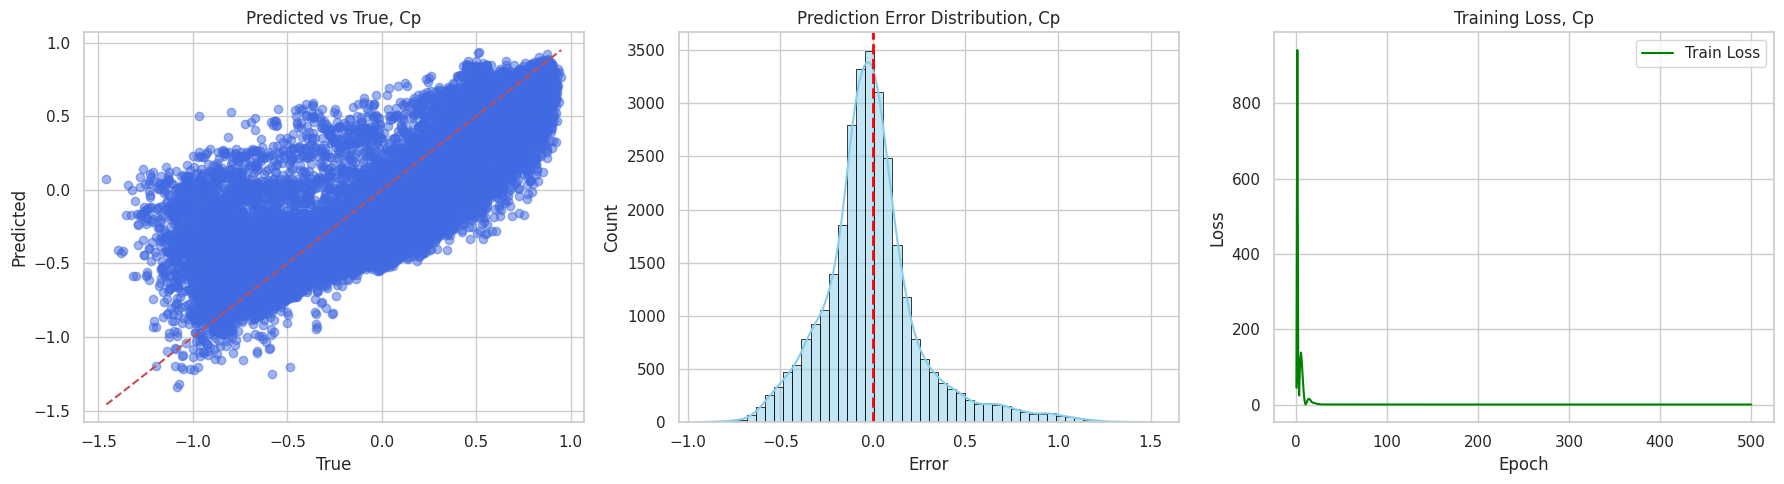

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 38/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 12/500 [00:00<00:04, 119.85it/s]

Epoch [10/500], Loss: 3.1183
Epoch [20/500], Loss: 2.5908


Epochs:   5%|▍         | 24/500 [00:00<00:04, 115.52it/s]

Epoch [30/500], Loss: 2.4780


Epochs:  10%|▉         | 48/500 [00:00<00:03, 114.60it/s]

Epoch [40/500], Loss: 0.3174
Epoch [50/500], Loss: 0.2409


Epochs:  12%|█▏        | 60/500 [00:00<00:03, 114.17it/s]

Epoch [60/500], Loss: 0.2338


Epochs:  14%|█▍        | 72/500 [00:00<00:03, 113.97it/s]

Epoch [70/500], Loss: 0.2174
Epoch [80/500], Loss: 0.2087


Epochs:  17%|█▋        | 84/500 [00:00<00:03, 113.93it/s]

Epoch [90/500], Loss: 0.2053


Epochs:  22%|██▏       | 108/500 [00:00<00:03, 113.69it/s]

Epoch [100/500], Loss: 0.1996
Epoch [110/500], Loss: 0.1810


Epochs:  24%|██▍       | 120/500 [00:01<00:03, 113.12it/s]

Epoch [120/500], Loss: 0.1552


Epochs:  26%|██▋       | 132/500 [00:01<00:03, 113.29it/s]

Epoch [130/500], Loss: 0.1425
Epoch [140/500], Loss: 0.1318


Epochs:  29%|██▉       | 144/500 [00:01<00:03, 113.47it/s]

Epoch [150/500], Loss: 0.1226


Epochs:  34%|███▎      | 168/500 [00:01<00:02, 113.15it/s]

Epoch [160/500], Loss: 0.1154
Epoch [170/500], Loss: 0.1122


Epochs:  36%|███▌      | 180/500 [00:01<00:02, 113.18it/s]

Epoch [180/500], Loss: 0.1102


Epochs:  38%|███▊      | 192/500 [00:01<00:02, 113.00it/s]

Epoch [190/500], Loss: 0.1069
Epoch [200/500], Loss: 0.1057


Epochs:  41%|████      | 204/500 [00:01<00:02, 112.77it/s]

Epoch [210/500], Loss: 0.1042


Epochs:  46%|████▌     | 228/500 [00:02<00:02, 113.04it/s]

Epoch [220/500], Loss: 0.1029
Epoch [230/500], Loss: 0.1022


Epochs:  48%|████▊     | 240/500 [00:02<00:02, 112.73it/s]

Epoch [240/500], Loss: 0.1009


Epochs:  50%|█████     | 252/500 [00:02<00:02, 112.77it/s]

Epoch [250/500], Loss: 0.0990
Epoch [260/500], Loss: 0.0978


Epochs:  53%|█████▎    | 264/500 [00:02<00:02, 112.85it/s]

Epoch [270/500], Loss: 0.0933


Epochs:  58%|█████▊    | 288/500 [00:02<00:01, 113.16it/s]

Epoch [280/500], Loss: 0.0877
Epoch [290/500], Loss: 0.0855


Epochs:  60%|██████    | 300/500 [00:02<00:01, 113.25it/s]

Epoch [300/500], Loss: 0.0838


Epochs:  62%|██████▏   | 312/500 [00:02<00:01, 113.02it/s]

Epoch [310/500], Loss: 0.0821
Epoch [320/500], Loss: 0.0811


Epochs:  65%|██████▍   | 324/500 [00:02<00:01, 113.47it/s]

Epoch [330/500], Loss: 0.0796


Epochs:  70%|██████▉   | 348/500 [00:03<00:01, 113.46it/s]

Epoch [340/500], Loss: 0.0786
Epoch [350/500], Loss: 0.0794


Epochs:  72%|███████▏  | 360/500 [00:03<00:01, 113.28it/s]

Epoch [360/500], Loss: 0.0784


Epochs:  74%|███████▍  | 372/500 [00:03<00:01, 112.94it/s]

Epoch [370/500], Loss: 0.0778
Epoch [380/500], Loss: 0.0789


Epochs:  77%|███████▋  | 384/500 [00:03<00:01, 112.92it/s]

Epoch [390/500], Loss: 0.0788


Epochs:  82%|████████▏ | 408/500 [00:03<00:00, 112.18it/s]

Epoch [400/500], Loss: 0.0763
Epoch [410/500], Loss: 0.0777


Epochs:  84%|████████▍ | 420/500 [00:03<00:00, 112.22it/s]

Epoch [420/500], Loss: 0.0756


Epochs:  86%|████████▋ | 432/500 [00:03<00:00, 112.65it/s]

Epoch [430/500], Loss: 0.0748
Epoch [440/500], Loss: 0.0745


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 112.80it/s]

Epoch [450/500], Loss: 0.0743


Epochs:  94%|█████████▎| 468/500 [00:04<00:00, 112.84it/s]

Epoch [460/500], Loss: 0.0739
Epoch [470/500], Loss: 0.0737


Epochs:  96%|█████████▌| 480/500 [00:04<00:00, 112.80it/s]

Epoch [480/500], Loss: 0.0744


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.19it/s]

Epoch [490/500], Loss: 0.0749
Epoch [500/500], Loss: 0.0733
📈 Evaluation metrics on test set:
MSE: 0.0722
MAE: 0.1858
R2: 0.7060



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


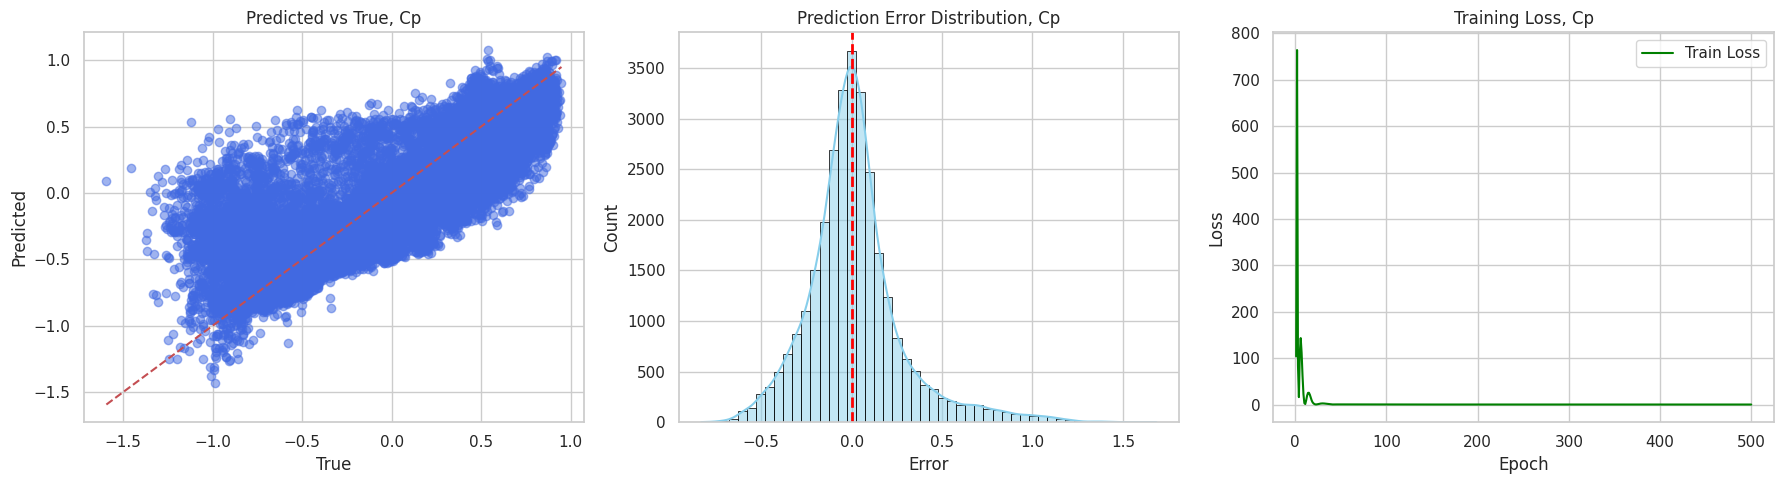

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 39/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 97.31it/s]

Epoch [10/500], Loss: 0.8051
Epoch [20/500], Loss: 1.3205
Epoch [30/500], Loss: 1.3663


Epochs:  11%|█▏        | 57/500 [00:00<00:03, 110.90it/s]

Epoch [40/500], Loss: 0.3721
Epoch [50/500], Loss: 0.3445
Epoch [60/500], Loss: 0.2586


Epochs:  16%|█▌        | 81/500 [00:00<00:03, 112.66it/s]

Epoch [70/500], Loss: 0.2334
Epoch [80/500], Loss: 0.2178
Epoch [90/500], Loss: 0.2019


Epochs:  23%|██▎       | 117/500 [00:01<00:03, 113.71it/s]

Epoch [100/500], Loss: 0.1849
Epoch [110/500], Loss: 0.1628
Epoch [120/500], Loss: 0.1482


Epochs:  28%|██▊       | 141/500 [00:01<00:03, 113.34it/s]

Epoch [130/500], Loss: 0.1352
Epoch [140/500], Loss: 0.1250
Epoch [150/500], Loss: 0.1169


Epochs:  35%|███▌      | 177/500 [00:01<00:02, 113.28it/s]

Epoch [160/500], Loss: 0.1115
Epoch [170/500], Loss: 0.1079
Epoch [180/500], Loss: 0.1046


Epochs:  40%|████      | 201/500 [00:01<00:02, 113.73it/s]

Epoch [190/500], Loss: 0.1026
Epoch [200/500], Loss: 0.1001
Epoch [210/500], Loss: 0.0968


Epochs:  47%|████▋     | 237/500 [00:02<00:02, 113.90it/s]

Epoch [220/500], Loss: 0.0949
Epoch [230/500], Loss: 0.0932
Epoch [240/500], Loss: 0.0915


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 113.70it/s]

Epoch [250/500], Loss: 0.0900
Epoch [260/500], Loss: 0.0885
Epoch [270/500], Loss: 0.0871


Epochs:  59%|█████▉    | 297/500 [00:02<00:01, 113.66it/s]

Epoch [280/500], Loss: 0.0858
Epoch [290/500], Loss: 0.0860
Epoch [300/500], Loss: 0.0834


Epochs:  64%|██████▍   | 321/500 [00:02<00:01, 113.31it/s]

Epoch [310/500], Loss: 0.0825
Epoch [320/500], Loss: 0.0816
Epoch [330/500], Loss: 0.0806


Epochs:  71%|███████▏  | 357/500 [00:03<00:01, 113.65it/s]

Epoch [340/500], Loss: 0.0798
Epoch [350/500], Loss: 0.0792
Epoch [360/500], Loss: 0.0784


Epochs:  76%|███████▌  | 381/500 [00:03<00:01, 113.78it/s]

Epoch [370/500], Loss: 0.0778
Epoch [380/500], Loss: 0.0770
Epoch [390/500], Loss: 0.0764


Epochs:  83%|████████▎ | 417/500 [00:03<00:00, 113.43it/s]

Epoch [400/500], Loss: 0.0791
Epoch [410/500], Loss: 0.0761
Epoch [420/500], Loss: 0.0756


Epochs:  91%|█████████ | 453/500 [00:04<00:00, 114.08it/s]

Epoch [430/500], Loss: 0.0742
Epoch [440/500], Loss: 0.0731
Epoch [450/500], Loss: 0.0726


Epochs:  95%|█████████▌| 477/500 [00:04<00:00, 113.45it/s]

Epoch [460/500], Loss: 0.0721
Epoch [470/500], Loss: 0.0717
Epoch [480/500], Loss: 0.0713


Epochs: 100%|██████████| 500/500 [00:04<00:00, 112.89it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0709
Epoch [500/500], Loss: 0.0704
📈 Evaluation metrics on test set:
MSE: 0.0696
MAE: 0.1825
R2: 0.7151


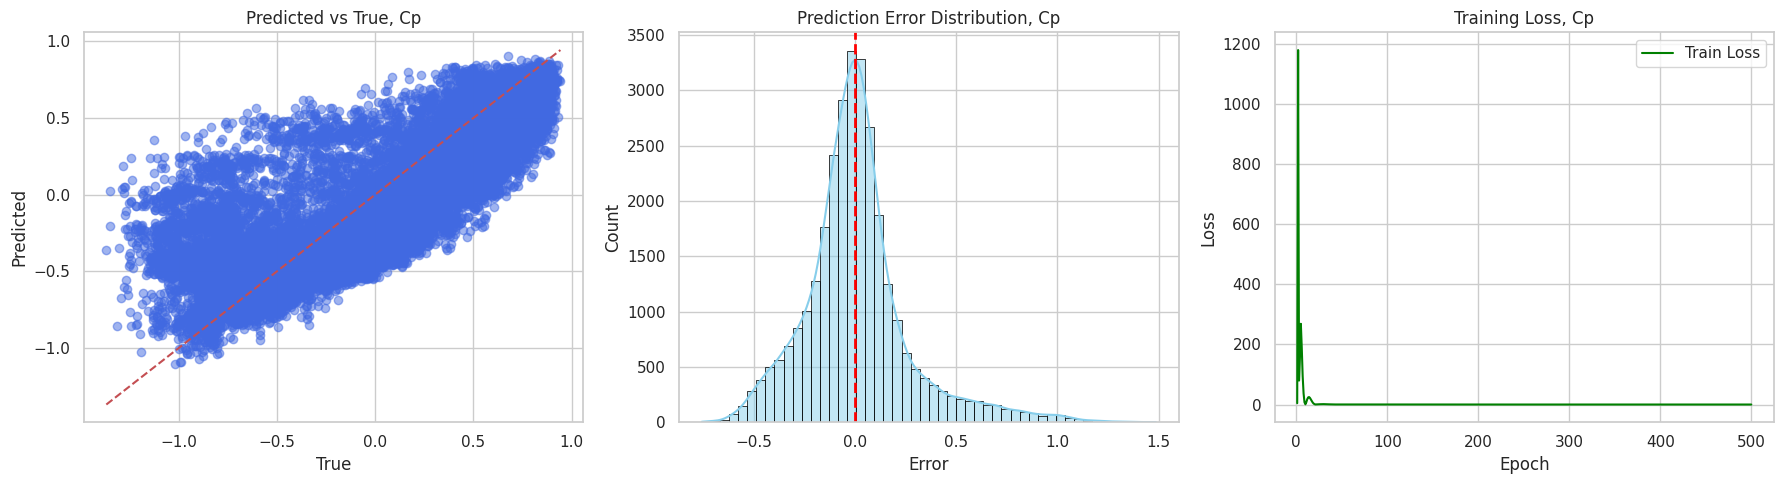

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 40/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 99.38it/s]

Epoch [10/500], Loss: 11.0032
Epoch [20/500], Loss: 0.6074
Epoch [30/500], Loss: 0.3561


Epochs:  11%|█         | 56/500 [00:00<00:04, 110.15it/s]

Epoch [40/500], Loss: 0.2534
Epoch [50/500], Loss: 0.2175
Epoch [60/500], Loss: 0.2047


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 112.63it/s]

Epoch [70/500], Loss: 0.2012
Epoch [80/500], Loss: 0.1885
Epoch [90/500], Loss: 0.1752


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 113.34it/s]

Epoch [100/500], Loss: 0.1451
Epoch [110/500], Loss: 0.1869
Epoch [120/500], Loss: 0.1645


Epochs:  30%|███       | 152/500 [00:01<00:03, 113.78it/s]

Epoch [130/500], Loss: 0.1492
Epoch [140/500], Loss: 0.1390
Epoch [150/500], Loss: 0.1297


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 114.07it/s]

Epoch [160/500], Loss: 0.1248
Epoch [170/500], Loss: 0.1192
Epoch [180/500], Loss: 0.1141


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 113.16it/s]

Epoch [190/500], Loss: 0.1109
Epoch [200/500], Loss: 0.1083
Epoch [210/500], Loss: 0.1062


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 113.42it/s]

Epoch [220/500], Loss: 0.1043
Epoch [230/500], Loss: 0.1027
Epoch [240/500], Loss: 0.1012


Epochs:  54%|█████▍    | 272/500 [00:02<00:02, 113.84it/s]

Epoch [250/500], Loss: 0.0998
Epoch [260/500], Loss: 0.0985
Epoch [270/500], Loss: 0.0972


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 113.96it/s]

Epoch [280/500], Loss: 0.0958
Epoch [290/500], Loss: 0.0945
Epoch [300/500], Loss: 0.0937


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 113.58it/s]

Epoch [310/500], Loss: 0.0925
Epoch [320/500], Loss: 0.0905
Epoch [330/500], Loss: 0.0884


Epochs:  71%|███████   | 356/500 [00:03<00:01, 113.58it/s]

Epoch [340/500], Loss: 0.0867
Epoch [350/500], Loss: 0.0851
Epoch [360/500], Loss: 0.0854


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 113.66it/s]

Epoch [370/500], Loss: 0.0833
Epoch [380/500], Loss: 0.0827
Epoch [390/500], Loss: 0.0818


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 113.89it/s]

Epoch [400/500], Loss: 0.0809
Epoch [410/500], Loss: 0.0802
Epoch [420/500], Loss: 0.0796


Epochs:  90%|█████████ | 452/500 [00:04<00:00, 113.72it/s]

Epoch [430/500], Loss: 0.0790
Epoch [440/500], Loss: 0.0784
Epoch [450/500], Loss: 0.0779


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 113.57it/s]

Epoch [460/500], Loss: 0.0812
Epoch [470/500], Loss: 0.0777
Epoch [480/500], Loss: 0.0772


Epochs: 100%|██████████| 500/500 [00:04<00:00, 112.75it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0765
Epoch [500/500], Loss: 0.0760
📈 Evaluation metrics on test set:
MSE: 0.0746
MAE: 0.1926
R2: 0.7010


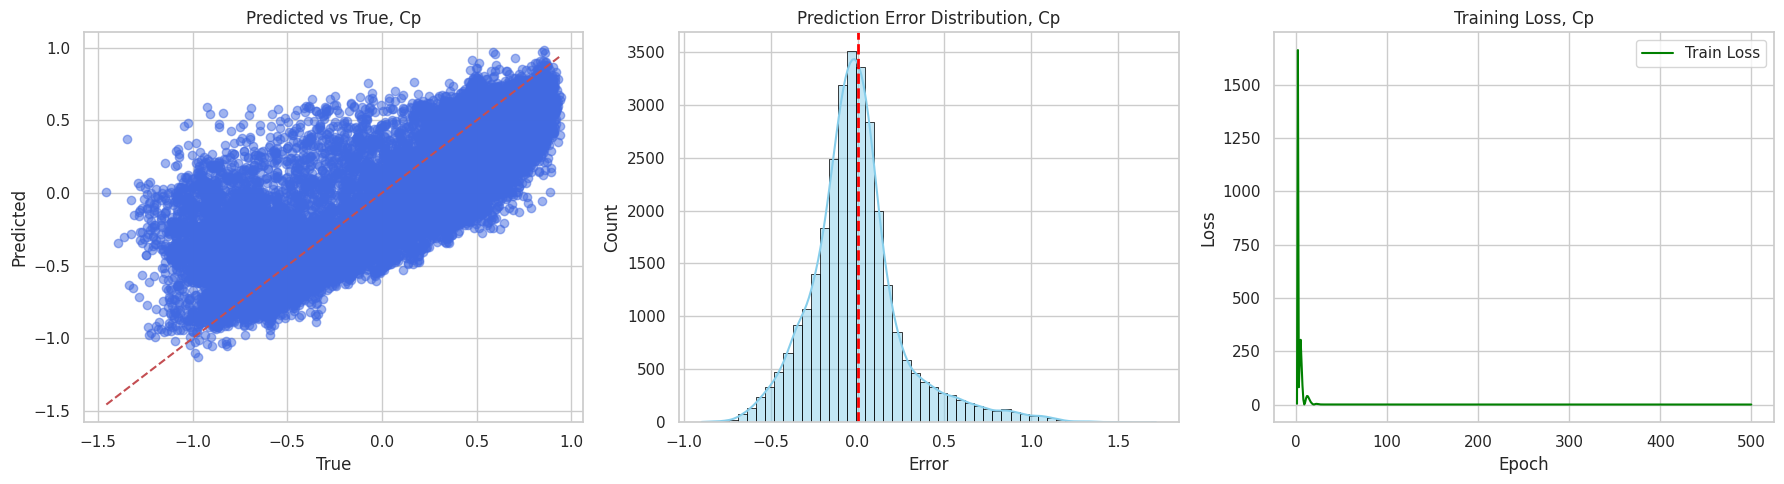

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 41/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.49it/s]

Epoch [10/500], Loss: 25.0162


Epochs:   4%|▍         | 20/500 [00:00<00:05, 90.57it/s]

Epoch [20/500], Loss: 0.2542


Epochs:   6%|▌         | 31/500 [00:00<00:04, 97.69it/s]

Epoch [30/500], Loss: 0.2203
Epoch [40/500], Loss: 0.2271


Epochs:   9%|▊         | 43/500 [00:00<00:04, 104.63it/s]

Epoch [50/500], Loss: 0.2025


Epochs:  13%|█▎        | 67/500 [00:00<00:03, 110.75it/s]

Epoch [60/500], Loss: 0.1958
Epoch [70/500], Loss: 0.1890


Epochs:  16%|█▌        | 79/500 [00:00<00:03, 112.15it/s]

Epoch [80/500], Loss: 0.2693


Epochs:  21%|██        | 103/500 [00:00<00:03, 113.48it/s]

Epoch [90/500], Loss: 0.1806
Epoch [100/500], Loss: 0.2289
Epoch [110/500], Loss: 0.1647


Epochs:  25%|██▌       | 127/500 [00:01<00:03, 113.30it/s]

Epoch [120/500], Loss: 0.1699
Epoch [130/500], Loss: 0.1567


Epochs:  28%|██▊       | 139/500 [00:01<00:03, 113.25it/s]

Epoch [140/500], Loss: 0.1490


Epochs:  30%|███       | 151/500 [00:01<00:03, 112.89it/s]

Epoch [150/500], Loss: 0.1445
Epoch [160/500], Loss: 0.1415


Epochs:  33%|███▎      | 163/500 [00:01<00:02, 113.06it/s]

Epoch [170/500], Loss: 0.1393


Epochs:  37%|███▋      | 187/500 [00:01<00:02, 113.43it/s]

Epoch [180/500], Loss: 0.1376
Epoch [190/500], Loss: 0.1358


Epochs:  40%|███▉      | 199/500 [00:01<00:02, 113.97it/s]

Epoch [200/500], Loss: 0.1342


Epochs:  42%|████▏     | 211/500 [00:01<00:02, 113.61it/s]

Epoch [210/500], Loss: 0.1323
Epoch [220/500], Loss: 0.1292


Epochs:  45%|████▍     | 223/500 [00:02<00:02, 113.46it/s]

Epoch [230/500], Loss: 0.1257


Epochs:  49%|████▉     | 247/500 [00:02<00:02, 113.23it/s]

Epoch [240/500], Loss: 0.1216
Epoch [250/500], Loss: 0.1179


Epochs:  52%|█████▏    | 259/500 [00:02<00:02, 113.63it/s]

Epoch [260/500], Loss: 0.1149


Epochs:  57%|█████▋    | 283/500 [00:02<00:01, 114.12it/s]

Epoch [270/500], Loss: 0.1128
Epoch [280/500], Loss: 0.1108
Epoch [290/500], Loss: 0.1094


Epochs:  61%|██████▏   | 307/500 [00:02<00:01, 114.31it/s]

Epoch [300/500], Loss: 0.1083
Epoch [310/500], Loss: 0.1067


Epochs:  64%|██████▍   | 319/500 [00:02<00:01, 113.92it/s]

Epoch [320/500], Loss: 0.1063


Epochs:  69%|██████▊   | 343/500 [00:03<00:01, 114.40it/s]

Epoch [330/500], Loss: 0.1050
Epoch [340/500], Loss: 0.1039
Epoch [350/500], Loss: 0.1032


Epochs:  73%|███████▎  | 367/500 [00:03<00:01, 114.25it/s]

Epoch [360/500], Loss: 0.1026
Epoch [370/500], Loss: 0.1019


Epochs:  76%|███████▌  | 379/500 [00:03<00:01, 114.40it/s]

Epoch [380/500], Loss: 0.1444


Epochs:  78%|███████▊  | 391/500 [00:03<00:00, 113.81it/s]

Epoch [390/500], Loss: 0.1187
Epoch [400/500], Loss: 0.1034


Epochs:  81%|████████  | 403/500 [00:03<00:00, 113.75it/s]

Epoch [410/500], Loss: 0.1014


Epochs:  85%|████████▌ | 427/500 [00:03<00:00, 113.69it/s]

Epoch [420/500], Loss: 0.1012
Epoch [430/500], Loss: 0.1005


Epochs:  88%|████████▊ | 439/500 [00:03<00:00, 114.03it/s]

Epoch [440/500], Loss: 0.1000


Epochs:  90%|█████████ | 451/500 [00:04<00:00, 113.52it/s]

Epoch [450/500], Loss: 0.0995
Epoch [460/500], Loss: 0.0991


Epochs:  93%|█████████▎| 463/500 [00:04<00:00, 113.61it/s]

Epoch [470/500], Loss: 0.0987


Epochs:  97%|█████████▋| 487/500 [00:04<00:00, 113.88it/s]

Epoch [480/500], Loss: 0.0984
Epoch [490/500], Loss: 0.0980


Epochs: 100%|██████████| 500/500 [00:04<00:00, 112.62it/s]

Epoch [500/500], Loss: 0.0977
📈 Evaluation metrics on test set:
MSE: 0.0977
MAE: 0.2241
R2: 0.6065



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


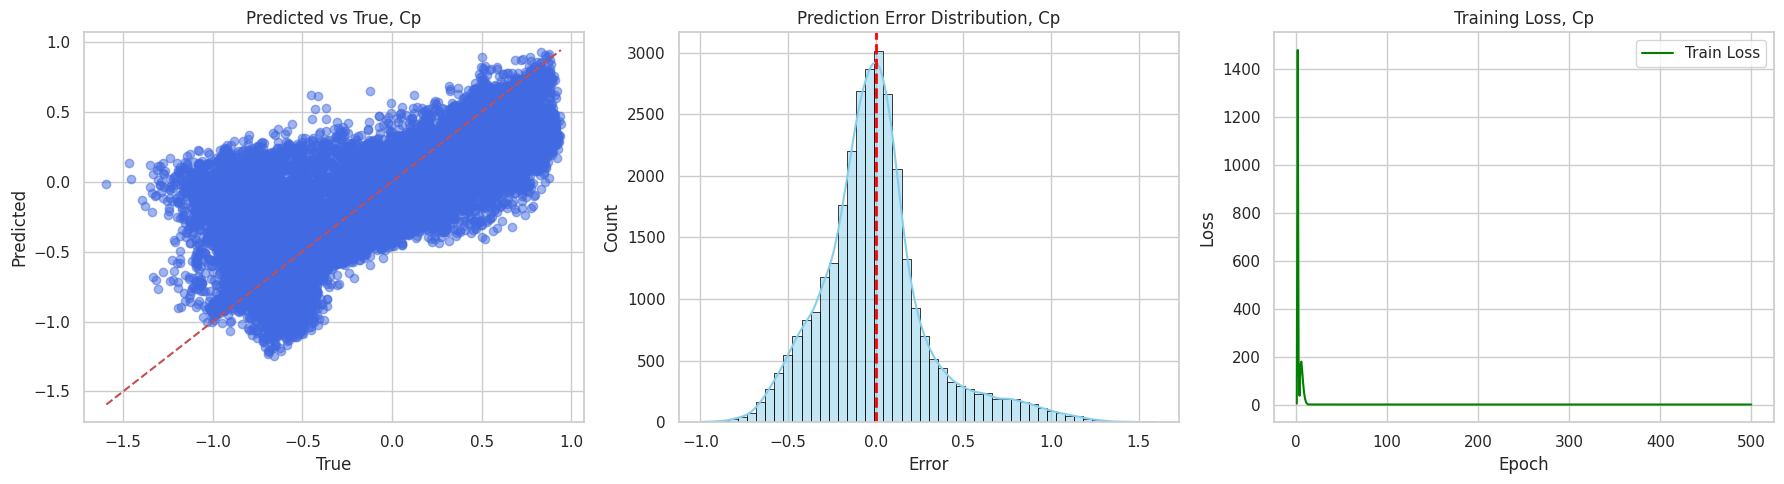

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 42/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.59it/s]

Epoch [10/500], Loss: 29.5162


Epochs:   4%|▍         | 20/500 [00:00<00:05, 94.29it/s]

Epoch [20/500], Loss: 0.4241
Epoch [30/500], Loss: 0.4565


Epochs:   6%|▋         | 32/500 [00:00<00:04, 104.20it/s]

Epoch [40/500], Loss: 0.3899


Epochs:  11%|█         | 56/500 [00:00<00:03, 111.45it/s]

Epoch [50/500], Loss: 0.3105
Epoch [60/500], Loss: 0.2831


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 113.41it/s]

Epoch [70/500], Loss: 0.2714


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 115.62it/s]

Epoch [80/500], Loss: 0.2571
Epoch [90/500], Loss: 0.2367
Epoch [100/500], Loss: 0.2176


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 115.79it/s]

Epoch [110/500], Loss: 0.2114
Epoch [120/500], Loss: 0.1968


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 115.89it/s]

Epoch [130/500], Loss: 0.1905


Epochs:  30%|███       | 152/500 [00:01<00:03, 115.80it/s]

Epoch [140/500], Loss: 0.1870
Epoch [150/500], Loss: 0.1844
Epoch [160/500], Loss: 0.1806


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 115.45it/s]

Epoch [170/500], Loss: 0.1696
Epoch [180/500], Loss: 0.1565


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 115.65it/s]

Epoch [190/500], Loss: 0.1468


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 115.64it/s]

Epoch [200/500], Loss: 0.1425
Epoch [210/500], Loss: 0.1394
Epoch [220/500], Loss: 0.1386


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 115.74it/s]

Epoch [230/500], Loss: 0.1355
Epoch [240/500], Loss: 0.1334


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 115.66it/s]

Epoch [250/500], Loss: 0.1308


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 115.86it/s]

Epoch [260/500], Loss: 0.1286
Epoch [270/500], Loss: 0.1273
Epoch [280/500], Loss: 0.1258


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 115.57it/s]

Epoch [290/500], Loss: 0.1241
Epoch [300/500], Loss: 0.1348


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 115.49it/s]

Epoch [310/500], Loss: 0.1244


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 115.28it/s]

Epoch [320/500], Loss: 0.1214
Epoch [330/500], Loss: 0.1193
Epoch [340/500], Loss: 0.1176


Epochs:  71%|███████   | 356/500 [00:03<00:01, 115.46it/s]

Epoch [350/500], Loss: 0.1166
Epoch [360/500], Loss: 0.1168


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 115.48it/s]

Epoch [370/500], Loss: 0.1213


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 115.35it/s]

Epoch [380/500], Loss: 0.1141
Epoch [390/500], Loss: 0.1136
Epoch [400/500], Loss: 0.1115


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 115.52it/s]

Epoch [410/500], Loss: 0.1104
Epoch [420/500], Loss: 0.1094


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 115.57it/s]

Epoch [430/500], Loss: 0.1085


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 115.65it/s]

Epoch [440/500], Loss: 0.1075
Epoch [450/500], Loss: 0.1068
Epoch [460/500], Loss: 0.1233


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 115.68it/s]

Epoch [470/500], Loss: 0.1059
Epoch [480/500], Loss: 0.1059


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 115.45it/s]

Epoch [490/500], Loss: 0.1033


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.65it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.1024
📈 Evaluation metrics on test set:
MSE: 0.1039
MAE: 0.2362
R2: 0.5785


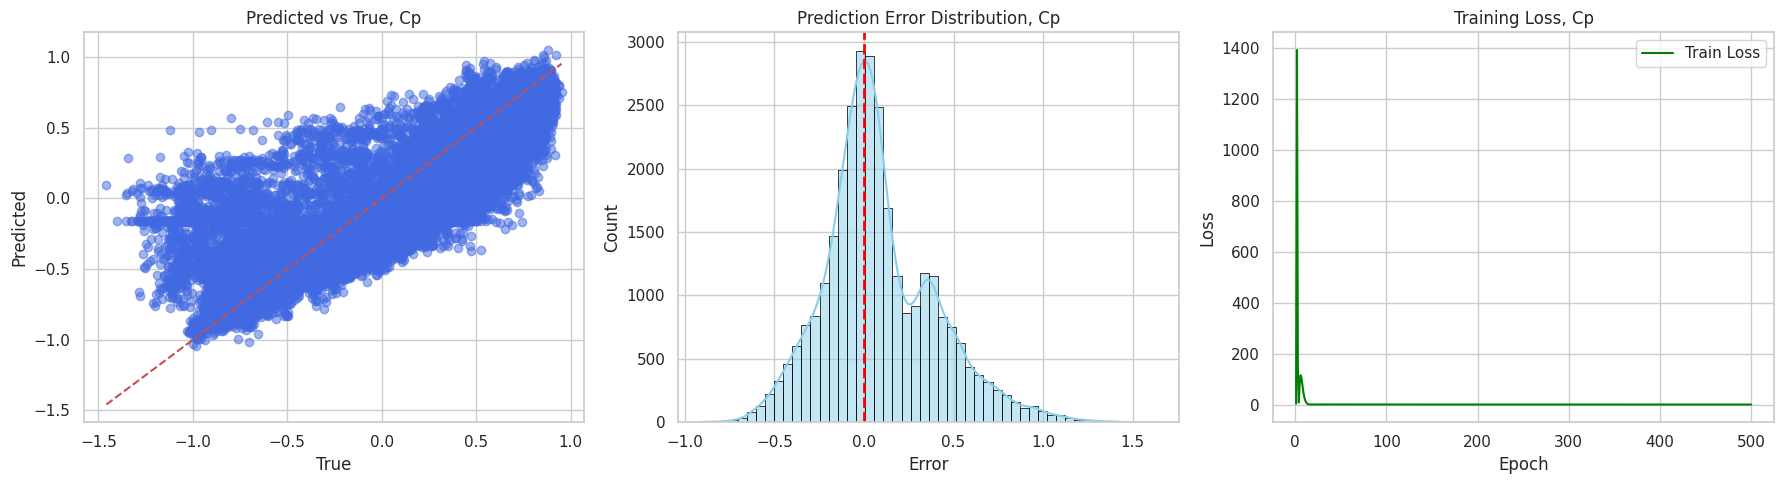

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 43/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 20/500 [00:00<00:05, 94.48it/s]

Epoch [10/500], Loss: 32.1753
Epoch [20/500], Loss: 2.4435
Epoch [30/500], Loss: 1.3393


Epochs:  11%|█         | 56/500 [00:00<00:04, 110.62it/s]

Epoch [40/500], Loss: 0.3380
Epoch [50/500], Loss: 0.3107
Epoch [60/500], Loss: 0.2498


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 113.29it/s]

Epoch [70/500], Loss: 0.2335
Epoch [80/500], Loss: 0.2262
Epoch [90/500], Loss: 0.2217


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 114.02it/s]

Epoch [100/500], Loss: 0.2256
Epoch [110/500], Loss: 0.2187
Epoch [120/500], Loss: 0.2151


Epochs:  30%|███       | 152/500 [00:01<00:03, 113.95it/s]

Epoch [130/500], Loss: 0.2122
Epoch [140/500], Loss: 0.2100
Epoch [150/500], Loss: 0.2082


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 113.56it/s]

Epoch [160/500], Loss: 0.2067
Epoch [170/500], Loss: 0.2051
Epoch [180/500], Loss: 0.2034


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 113.88it/s]

Epoch [190/500], Loss: 0.2017
Epoch [200/500], Loss: 0.2000
Epoch [210/500], Loss: 0.1982


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 113.89it/s]

Epoch [220/500], Loss: 0.1945
Epoch [230/500], Loss: 0.1893
Epoch [240/500], Loss: 0.1820


Epochs:  54%|█████▍    | 272/500 [00:02<00:02, 113.84it/s]

Epoch [250/500], Loss: 0.1635
Epoch [260/500], Loss: 0.1437
Epoch [270/500], Loss: 0.1261


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 114.15it/s]

Epoch [280/500], Loss: 0.1156
Epoch [290/500], Loss: 0.1088
Epoch [300/500], Loss: 0.1045


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 113.83it/s]

Epoch [310/500], Loss: 0.1012
Epoch [320/500], Loss: 0.1198
Epoch [330/500], Loss: 0.1065


Epochs:  71%|███████   | 356/500 [00:03<00:01, 114.04it/s]

Epoch [340/500], Loss: 0.1009
Epoch [350/500], Loss: 0.0967
Epoch [360/500], Loss: 0.0941


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 113.40it/s]

Epoch [370/500], Loss: 0.0917
Epoch [380/500], Loss: 0.0897
Epoch [390/500], Loss: 0.0878


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 114.01it/s]

Epoch [400/500], Loss: 0.0863
Epoch [410/500], Loss: 0.0849
Epoch [420/500], Loss: 0.0838


Epochs:  90%|█████████ | 452/500 [00:04<00:00, 113.74it/s]

Epoch [430/500], Loss: 0.0828
Epoch [440/500], Loss: 0.0818
Epoch [450/500], Loss: 0.0809


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 114.07it/s]

Epoch [460/500], Loss: 0.0800
Epoch [470/500], Loss: 0.0792
Epoch [480/500], Loss: 0.0784


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.06it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0777
Epoch [500/500], Loss: 0.0770
📈 Evaluation metrics on test set:
MSE: 0.0763
MAE: 0.1970
R2: 0.6921


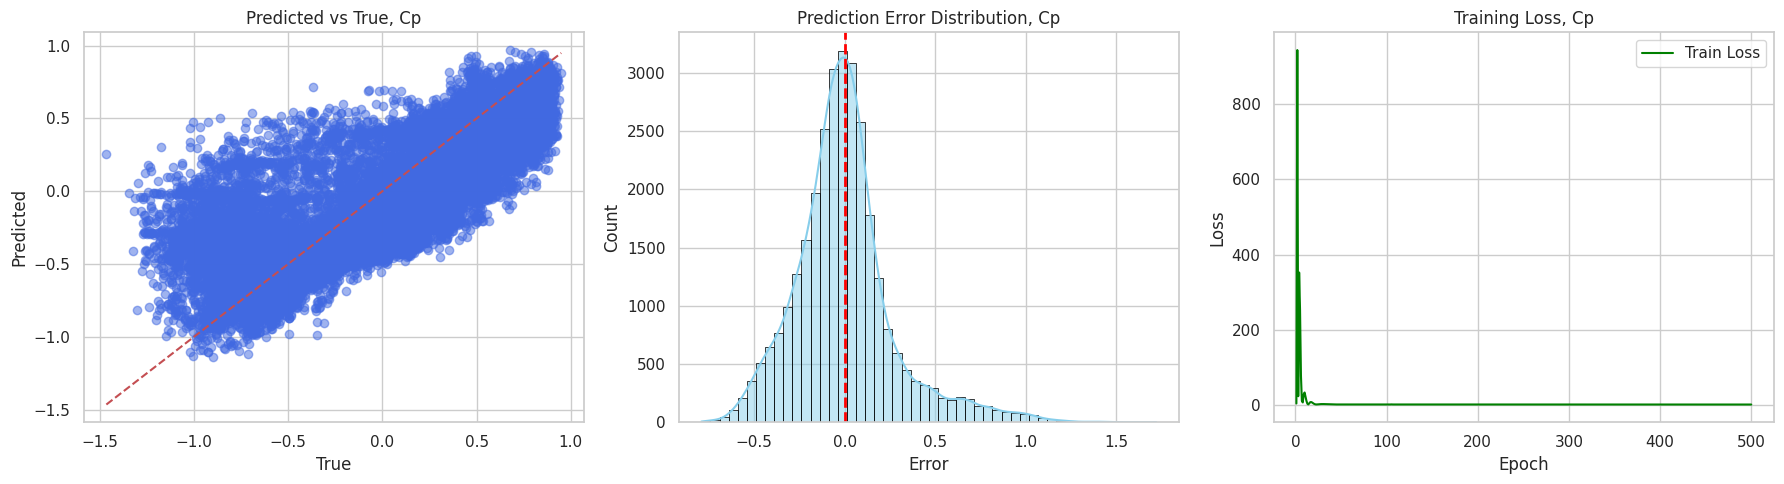

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 44/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.99it/s]

Epoch [10/500], Loss: 6.7962


Epochs:   4%|▍         | 20/500 [00:00<00:05, 95.33it/s]

Epoch [20/500], Loss: 2.3344
Epoch [30/500], Loss: 0.3816


Epochs:   6%|▋         | 32/500 [00:00<00:04, 103.60it/s]

Epoch [40/500], Loss: 0.2627


Epochs:  11%|█         | 56/500 [00:00<00:04, 109.68it/s]

Epoch [50/500], Loss: 0.2299
Epoch [60/500], Loss: 0.2079


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 111.82it/s]

Epoch [70/500], Loss: 0.1983


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 113.81it/s]

Epoch [80/500], Loss: 0.1869
Epoch [90/500], Loss: 0.1761
Epoch [100/500], Loss: 0.1654


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 114.52it/s]

Epoch [110/500], Loss: 0.1538
Epoch [120/500], Loss: 0.1395


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 114.84it/s]

Epoch [130/500], Loss: 0.1299


Epochs:  30%|███       | 152/500 [00:01<00:03, 115.21it/s]

Epoch [140/500], Loss: 0.1278
Epoch [150/500], Loss: 0.1255
Epoch [160/500], Loss: 0.1221


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 115.27it/s]

Epoch [170/500], Loss: 0.1144
Epoch [180/500], Loss: 0.1070


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 115.27it/s]

Epoch [190/500], Loss: 0.1030


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 114.43it/s]

Epoch [200/500], Loss: 0.1001
Epoch [210/500], Loss: 0.0978
Epoch [220/500], Loss: 0.0959


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 114.64it/s]

Epoch [230/500], Loss: 0.0941
Epoch [240/500], Loss: 0.0926


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 114.90it/s]

Epoch [250/500], Loss: 0.0917


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 115.12it/s]

Epoch [260/500], Loss: 0.0909
Epoch [270/500], Loss: 0.0899
Epoch [280/500], Loss: 0.0884


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 114.99it/s]

Epoch [290/500], Loss: 0.0873
Epoch [300/500], Loss: 0.0865


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 115.21it/s]

Epoch [310/500], Loss: 0.0872


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 114.99it/s]

Epoch [320/500], Loss: 0.0851
Epoch [330/500], Loss: 0.0848
Epoch [340/500], Loss: 0.0837


Epochs:  71%|███████   | 356/500 [00:03<00:01, 114.50it/s]

Epoch [350/500], Loss: 0.0834
Epoch [360/500], Loss: 0.0826


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 114.80it/s]

Epoch [370/500], Loss: 0.0873


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 115.08it/s]

Epoch [380/500], Loss: 0.0837
Epoch [390/500], Loss: 0.0815
Epoch [400/500], Loss: 0.0800


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 114.46it/s]

Epoch [410/500], Loss: 0.0792
Epoch [420/500], Loss: 0.0803


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 114.71it/s]

Epoch [430/500], Loss: 0.0784


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 114.94it/s]

Epoch [440/500], Loss: 0.0776
Epoch [450/500], Loss: 0.0784
Epoch [460/500], Loss: 0.0787


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 115.11it/s]

Epoch [470/500], Loss: 0.0790
Epoch [480/500], Loss: 0.0763


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 114.40it/s]

Epoch [490/500], Loss: 0.0751


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.89it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0758
📈 Evaluation metrics on test set:
MSE: 0.0760
MAE: 0.1923
R2: 0.6933


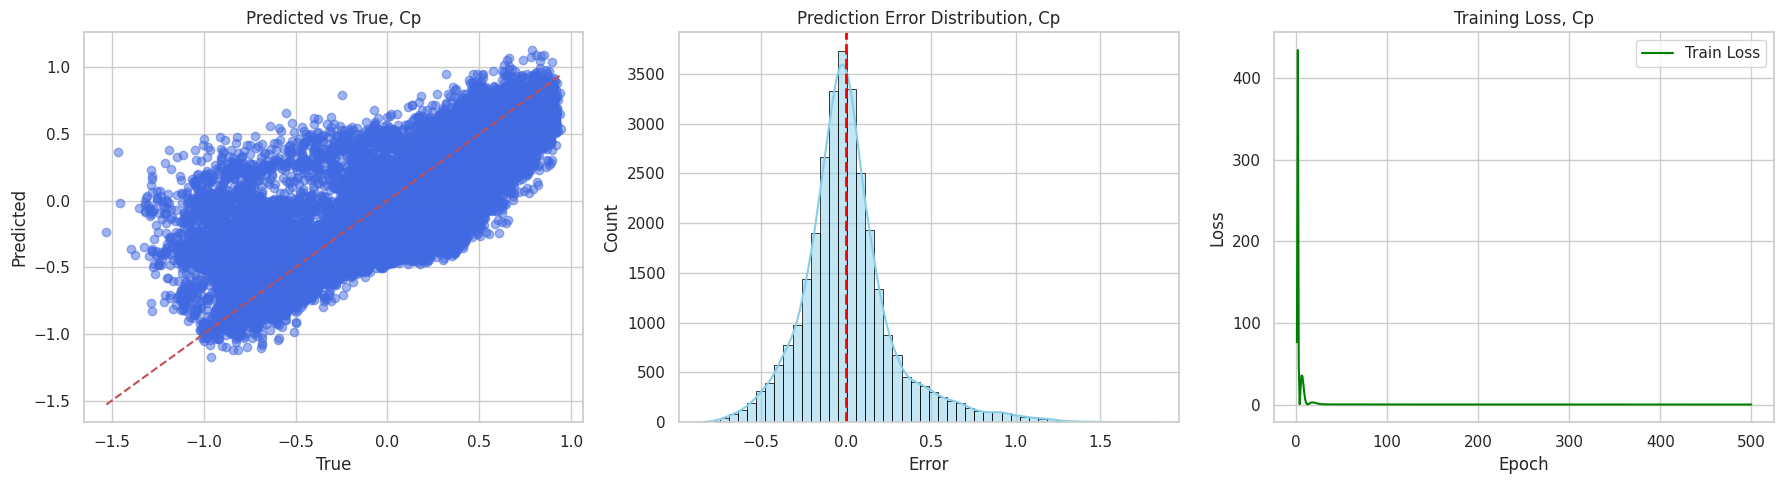

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 45/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.16it/s]

Epoch [10/500], Loss: 13.0501


Epochs:   4%|▍         | 20/500 [00:00<00:05, 94.31it/s]

Epoch [20/500], Loss: 2.0220
Epoch [30/500], Loss: 1.2678


Epochs:   6%|▋         | 32/500 [00:00<00:04, 103.41it/s]

Epoch [40/500], Loss: 0.5631


Epochs:  11%|█         | 56/500 [00:00<00:04, 110.78it/s]

Epoch [50/500], Loss: 0.3271
Epoch [60/500], Loss: 0.2609


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 112.36it/s]

Epoch [70/500], Loss: 0.2416


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 113.95it/s]

Epoch [80/500], Loss: 0.2299
Epoch [90/500], Loss: 0.2083
Epoch [100/500], Loss: 0.2023


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 114.65it/s]

Epoch [110/500], Loss: 0.1956
Epoch [120/500], Loss: 0.1906


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 114.70it/s]

Epoch [130/500], Loss: 0.1866


Epochs:  30%|███       | 152/500 [00:01<00:03, 115.30it/s]

Epoch [140/500], Loss: 0.1823
Epoch [150/500], Loss: 0.1793
Epoch [160/500], Loss: 0.1768


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 115.37it/s]

Epoch [170/500], Loss: 0.1850
Epoch [180/500], Loss: 0.1712


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 115.53it/s]

Epoch [190/500], Loss: 0.1575


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 115.56it/s]

Epoch [200/500], Loss: 0.1446
Epoch [210/500], Loss: 0.1386
Epoch [220/500], Loss: 0.1347


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 115.68it/s]

Epoch [230/500], Loss: 0.1289
Epoch [240/500], Loss: 0.1190


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 115.69it/s]

Epoch [250/500], Loss: 0.1096


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 115.57it/s]

Epoch [260/500], Loss: 0.1036
Epoch [270/500], Loss: 0.0957
Epoch [280/500], Loss: 0.0919


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 115.63it/s]

Epoch [290/500], Loss: 0.0879
Epoch [300/500], Loss: 0.0859


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 115.72it/s]

Epoch [310/500], Loss: 0.1132


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 114.99it/s]

Epoch [320/500], Loss: 0.0976
Epoch [330/500], Loss: 0.0897
Epoch [340/500], Loss: 0.0854


Epochs:  71%|███████   | 356/500 [00:03<00:01, 115.34it/s]

Epoch [350/500], Loss: 0.0832
Epoch [360/500], Loss: 0.0823


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 115.41it/s]

Epoch [370/500], Loss: 0.0812


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 115.10it/s]

Epoch [380/500], Loss: 0.0803
Epoch [390/500], Loss: 0.0791
Epoch [400/500], Loss: 0.0784


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 114.51it/s]

Epoch [410/500], Loss: 0.0779
Epoch [420/500], Loss: 0.0767


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 114.10it/s]

Epoch [430/500], Loss: 0.0785


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 114.69it/s]

Epoch [440/500], Loss: 0.0761
Epoch [450/500], Loss: 0.0753
Epoch [460/500], Loss: 0.0747


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 114.90it/s]

Epoch [470/500], Loss: 0.0749
Epoch [480/500], Loss: 0.0775


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 115.27it/s]

Epoch [490/500], Loss: 0.0743


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.20it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0721
📈 Evaluation metrics on test set:
MSE: 0.0729
MAE: 0.1939
R2: 0.7043


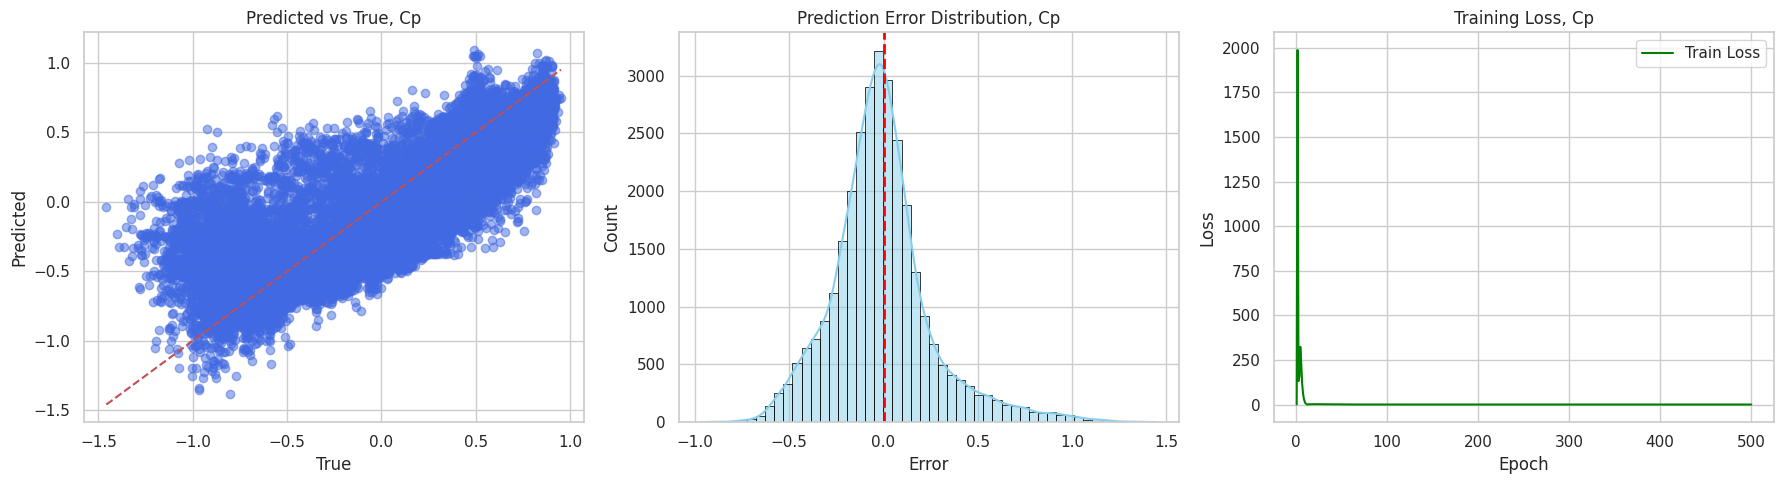

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 46/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 20/500 [00:00<00:05, 94.25it/s]

Epoch [10/500], Loss: 4.3565
Epoch [20/500], Loss: 1.4321
Epoch [30/500], Loss: 0.3567


Epochs:  11%|█         | 56/500 [00:00<00:03, 111.32it/s]

Epoch [40/500], Loss: 0.2365
Epoch [50/500], Loss: 0.2227
Epoch [60/500], Loss: 0.2163


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 114.61it/s]

Epoch [70/500], Loss: 0.2112
Epoch [80/500], Loss: 0.2075
Epoch [90/500], Loss: 0.2054


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 115.31it/s]

Epoch [100/500], Loss: 0.2037
Epoch [110/500], Loss: 0.2020
Epoch [120/500], Loss: 0.2002


Epochs:  30%|███       | 152/500 [00:01<00:03, 115.82it/s]

Epoch [130/500], Loss: 0.1983
Epoch [140/500], Loss: 0.1965
Epoch [150/500], Loss: 0.1940


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 115.61it/s]

Epoch [160/500], Loss: 0.1693
Epoch [170/500], Loss: 0.1526
Epoch [180/500], Loss: 0.1423


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 115.16it/s]

Epoch [190/500], Loss: 0.1237
Epoch [200/500], Loss: 0.1120
Epoch [210/500], Loss: 0.1048


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 115.29it/s]

Epoch [220/500], Loss: 0.1004
Epoch [230/500], Loss: 0.0976
Epoch [240/500], Loss: 0.0953


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 115.39it/s]

Epoch [250/500], Loss: 0.0929
Epoch [260/500], Loss: 0.0915
Epoch [270/500], Loss: 0.0870


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 115.38it/s]

Epoch [280/500], Loss: 0.0833
Epoch [290/500], Loss: 0.0806
Epoch [300/500], Loss: 0.0786


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 115.15it/s]

Epoch [310/500], Loss: 0.0777
Epoch [320/500], Loss: 0.0766
Epoch [330/500], Loss: 0.0759


Epochs:  71%|███████   | 356/500 [00:03<00:01, 115.39it/s]

Epoch [340/500], Loss: 0.0752
Epoch [350/500], Loss: 0.0747
Epoch [360/500], Loss: 0.0741


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 115.15it/s]

Epoch [370/500], Loss: 0.0737
Epoch [380/500], Loss: 0.0732
Epoch [390/500], Loss: 0.0729


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 115.25it/s]

Epoch [400/500], Loss: 0.0733
Epoch [410/500], Loss: 0.0740
Epoch [420/500], Loss: 0.0701


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 115.12it/s]

Epoch [430/500], Loss: 0.0694
Epoch [440/500], Loss: 0.0685
Epoch [450/500], Loss: 0.0681


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 115.32it/s]

Epoch [460/500], Loss: 0.0676
Epoch [470/500], Loss: 0.0671
Epoch [480/500], Loss: 0.0667


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.35it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0663
Epoch [500/500], Loss: 0.0658
📈 Evaluation metrics on test set:
MSE: 0.0653
MAE: 0.1746
R2: 0.7347


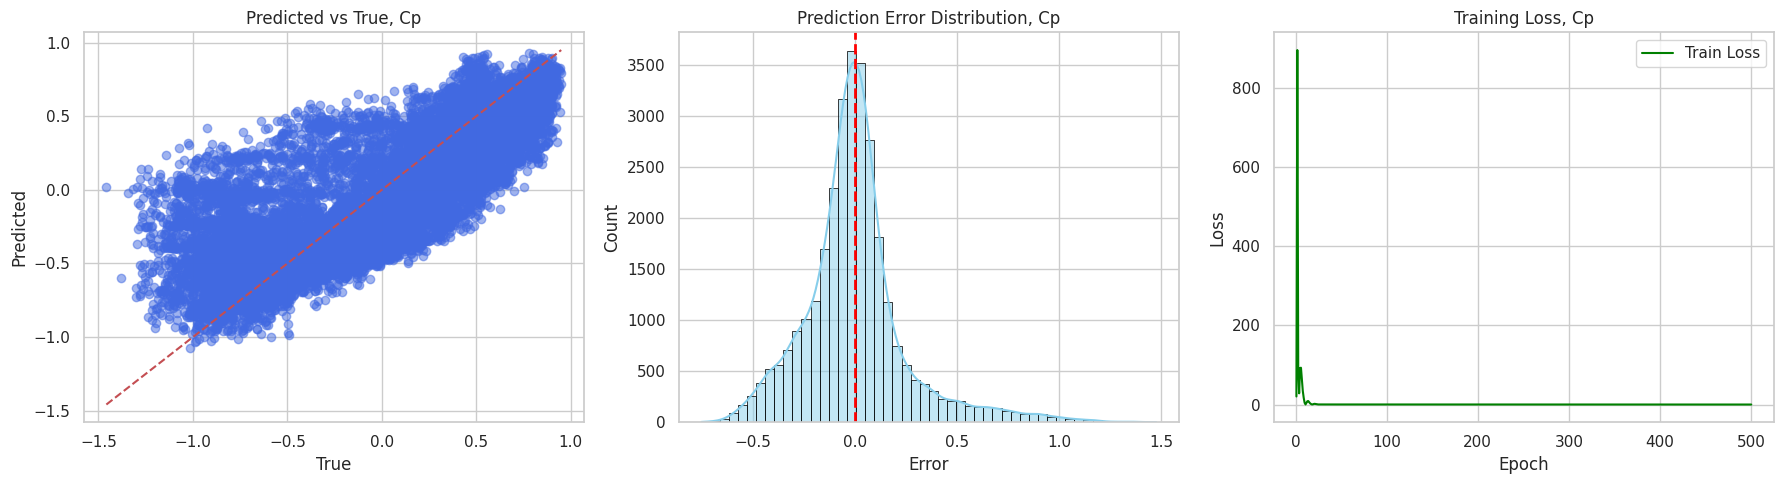

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 47/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 117.13it/s]

Epoch [10/500], Loss: 0.2484
Epoch [20/500], Loss: 4.9075
Epoch [30/500], Loss: 0.2503


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 115.48it/s]

Epoch [40/500], Loss: 0.3447
Epoch [50/500], Loss: 0.3317
Epoch [60/500], Loss: 0.2604


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 115.51it/s]

Epoch [70/500], Loss: 0.2264
Epoch [80/500], Loss: 0.2219
Epoch [90/500], Loss: 0.2178


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 115.40it/s]

Epoch [100/500], Loss: 0.2061
Epoch [110/500], Loss: 0.1944
Epoch [120/500], Loss: 0.1835


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 115.68it/s]

Epoch [130/500], Loss: 0.1713
Epoch [140/500], Loss: 0.1604
Epoch [150/500], Loss: 0.1501


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 115.37it/s]

Epoch [160/500], Loss: 0.1378
Epoch [170/500], Loss: 0.1269
Epoch [180/500], Loss: 0.1175


Epochs:  41%|████      | 206/500 [00:01<00:02, 115.00it/s]

Epoch [190/500], Loss: 0.1101
Epoch [200/500], Loss: 0.1044
Epoch [210/500], Loss: 0.1003


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 114.82it/s]

Epoch [220/500], Loss: 0.0970
Epoch [230/500], Loss: 0.0947
Epoch [240/500], Loss: 0.0918


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 114.64it/s]

Epoch [250/500], Loss: 0.0887
Epoch [260/500], Loss: 0.0854
Epoch [270/500], Loss: 0.0827


Epochs:  60%|██████    | 302/500 [00:02<00:01, 114.48it/s]

Epoch [280/500], Loss: 0.0813
Epoch [290/500], Loss: 0.0798
Epoch [300/500], Loss: 0.0787


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 114.29it/s]

Epoch [310/500], Loss: 0.0781
Epoch [320/500], Loss: 0.0769
Epoch [330/500], Loss: 0.0764


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 114.67it/s]

Epoch [340/500], Loss: 0.0755
Epoch [350/500], Loss: 0.0749
Epoch [360/500], Loss: 0.0746


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 114.12it/s]

Epoch [370/500], Loss: 0.0738
Epoch [380/500], Loss: 0.2278
Epoch [390/500], Loss: 0.1120


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 114.44it/s]

Epoch [400/500], Loss: 0.0872
Epoch [410/500], Loss: 0.0822
Epoch [420/500], Loss: 0.0774


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 114.21it/s]

Epoch [430/500], Loss: 0.0754
Epoch [440/500], Loss: 0.0744
Epoch [450/500], Loss: 0.0738


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 114.14it/s]

Epoch [460/500], Loss: 0.0734
Epoch [470/500], Loss: 0.0730
Epoch [480/500], Loss: 0.0727


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.75it/s]


Epoch [490/500], Loss: 0.0724
Epoch [500/500], Loss: 0.0721
📈 Evaluation metrics on test set:
MSE: 0.0731
MAE: 0.1879
R2: 0.7070


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


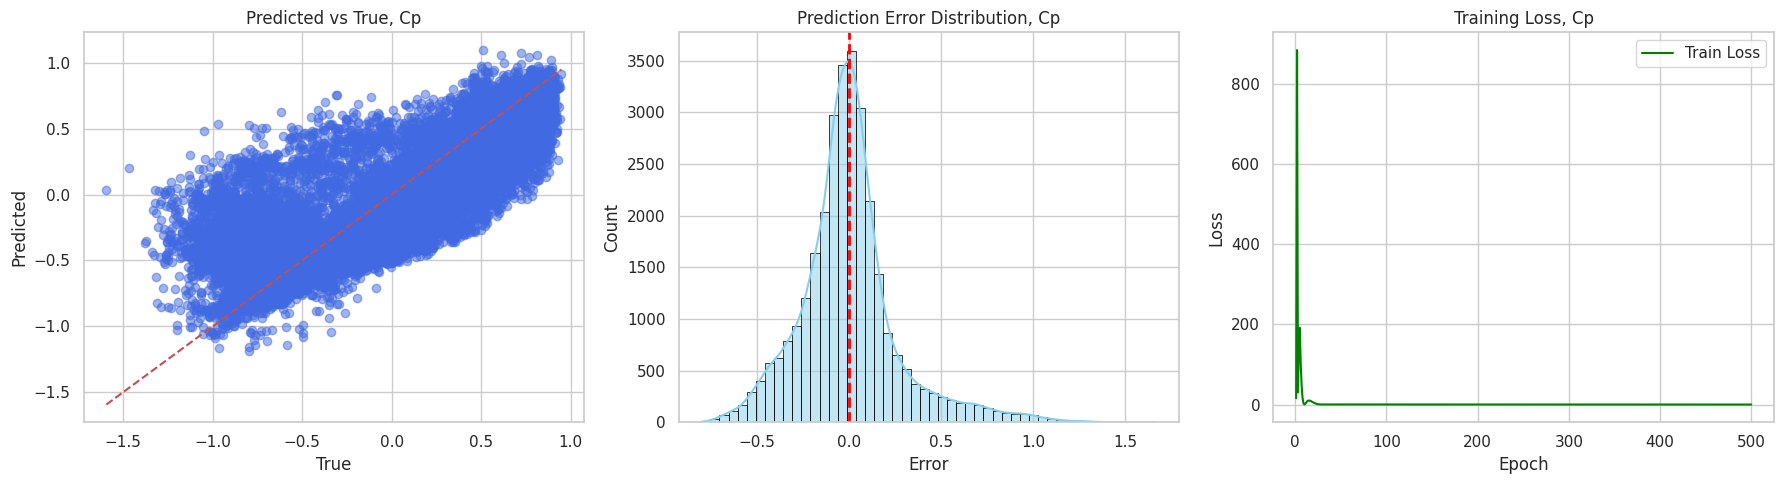

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 48/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 91.08it/s]

Epoch [10/500], Loss: 58.9539


Epochs:   4%|▍         | 20/500 [00:00<00:05, 95.20it/s]

Epoch [20/500], Loss: 9.1621
Epoch [30/500], Loss: 0.2413


Epochs:   6%|▋         | 32/500 [00:00<00:04, 103.67it/s]

Epoch [40/500], Loss: 0.2940


Epochs:  11%|█         | 56/500 [00:00<00:04, 109.93it/s]

Epoch [50/500], Loss: 0.2414
Epoch [60/500], Loss: 0.2217


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 111.09it/s]

Epoch [70/500], Loss: 0.2178


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 112.28it/s]

Epoch [80/500], Loss: 0.2125
Epoch [90/500], Loss: 0.2096
Epoch [100/500], Loss: 0.1932


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 112.68it/s]

Epoch [110/500], Loss: 0.1720
Epoch [120/500], Loss: 0.1656


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 113.08it/s]

Epoch [130/500], Loss: 0.1417


Epochs:  30%|███       | 152/500 [00:01<00:03, 113.27it/s]

Epoch [140/500], Loss: 0.1287
Epoch [150/500], Loss: 0.1198
Epoch [160/500], Loss: 0.1136


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 113.69it/s]

Epoch [170/500], Loss: 0.1100
Epoch [180/500], Loss: 0.1071


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 113.84it/s]

Epoch [190/500], Loss: 0.1048


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 113.62it/s]

Epoch [200/500], Loss: 0.1031
Epoch [210/500], Loss: 0.1013
Epoch [220/500], Loss: 0.0988


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 114.15it/s]

Epoch [230/500], Loss: 0.0962
Epoch [240/500], Loss: 0.0946


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 113.90it/s]

Epoch [250/500], Loss: 0.0926


Epochs:  54%|█████▍    | 272/500 [00:02<00:02, 113.49it/s]

Epoch [260/500], Loss: 0.0908
Epoch [270/500], Loss: 0.0889
Epoch [280/500], Loss: 0.0890


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 113.58it/s]

Epoch [290/500], Loss: 0.0871
Epoch [300/500], Loss: 0.0846


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 113.42it/s]

Epoch [310/500], Loss: 0.0831


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 113.80it/s]

Epoch [320/500], Loss: 0.0818
Epoch [330/500], Loss: 0.0807
Epoch [340/500], Loss: 0.0818


Epochs:  71%|███████   | 356/500 [00:03<00:01, 114.22it/s]

Epoch [350/500], Loss: 0.0809
Epoch [360/500], Loss: 0.0784


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 113.65it/s]

Epoch [370/500], Loss: 0.0773


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 113.37it/s]

Epoch [380/500], Loss: 0.0764
Epoch [390/500], Loss: 0.0756
Epoch [400/500], Loss: 0.0752


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 113.84it/s]

Epoch [410/500], Loss: 0.0740
Epoch [420/500], Loss: 0.0752


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 113.78it/s]

Epoch [430/500], Loss: 0.0734


Epochs:  90%|█████████ | 452/500 [00:04<00:00, 113.83it/s]

Epoch [440/500], Loss: 0.0721
Epoch [450/500], Loss: 0.0706
Epoch [460/500], Loss: 0.0708


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 113.13it/s]

Epoch [470/500], Loss: 0.0692
Epoch [480/500], Loss: 0.0722


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 113.54it/s]

Epoch [490/500], Loss: 0.0678


Epochs: 100%|██████████| 500/500 [00:04<00:00, 112.71it/s]


Epoch [500/500], Loss: 0.0667
📈 Evaluation metrics on test set:
MSE: 0.0668
MAE: 0.1821
R2: 0.7287


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


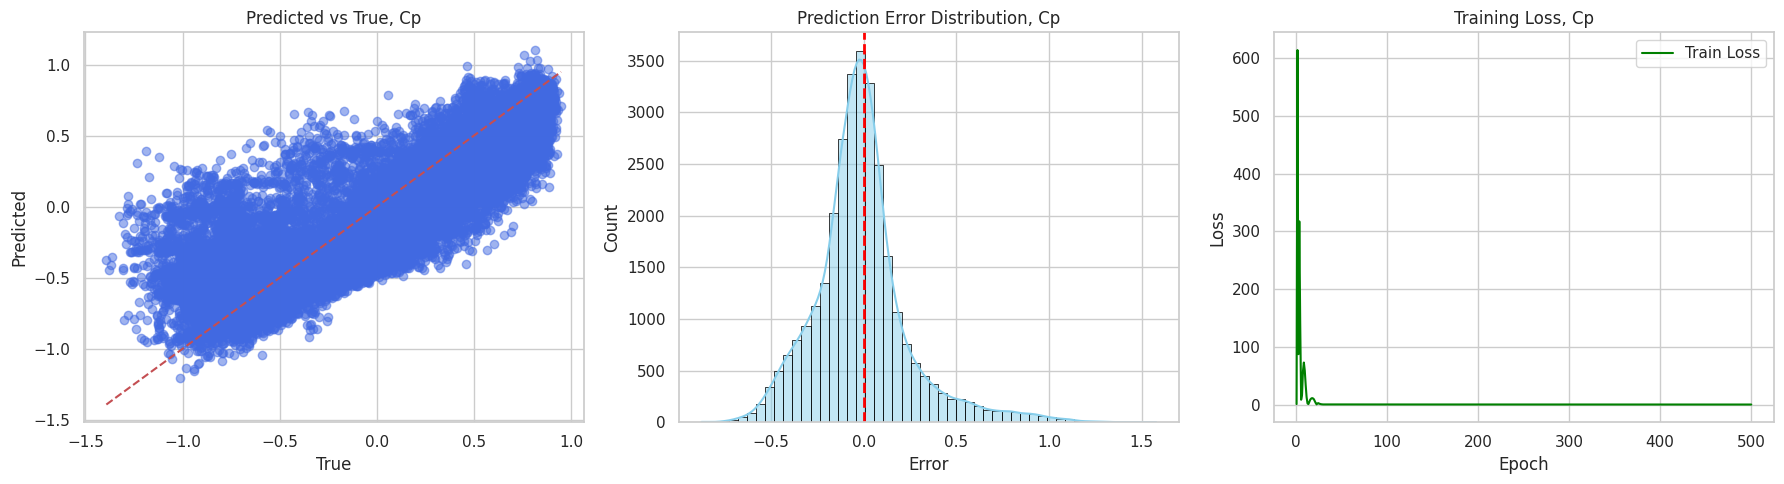

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 49/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 90.85it/s]

Epoch [10/500], Loss: 9.2690


Epochs:   4%|▍         | 20/500 [00:00<00:05, 91.88it/s]

Epoch [20/500], Loss: 2.1592
Epoch [30/500], Loss: 0.2296


Epochs:   6%|▋         | 32/500 [00:00<00:04, 101.91it/s]

Epoch [40/500], Loss: 0.2610


Epochs:  11%|█         | 56/500 [00:00<00:04, 110.06it/s]

Epoch [50/500], Loss: 0.2304
Epoch [60/500], Loss: 0.2253


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 111.88it/s]

Epoch [70/500], Loss: 0.2159


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 113.53it/s]

Epoch [80/500], Loss: 0.2098
Epoch [90/500], Loss: 0.2066
Epoch [100/500], Loss: 0.2042


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 114.31it/s]

Epoch [110/500], Loss: 0.2019
Epoch [120/500], Loss: 0.1945


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 114.42it/s]

Epoch [130/500], Loss: 0.1770


Epochs:  30%|███       | 152/500 [00:01<00:03, 114.14it/s]

Epoch [140/500], Loss: 0.1588
Epoch [150/500], Loss: 0.1458
Epoch [160/500], Loss: 0.1330


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 114.17it/s]

Epoch [170/500], Loss: 0.1225
Epoch [180/500], Loss: 0.1162


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 114.03it/s]

Epoch [190/500], Loss: 0.1111


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 114.16it/s]

Epoch [200/500], Loss: 0.1084
Epoch [210/500], Loss: 0.1060
Epoch [220/500], Loss: 0.1040


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 113.67it/s]

Epoch [230/500], Loss: 0.1021
Epoch [240/500], Loss: 0.1003


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 114.07it/s]

Epoch [250/500], Loss: 0.0986


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 114.45it/s]

Epoch [260/500], Loss: 0.0971
Epoch [270/500], Loss: 0.0982
Epoch [280/500], Loss: 0.0923


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 114.37it/s]

Epoch [290/500], Loss: 0.0890
Epoch [300/500], Loss: 0.0944


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 113.99it/s]

Epoch [310/500], Loss: 0.0883


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 114.26it/s]

Epoch [320/500], Loss: 0.0859
Epoch [330/500], Loss: 0.0844
Epoch [340/500], Loss: 0.0834


Epochs:  71%|███████   | 356/500 [00:03<00:01, 114.55it/s]

Epoch [350/500], Loss: 0.0828
Epoch [360/500], Loss: 0.0822


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 114.67it/s]

Epoch [370/500], Loss: 0.0817


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 114.68it/s]

Epoch [380/500], Loss: 0.0812
Epoch [390/500], Loss: 0.0808
Epoch [400/500], Loss: 0.0803


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 114.65it/s]

Epoch [410/500], Loss: 0.0814
Epoch [420/500], Loss: 0.0829


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 114.81it/s]

Epoch [430/500], Loss: 0.0791


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 114.50it/s]

Epoch [440/500], Loss: 0.0791
Epoch [450/500], Loss: 0.0775
Epoch [460/500], Loss: 0.0808


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 114.20it/s]

Epoch [470/500], Loss: 0.0778
Epoch [480/500], Loss: 0.0759


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 114.57it/s]

Epoch [490/500], Loss: 0.0751


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.30it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0744
📈 Evaluation metrics on test set:
MSE: 0.0753
MAE: 0.1925
R2: 0.6959


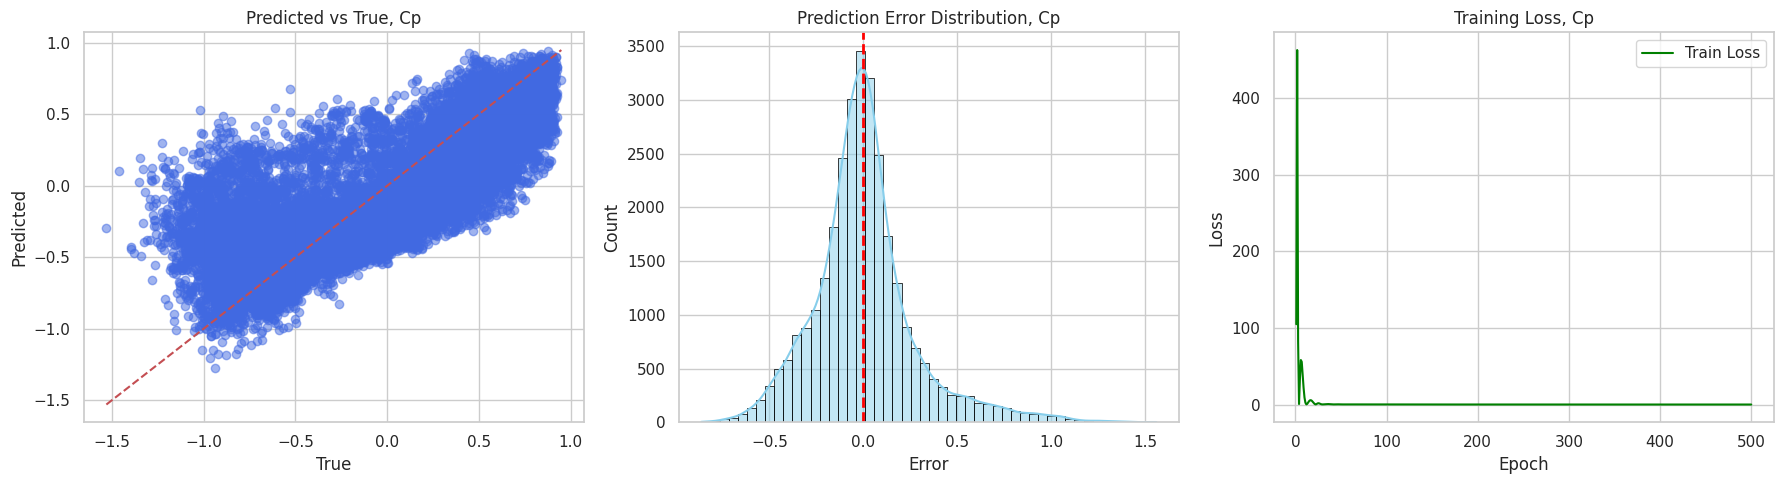

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 50/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   2%|▏         | 12/500 [00:00<00:04, 113.30it/s]

Epoch [10/500], Loss: 0.8549
Epoch [20/500], Loss: 6.2203


Epochs:   5%|▍         | 24/500 [00:00<00:04, 107.25it/s]

Epoch [30/500], Loss: 0.5213


Epochs:  10%|▉         | 48/500 [00:00<00:04, 110.98it/s]

Epoch [40/500], Loss: 0.2544
Epoch [50/500], Loss: 0.2543


Epochs:  12%|█▏        | 60/500 [00:00<00:03, 112.45it/s]

Epoch [60/500], Loss: 0.2447


Epochs:  14%|█▍        | 72/500 [00:00<00:03, 113.22it/s]

Epoch [70/500], Loss: 0.2282
Epoch [80/500], Loss: 0.2193


Epochs:  17%|█▋        | 84/500 [00:00<00:03, 114.07it/s]

Epoch [90/500], Loss: 0.2098


Epochs:  22%|██▏       | 108/500 [00:00<00:03, 114.56it/s]

Epoch [100/500], Loss: 0.2448
Epoch [110/500], Loss: 0.1850


Epochs:  24%|██▍       | 120/500 [00:01<00:03, 114.09it/s]

Epoch [120/500], Loss: 0.1819


Epochs:  26%|██▋       | 132/500 [00:01<00:03, 114.20it/s]

Epoch [130/500], Loss: 0.1556
Epoch [140/500], Loss: 0.1399


Epochs:  29%|██▉       | 144/500 [00:01<00:03, 114.50it/s]

Epoch [150/500], Loss: 0.1281


Epochs:  34%|███▎      | 168/500 [00:01<00:02, 114.20it/s]

Epoch [160/500], Loss: 0.1252
Epoch [170/500], Loss: 0.1235


Epochs:  36%|███▌      | 180/500 [00:01<00:02, 114.30it/s]

Epoch [180/500], Loss: 0.1205


Epochs:  38%|███▊      | 192/500 [00:01<00:02, 114.42it/s]

Epoch [190/500], Loss: 0.1257
Epoch [200/500], Loss: 0.1151


Epochs:  41%|████      | 204/500 [00:01<00:02, 114.07it/s]

Epoch [210/500], Loss: 0.1094


Epochs:  46%|████▌     | 228/500 [00:02<00:02, 114.04it/s]

Epoch [220/500], Loss: 0.1114
Epoch [230/500], Loss: 0.1111


Epochs:  48%|████▊     | 240/500 [00:02<00:02, 114.13it/s]

Epoch [240/500], Loss: 0.1019


Epochs:  50%|█████     | 252/500 [00:02<00:02, 114.28it/s]

Epoch [250/500], Loss: 0.1053
Epoch [260/500], Loss: 0.0998


Epochs:  53%|█████▎    | 264/500 [00:02<00:02, 114.46it/s]

Epoch [270/500], Loss: 0.1026


Epochs:  58%|█████▊    | 288/500 [00:02<00:01, 114.65it/s]

Epoch [280/500], Loss: 0.1109
Epoch [290/500], Loss: 0.0966


Epochs:  60%|██████    | 300/500 [00:02<00:01, 114.08it/s]

Epoch [300/500], Loss: 0.0876


Epochs:  62%|██████▏   | 312/500 [00:02<00:01, 114.37it/s]

Epoch [310/500], Loss: 0.0859
Epoch [320/500], Loss: 0.0824


Epochs:  65%|██████▍   | 324/500 [00:02<00:01, 113.92it/s]

Epoch [330/500], Loss: 0.1118


Epochs:  70%|██████▉   | 348/500 [00:03<00:01, 114.56it/s]

Epoch [340/500], Loss: 0.0817
Epoch [350/500], Loss: 0.0843


Epochs:  72%|███████▏  | 360/500 [00:03<00:01, 114.10it/s]

Epoch [360/500], Loss: 0.0819


Epochs:  74%|███████▍  | 372/500 [00:03<00:01, 114.01it/s]

Epoch [370/500], Loss: 0.0783
Epoch [380/500], Loss: 0.0773


Epochs:  77%|███████▋  | 384/500 [00:03<00:01, 114.17it/s]

Epoch [390/500], Loss: 0.0787


Epochs:  82%|████████▏ | 408/500 [00:03<00:00, 114.19it/s]

Epoch [400/500], Loss: 0.0818
Epoch [410/500], Loss: 0.0966


Epochs:  84%|████████▍ | 420/500 [00:03<00:00, 114.37it/s]

Epoch [420/500], Loss: 0.0809


Epochs:  86%|████████▋ | 432/500 [00:03<00:00, 113.89it/s]

Epoch [430/500], Loss: 0.0790
Epoch [440/500], Loss: 0.0786


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 113.90it/s]

Epoch [450/500], Loss: 0.0764


Epochs:  94%|█████████▎| 468/500 [00:04<00:00, 113.71it/s]

Epoch [460/500], Loss: 0.0754
Epoch [470/500], Loss: 0.0792


Epochs:  96%|█████████▌| 480/500 [00:04<00:00, 113.79it/s]

Epoch [480/500], Loss: 0.0745


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.86it/s]

Epoch [490/500], Loss: 0.0739
Epoch [500/500], Loss: 0.0729
📈 Evaluation metrics on test set:
MSE: 0.0723
MAE: 0.1843
R2: 0.7046



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


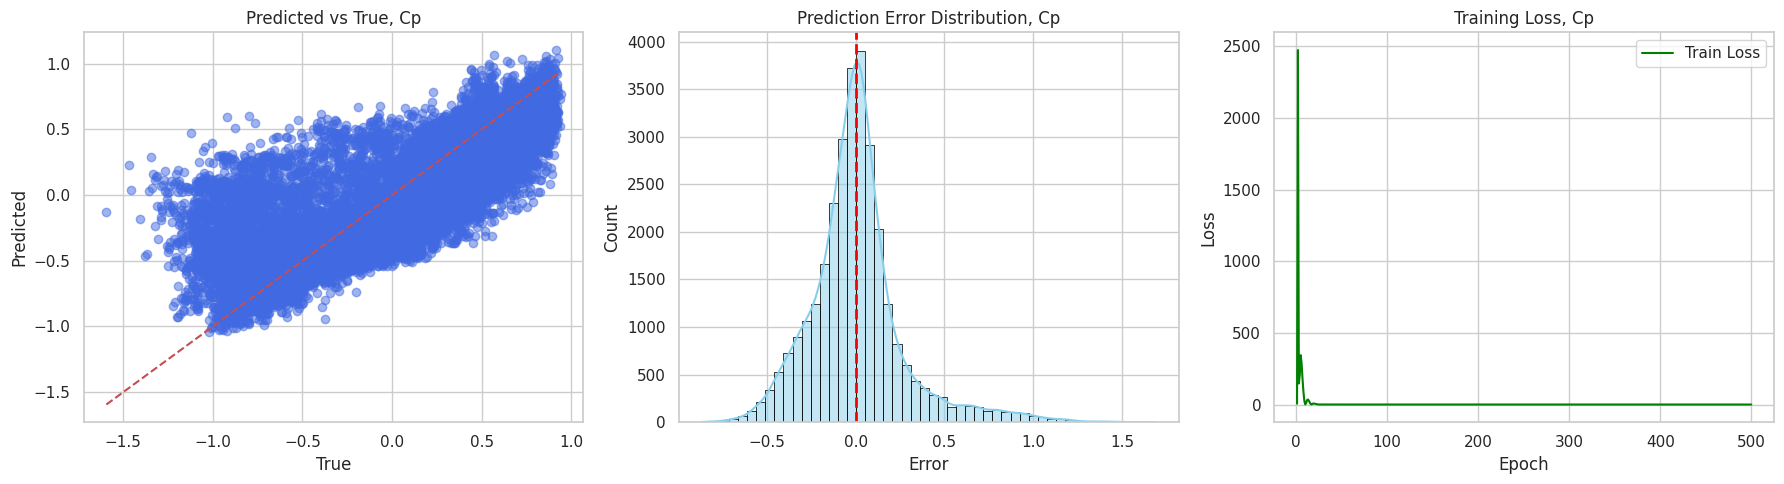

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png


In [8]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
hidden_dim_choices = [128]
lr_choices = [round(x, 5) for x in list(np.arange(0.007, 0.01, 0.0005))]

#hidden_dim_choices = [128, 264]
#lr_choices = [ 1e-3, 5e-3]

# 📌 Fixed parameters
EPOCHS = 500
BATCH_SIZE = 64
OUTPUT_DIM = 1
#N_RUNS = 10  # Total number of runs
N_RUNS = 50  # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM
    )

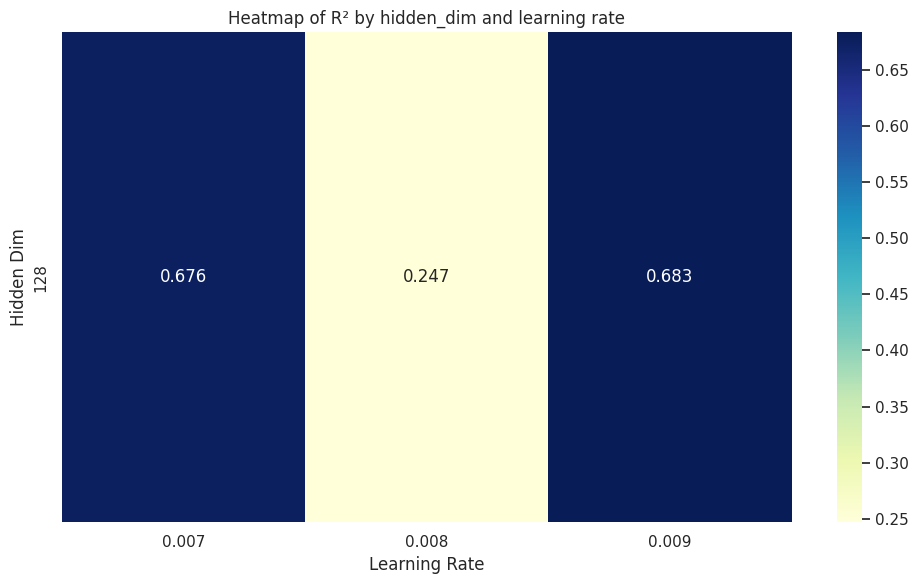


🏆 Best result:
Run ID      : mlp_128h_7e-03lr_64bs_500ep
Hidden Dim  : 128
Learning Rate: 0.00700
R²          : 0.7357
MAE         : 0.1817
MSE         : 0.065921

📌 R² threshold (95% of max): 0.6989
🔍 Found 24 stable candidates:

    hidden_dim     lr      R2     MAE       MSE
26         128  0.007  0.7357  0.1817  0.065921
45         128  0.009  0.7347  0.1746  0.065326
18         128  0.009  0.7287  0.1852  0.067707
47         128  0.009  0.7287  0.1821  0.066847
35         128  0.007  0.7244  0.1834  0.067917
12         128  0.007  0.7234  0.1840  0.068777
15         128  0.007  0.7197  0.1860  0.069030
38         128  0.007  0.7151  0.1825  0.069608
32         128  0.007  0.7143  0.1867  0.070706
21         128  0.009  0.7130  0.1831  0.071670
46         128  0.007  0.7070  0.1879  0.073068
3          128  0.007  0.7069  0.1895  0.072702
8          128  0.008  0.7068  0.1858  0.072289
11         128  0.007  0.7067  0.1863  0.072454
36         128  0.007  0.7065  0.1900  0.073579


In [9]:
# 📁 src/tuning/visualize_search_results.py
# ➤ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📥 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH, header=None)
df_log.columns = ["run_id", "hidden_dim", "lr", "R2", "MAE", "MSE"]

# 📊 Pivot table for heatmap
pivot_table = df_log.pivot_table(
    values="R2",
    index="hidden_dim",
    columns="lr",
    aggfunc="mean"  # handles repeated runs with same params
)

# 🔥 Draw heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Heatmap of R² by hidden_dim and learning rate")
plt.xlabel("Learning Rate")
plt.ylabel("Hidden Dim")
plt.tight_layout()
plt.show()

# 🏆 Show best configuration
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\n🏆 Best result:")
print(f"Run ID      : {best_row['run_id']}")
print(f"Hidden Dim  : {int(best_row['hidden_dim'])}")
print(f"Learning Rate: {best_row['lr']:.5f}")
print(f"R²          : {best_row['R2']:.4f}")
print(f"MAE         : {best_row['MAE']:.4f}")
print(f"MSE         : {best_row['MSE']:.6f}")

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n📌 R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "R2", "MAE", "MSE"]])

